purpose: to identify marker genes using the method described by cellxgene. data extracted in scRNA-seq-export_count_data.ipynb

source: https://cellxgene.cziscience.com/docs/04__Analyze%20Public%20Data/4_2__Gene%20Expression%20Documentation/4_2_5__Find%20Marker%20Genes

# set-up

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import scipy.stats as stats
import json
import re
import matplotlib.pyplot as plt
#from matplotlib_venn import venn2,venn3
#import mygene
#mg = mygene.MyGeneInfo()
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet

In [2]:
rerun_stat_analysis=False

In [3]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [4]:
data_dir='scRNA_seq/processed/'

In [5]:
roi_list=['Epithalamus',
 'Hindbrain',
 'Hippocampus',
 'Hypothalamus',
 'Midbrain',
 'Paleocortex',
 'Spinal cord',
 'Thalamus',
'Cerebral nuclei',
 'Cerebral cortex']

In [6]:
metric=['mean','stdev','sum','count_nonzero','count']

# fuctions

In [7]:
def parse_fasta_to_dataframe(fasta_file):
    data = []
    with open(fasta_file, 'r') as file:
        header = None
        sequence = []
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                if header is not None:  # Save the previous record
                    data.append((header, ''.join(sequence)))
                header = line[1:]  # Remove '>'
                sequence = []
            else:
                sequence.append(line)
        # Add the last record
        if header is not None:
            data.append((header, ''.join(sequence)))
    records = []
    parts={}
    for header, sequence in data:
        #split string as " *:" pattern
        str_split = re.split(r' (?=\w+:)', header)
        #split into dictionary with *:x * being the column name and x being the value
        parts={x.split(":")[0]: x.split(":")[1] for x in str_split[2:] if ":" in x}
        #manually split those that don't follow the initial pattern
        parts["id"] = header.split(' ')[0]
        parts["type"] = header.split(' ')[1]
        parts['locus']=str_split[1][11:]
        records.append(parts)
    df = pd.DataFrame(records)
    df=df.drop(['NADH','A','tRNA'],axis=1)
    return(df)

# import data

## meta-data

In [8]:
pcnet_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])

In [9]:
gene_data=pd.read_csv('scRNA_seq/gene_meta_data_brain_atlas.csv',sep=',')

In [10]:
#from ensembl # grepped ENSG to remove the sequence
rna_data =parse_fasta_to_dataframe('scRNA_seq/transcript_id_meta/Homo_sapiens.GRCh38_rm_seq.cdna.all.txt')

In [11]:
set(rna_data[rna_data.gene_symbol.isin(pcnet_nodes)]['transcript_biotype'])

{'IG_C_gene',
 'IG_C_pseudogene',
 'IG_V_gene',
 'IG_V_pseudogene',
 'TEC',
 'TR_C_gene',
 'TR_V_gene',
 'non_stop_decay',
 'nonsense_mediated_decay',
 'processed_pseudogene',
 'processed_transcript',
 'protein_coding',
 'protein_coding_CDS_not_defined',
 'protein_coding_LoF',
 'retained_intron',
 'transcribed_processed_pseudogene',
 'transcribed_unitary_pseudogene',
 'transcribed_unprocessed_pseudogene',
 'translated_processed_pseudogene',
 'unprocessed_pseudogene'}

In [12]:
set(rna_data[rna_data.gene_symbol.isin(pcnet_nodes)]['gene_biotype'])

{'IG_C_gene',
 'IG_C_pseudogene',
 'IG_V_gene',
 'IG_V_pseudogene',
 'TR_C_gene',
 'TR_V_gene',
 'processed_pseudogene',
 'protein_coding',
 'transcribed_processed_pseudogene',
 'transcribed_unitary_pseudogene',
 'transcribed_unprocessed_pseudogene',
 'translated_processed_pseudogene',
 'unprocessed_pseudogene'}

In [13]:
#check biotype of datasets
rna_data['in_pcnet']=rna_data['gene_symbol'].isin(pcnet_nodes)
dup=rna_data[rna_data.gene.duplicated()].sort_values('gene')

In [14]:
rna_mini=rna_data[['gene','gene_biotype','transcript_biotype','gene_symbol','in_pcnet']].dropna(axis=0).groupby('gene').agg({
        'gene_biotype': tuple,          # Keep as tuples
        'transcript_biotype': tuple,   # Keep as tuples
        'gene_symbol': 'first',        # Retain single string
        'in_pcnet': 'first'            # Retain single string
})


In [15]:
rna_mini['prot_cod']=rna_mini.gene_biotype.apply(lambda x: 'protein_coding' in x)


In [16]:
rna_mini[(~rna_mini['prot_cod'])&(rna_mini.gene_symbol.isin(pcnet_nodes))]

gene_biotype  \
gene                                                                    
ENSG00000078319.13              (transcribed_unprocessed_pseudogene,)   
ENSG00000099725.15                  (transcribed_unitary_pseudogene,)   
ENSG00000100068.15              (transcribed_unprocessed_pseudogene,)   
ENSG00000101278.6                 (transcribed_processed_pseudogene,)   
ENSG00000104970.12              (transcribed_unprocessed_pseudogene,)   
...                                                               ...   
ENSG00000282823.1                                        (IG_V_gene,)   
ENSG00000283181.1                           (unprocessed_pseudogene,)   
ENSG00000283184.1                           (unprocessed_pseudogene,)   
ENSG00000284856.1   (transcribed_unitary_pseudogene, transcribed_u...   
ENSG00000288207.2               (transcribed_unprocessed_pseudogene,)   

                                                   transcript_biotype  \
gene                                                                    
ENSG00000078319.13              (transcribed_unprocessed_pseudogene,)   
ENSG00000099725.15                  (transcribed_unitary_pseudogene,)   
ENSG00000100068.15              (transcribed_unprocessed_pseudogene,)   
ENSG00000101278.6                 (transcribed_processed_pseudogene,)   
ENSG00000104970.12              (transcribed_unprocessed_pseudogene,)   
...                                                               ...   
ENSG00000282823.1                                        (IG_V_gene,)   
ENSG00000283181.1                           (unprocessed_pseudogene,)   
ENSG00000283184.1                           (unprocessed_pseudogene,)   
ENSG00000284856.1   (processed_transcript, processed_transcript, p...   
ENSG00000288207.2               (transcribed_unprocessed_pseudogene,)   

                   gene_symbol  in_pcnet  prot_cod  
gene                                                
ENSG00000078319.13      PMS2P1      True     False  
ENSG00000099725.15        PRKY      True     False  
ENSG00000100068.15       LRP5L      True     False  
ENSG00000101278.6      RPS10P5      True     False  
ENSG00000104970.12     KIR3DX1      True     False  
...                        ...       ...       ...  
ENSG00000282823.1     IGKV3-11      True     False  
ENSG00000283181.1       DUX4L9      True     False  
ENSG00000283184.1       DUX4L9      True     False  
ENSG00000284856.1          TDH      True     False  
ENSG00000288207.2       WASH3P      True     False  

[300 rows x 5 columns]

## plot number of genes by type

In [39]:
rna_gene_data=rna_data[rna_data.gene.isin(gene_data['Accession'])]

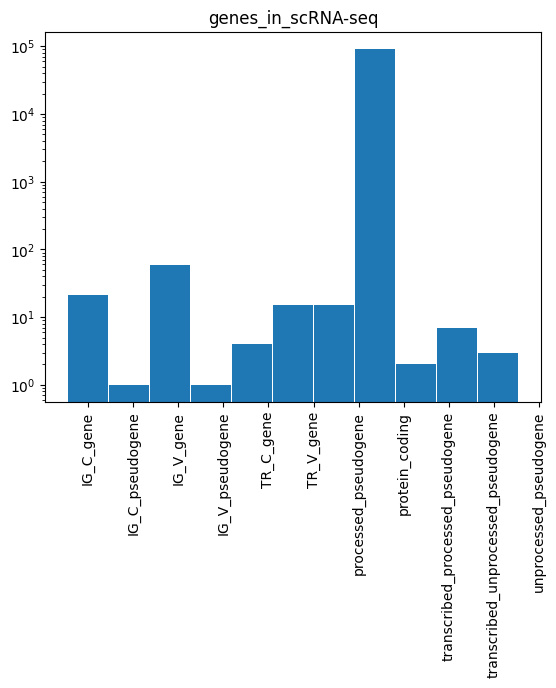

In [40]:
t=rna_gene_data[rna_gene_data.in_pcnet].sort_values('gene_biotype')
plt.hist(t.gene_biotype,align='left',width=0.9,bins=len(set(t.gene_biotype)))
plt.xticks(rotation=90)
plt.title('genes_in_scRNA-seq')
plt.yscale('log')

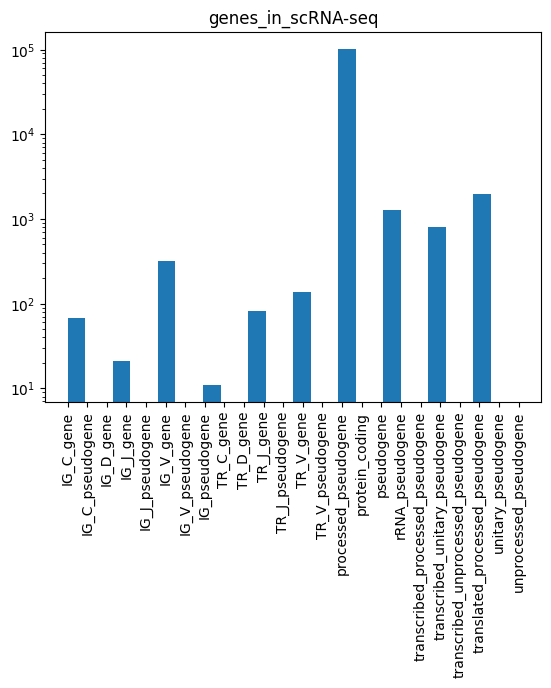

In [41]:
t=rna_gene_data.sort_values('gene_biotype')
plt.hist(t.gene_biotype,align='mid',width=0.9)
plt.xticks(rotation=90)
plt.title('genes_in_scRNA-seq')
plt.yscale('log')

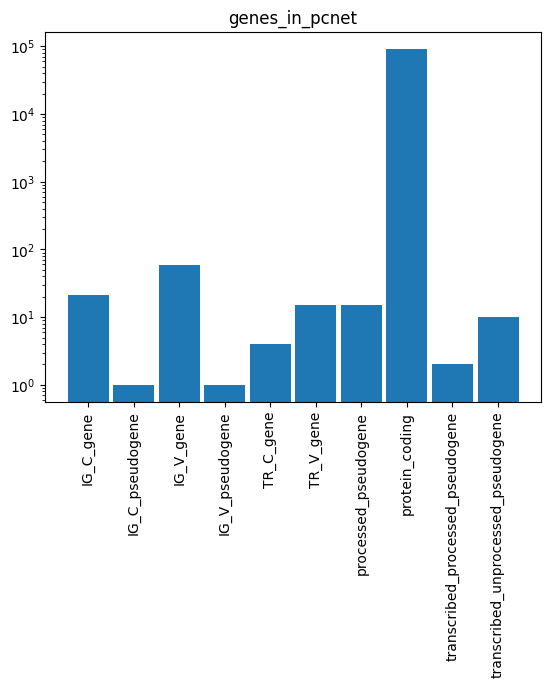

In [42]:
t=rna_gene_data[rna_gene_data.in_pcnet].sort_values('gene_biotype')
plt.hist(t.gene_biotype,align='left',rwidth=0.9)
plt.xticks(rotation=90)
plt.title('genes_in_pcnet')
plt.yscale('log')


Text(0.5, 1.0, 'genes_not_in_pcnet')

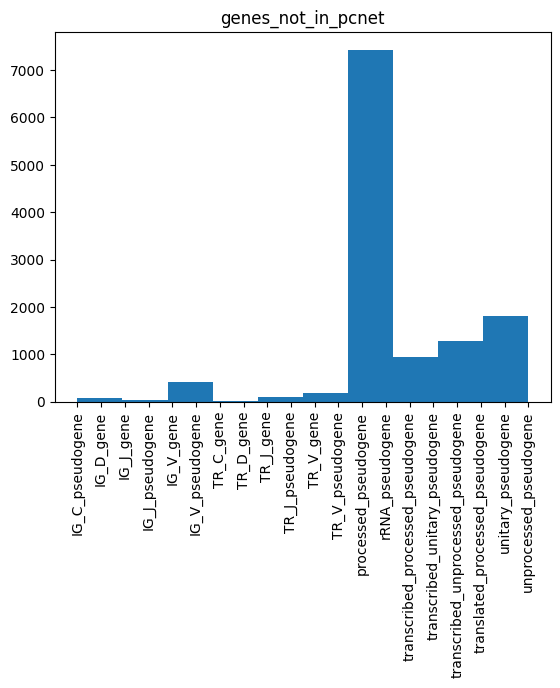

In [43]:
t=rna_data[(rna_data.gene.isin(rna_mini[(~rna_mini['prot_cod'])].index))& (~rna_data.in_pcnet)].sort_values('gene_biotype')
plt.hist(t.gene_biotype)
plt.xticks(rotation=90)
plt.title('genes_not_in_pcnet')

In [44]:
t

gene            gene_biotype      transcript_biotype  \
189849  ENSG00000254017.1         IG_C_pseudogene         IG_C_pseudogene   
189850  ENSG00000253692.3         IG_C_pseudogene         IG_C_pseudogene   
189847  ENSG00000254030.1         IG_C_pseudogene         IG_C_pseudogene   
189845  ENSG00000282094.1         IG_C_pseudogene         IG_C_pseudogene   
189844  ENSG00000281947.1         IG_C_pseudogene         IG_C_pseudogene   
...                   ...                     ...                     ...   
204285  ENSG00000251686.1  unprocessed_pseudogene  unprocessed_pseudogene   
204286  ENSG00000249197.1  unprocessed_pseudogene  unprocessed_pseudogene   
204287  ENSG00000234379.1  unprocessed_pseudogene  unprocessed_pseudogene   
204251  ENSG00000228024.1  unprocessed_pseudogene  unprocessed_pseudogene   
202082  ENSG00000227915.1  unprocessed_pseudogene  unprocessed_pseudogene   

       gene_symbol                                        description  \
189849      IGHEP2  immunoglobulin heavy constant epsilon P2 (pseu...   
189850      IGHEP1  immunoglobulin heavy constant epsilon P1 (pseu...   
189847       IGLC5  immunoglobulin lambda constant 5 (pseudogene) ...   
189845       IGHGP  immunoglobulin heavy constant gamma P (non-fun...   
189844      IGHEP1  immunoglobulin heavy constant epsilon P1 (pseu...   
...            ...                                                ...   
204285     OR10J8P  olfactory receptor family 10 subfamily J membe...   
204286     OR10J9P  olfactory receptor family 10 subfamily J membe...   
204287    HMGB1P48    high mobility group box 1 pseudogene 48 [Source   
204251     CYP1D1P  cytochrome P450 family 1 subfamily D member 1,...   
202082     ELOCP16                    elongin C pseudogene 16 [Source   

                       id  type                                 locus  \
189849  ENST00000519308.1  cdna            GRCh38:9:5113549:5114804:1   
189850  ENST00000521393.1  cdna      GRCh38:14:105721794:105722527:-1   
189847  ENST00000519670.1  cdna         GRCh38:22:22915635:22915927:1   
189845  ENST00000632276.1  cdna  Ch38:HSCHR14_3_CTG1:132402:137612:-1   
189844  ENST00000632557.1  cdna  Ch38:HSCHR14_3_CTG1:189563:190296:-1   
...                   ...   ...                                   ...   
204285  ENST00000504659.1  cdna        GRCh38:1:159366161:159367089:1   
204286  ENST00000511932.1  cdna       GRCh38:1:159405423:159406409:-1   
204287  ENST00000446155.1  cdna          GRCh38:1:45530927:45532139:1   
204251  ENST00000416662.1  cdna          GRCh38:9:73042745:73056528:1   
202082  ENST00000444494.1  cdna          GRCh38:Y:23678504:23678835:1   

        in_pcnet  
189849     False  
189850     False  
189847     False  
189845     False  
189844     False  
...          ...  
204285     False  
204286     False  
204287     False  
204251     False  
202082     False  

[12245 rows x 9 columns]

Text(0.5, 1.0, 'non_protein_coding_genes_in_pcnet')

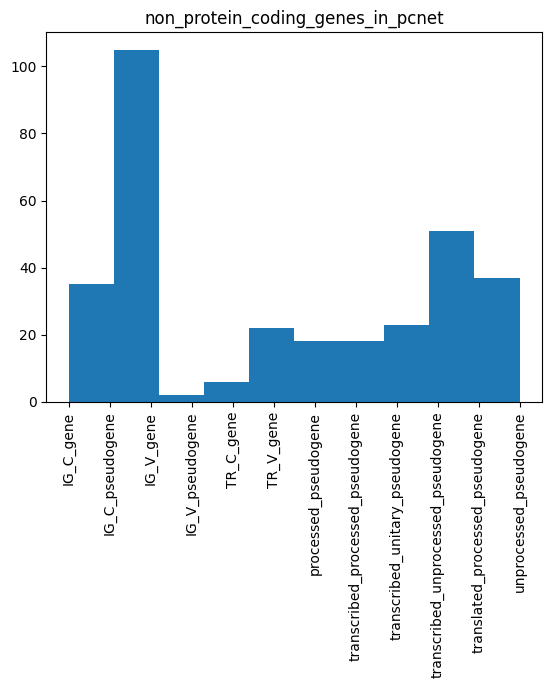

In [45]:
t=rna_data[(rna_data.gene.isin(rna_mini[(~rna_mini['prot_cod'])].index))& (rna_data.in_pcnet)].sort_values('gene_biotype')
plt.hist(t.gene_biotype)
plt.xticks(rotation=90)
plt.title('non_protein_coding_genes_in_pcnet')

In [ ]:
for gene in set(rna_data[rna_data.gene_symbol.isin(pcnet_nodes)].dropna().gene):
    #print(gene)
    t='protein_coding' in set(rna_data[rna_data.gene==gene].gene_biotype)
    if not t:
        print(gene)
        print(set(rna_data[rna_data.gene==gene].gene_symbol))
        print(set(rna_data[rna_data.gene==gene].gene_biotype))

ENSG00000264204.2
{'AGAP7P'}
{'transcribed_unprocessed_pseudogene'}
ENSG00000104970.12
{'KIR3DX1'}
{'transcribed_unprocessed_pseudogene'}
ENSG00000278801.3
{'IGHD'}
{'IG_C_gene'}
ENSG00000277633.5
{'IGHG1'}
{'IG_C_gene'}
ENSG00000211662.2
{'IGLV3-21'}
{'IG_V_gene'}
ENSG00000205361.10
{'MT1DP'}
{'transcribed_unprocessed_pseudogene'}
ENSG00000188707.8
{'ZBED10P'}
{'transcribed_unitary_pseudogene'}
ENSG00000276616.2
{'DUX4L9'}
{'unprocessed_pseudogene'}
ENSG00000211751.9
{'TRBC1'}
{'TR_C_gene'}
ENSG00000255185.7
{'PDXDC2P'}
{'transcribed_unprocessed_pseudogene'}
ENSG00000241351.3
{'IGKV3-11'}
{'IG_V_gene'}
ENSG00000226896.2
{'OR2I1P'}
{'unprocessed_pseudogene'}
ENSG00000283184.1
{'DUX4L9'}
{'unprocessed_pseudogene'}
ENSG00000281978.1
{'IGKV1-17'}
{'IG_V_gene'}
ENSG00000239571.1
{'IGKV2D-30'}
{'IG_V_gene'}
ENSG00000242076.3
{'IGKV1-33'}
{'IG_V_gene'}
ENSG00000282621.1
{'TRBV19'}
{'TR_V_gene'}
ENSG00000282642.1
{'IGHV3-33'}
{'IG_V_gene'}
ENSG00000282579.1
{'IGHV4-39'}
{'IG_V_gene'}
ENSG0000

## scRNA-seq data

In [17]:
#import data that's already collected in single table
data_dict={}
for roi in roi_list:
    print('reading dataset')
    if roi!='Cerebral cortex':
        for m in metric:
            data_dict[f'{roi}_{m}']=pd.read_csv(f'{data_dir}{roi}_pseudobulk_{m}.csv',index_col='Accession')
            

reading dataset
reading dataset
reading dataset
reading dataset
reading dataset
reading dataset
reading dataset
reading dataset
reading dataset
reading dataset


In [18]:
#import in cerebral cortex tissue
cerebral_prefix=glob.glob(f"{data_dir}Cerebral-cortex*_pseudobulk_mean.csv")
cerebral_prefix=[x[20:len(x)-20] for x in cerebral_prefix]

roi='Cerebral cortex'
for c in cerebral_prefix:
    for m in metric:  
        t=(pd.read_csv(f'{data_dir}{c}_pseudobulk_{m}.csv',index_col=0))
        t.columns=[c]
        if f'{roi}_{m}' in data_dict.keys():
            data_dict[f'{roi}_{m}']=data_dict[f'{roi}_{m}'].merge(t,left_index=True, right_index=True, how='outer')
        else:
            data_dict[f'{roi}_{m}']=t

In [19]:
#filter out low count tissues based on cellxgene
for roi in roi_list:
    for m in metric:  
        data_dict[f'{roi}_{m}'][data_dict[f'{roi}_count']<=3]=np.nan
        data_dict[f'{roi}_{m}']=data_dict[f'{roi}_{m}'].dropna(axis=1)
    data_dict[f'{roi}_mean'].replace(0,np.nan,inplace=True)


# calculate marker genes

In [20]:
recalculate_stats=True
save_stat_dict=True

In [21]:
def welch_ttest(m1,s1,n1,m2,s2,n2):
        #t-statistic
        #t=(m1-m2)/np.sqrt(np.square(s1)/n1+np.square(s2)/n2)
        #dof=np.square(np.square(s1)/n1+np.square(s2)/n2)/(np.square(np.square(s1)/n1)/(n1-1) + np.square(np.square(s2)/n2)/(n2-1))
        t,pval=stats.ttest_ind_from_stats(m1, s1, n1, m2, s2, n2, equal_var=False)
        #cohen_d
        effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))
        return t,pval,effect_size

In [22]:
#calculate comparative stats
stat_dict={}
stat_outlist=['pval','effect_size','t','tissues_comp']
if recalculate_stats:
    print('recalculating stats')
    for roi in roi_list:
        print(f'analyzing {roi}')
        accession_list=list(data_dict[f'{roi}_{m}'].index)
        region=data_dict[f'{roi}_mean'].columns
        region=[x[len(roi)+1:] for x in region]
        for stat in stat_outlist:
            stat_dict[f'{roi}_{stat}']=pd.DataFrame(index=accession_list)
            for r1 in region:
                stat_dict[f'{roi}_{stat}'][r1]=[[] for _ in range(len(accession_list))]
        for r1 in region:
            region_comp = [x for x in region if x != r1]
            if 'oligodendrocyte' in r1.lower():
                region_comp=[x for x in region if not 'oligodendrocyte' in x.lower()]
            #start loop over region
            for r2 in region_comp:
                print(f'comparing {r1} to {r2}')
                #loop over all genes
                for a in accession_list:
                    m1=data_dict[f'{roi}_mean'][f"{roi.replace(' ','-')}_{r1}"][a]
                    s1=data_dict[f'{roi}_stdev'][f"{roi.replace(' ','-')}_{r1}"][a]
                    n1=data_dict[f'{roi}_count_nonzero'][f"{roi.replace(' ','-')}_{r1}"][a]
                    
                    m2=data_dict[f'{roi}_mean'][f"{roi.replace(' ','-')}_{r2}"][a]
                    s2=data_dict[f'{roi}_stdev'][f"{roi.replace(' ','-')}_{r2}"][a]
                    n2=data_dict[f'{roi}_count_nonzero'][f"{roi.replace(' ','-')}_{r2}"][a]
        
                    t,pval,effect_size=welch_ttest(m1,s1,n1,m2,s2,n2)
                    stat_dict[f'{roi}_pval'].loc[a,r1].append(pval)
                    stat_dict[f'{roi}_effect_size'].loc[a,r1].append(effect_size)
                    stat_dict[f'{roi}_t'].loc[a,r1].append(t)
                    stat_dict[f'{roi}_tissues_comp'].loc[a,r1].append(r2)
        print(f'calculating marker score for {roi}')
        stat_dict[f'{roi}_marker_score']=stat_dict[f'{roi}_effect_size'].applymap(lambda x: np.nanpercentile(x,10))
    if save_stat_dict:
        for roi in roi_list:
            for stat in stat_outlist+['marker_score']:
                print(f'writing {roi}_{stat} to file')
                stat_dict[f'{roi}_{stat}'].to_csv(f'scRNA_seq/processed/markergene_intermediates/{roi}_pseudobulk_{stat}.csv')
else:
    print('reading stats in from file')
    for roi in roi_list:
        print(f'reading {roi}')
        for stat in stat_outlist+['marker_score']:
            print(f'\treading {stat}')
            stat_dict[f'{roi}_{stat}']=pd.read_csv(f'scRNA_seq/processed/markergene_intermediates/{roi}_pseudobulk_{stat}.csv',index_col=0,na_values=["na"])
            

recalculating stats
analyzing Epithalamus
comparing Astrocyte to Committed-oligodendrocyte-precursor


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encountered in double_scalars
  vn2 = v2 / n2
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6346: RuntimeWarning: invalid value encountered in double_scalars
  vn1 = v1 / n1
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: invalid value encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Astrocyte to Ependymal
comparing Astrocyte to Fibroblast
comparing Astrocyte to Microglia
comparing Astrocyte to Neuron
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Oligodendrocyte-precursor
comparing Astrocyte to Vascular
comparing Committed-oligodendrocyte-precursor to Astrocyte
comparing Committed-oligodendrocyte-precursor to Ependymal
comparing Committed-oligodendrocyte-precursor to Fibroblast
comparing Committed-oligodendrocyte-precursor to Microglia
comparing Committed-oligodendrocyte-precursor to Neuron
comparing Committed-oligodendrocyte-precursor to Vascular
comparing Ependymal to Astrocyte
comparing Ependymal to Committed-oligodendrocyte-precursor
comparing Ependymal to Fibroblast
comparing Ependymal to Microglia
comparing Ependymal to Neuron
comparing Ependymal to Oligodendrocyte
comparing Ependymal to Oligodendrocyte-precursor
comparing Ependymal to Vascular
comparing Fibroblast to Astrocyte
comparing Fibroblast to Committed-oligodendrocyte-precur

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4530: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)


analyzing Hindbrain
comparing Astrocyte to Bergmann-glia


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encountered in double_scalars
  vn2 = v2 / n2
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6346: RuntimeWarning: invalid value encountered in double_scalars
  vn1 = v1 / n1
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: invalid value encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Astrocyte to Choroid-plexus
comparing Astrocyte to Committed-oligodendrocyte-precursor
comparing Astrocyte to Ependymal
comparing Astrocyte to Fibroblast
comparing Astrocyte to Microglia
comparing Astrocyte to Neuron
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Oligodendrocyte-precursor
comparing Astrocyte to Vascular
comparing Bergmann-glia to Astrocyte
comparing Bergmann-glia to Choroid-plexus
comparing Bergmann-glia to Committed-oligodendrocyte-precursor
comparing Bergmann-glia to Ependymal
comparing Bergmann-glia to Fibroblast
comparing Bergmann-glia to Microglia
comparing Bergmann-glia to Neuron
comparing Bergmann-glia to Oligodendrocyte
comparing Bergmann-glia to Oligodendrocyte-precursor
comparing Bergmann-glia to Vascular
comparing Choroid-plexus to Astrocyte
comparing Choroid-plexus to Bergmann-glia
comparing Choroid-plexus to Committed-oligodendrocyte-precursor
comparing Choroid-plexus to Ependymal
comparing Choroid-plexus to Fibroblast
comparing Ch

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4530: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)


analyzing Hippocampus
comparing Astrocyte to Choroid-plexus


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encountered in double_scalars
  vn2 = v2 / n2
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6346: RuntimeWarning: invalid value encountered in double_scalars
  vn1 = v1 / n1
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: invalid value encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Astrocyte to Committed-oligodendrocyte-precursor
comparing Astrocyte to Ependymal
comparing Astrocyte to Fibroblast
comparing Astrocyte to Microglia
comparing Astrocyte to Neuron
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Oligodendrocyte-precursor
comparing Astrocyte to Vascular
comparing Choroid-plexus to Astrocyte
comparing Choroid-plexus to Committed-oligodendrocyte-precursor
comparing Choroid-plexus to Ependymal
comparing Choroid-plexus to Fibroblast
comparing Choroid-plexus to Microglia
comparing Choroid-plexus to Neuron
comparing Choroid-plexus to Oligodendrocyte
comparing Choroid-plexus to Oligodendrocyte-precursor
comparing Choroid-plexus to Vascular
comparing Committed-oligodendrocyte-precursor to Astrocyte
comparing Committed-oligodendrocyte-precursor to Choroid-plexus
comparing Committed-oligodendrocyte-precursor to Ependymal
comparing Committed-oligodendrocyte-precursor to Fibroblast
comparing Committed-oligodendrocyte-precursor to Microglia
com

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


analyzing Hypothalamus
comparing Astrocyte to Committed-oligodendrocyte-precursor


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encountered in double_scalars
  vn2 = v2 / n2
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6346: RuntimeWarning: invalid value encountered in double_scalars
  vn1 = v1 / n1
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: invalid value encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Astrocyte to Ependymal
comparing Astrocyte to Fibroblast
comparing Astrocyte to Microglia
comparing Astrocyte to Neuron
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Oligodendrocyte-precursor
comparing Astrocyte to Vascular
comparing Committed-oligodendrocyte-precursor to Astrocyte
comparing Committed-oligodendrocyte-precursor to Ependymal
comparing Committed-oligodendrocyte-precursor to Fibroblast
comparing Committed-oligodendrocyte-precursor to Microglia
comparing Committed-oligodendrocyte-precursor to Neuron
comparing Committed-oligodendrocyte-precursor to Vascular
comparing Ependymal to Astrocyte
comparing Ependymal to Committed-oligodendrocyte-precursor
comparing Ependymal to Fibroblast
comparing Ependymal to Microglia
comparing Ependymal to Neuron
comparing Ependymal to Oligodendrocyte
comparing Ependymal to Oligodendrocyte-precursor
comparing Ependymal to Vascular
comparing Fibroblast to Astrocyte
comparing Fibroblast to Committed-oligodendrocyte-precur

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


analyzing Midbrain
comparing Astrocyte to Bergmann-glia


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encountered in double_scalars
  vn2 = v2 / n2
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: invalid value encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6346: RuntimeWarning: invalid value encountered in double_scalars
  vn1 = v1 / n1
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Astrocyte to Committed-oligodendrocyte-precursor
comparing Astrocyte to Ependymal
comparing Astrocyte to Fibroblast
comparing Astrocyte to Microglia
comparing Astrocyte to Neuron
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Oligodendrocyte-precursor
comparing Astrocyte to Vascular
comparing Bergmann-glia to Astrocyte
comparing Bergmann-glia to Committed-oligodendrocyte-precursor
comparing Bergmann-glia to Ependymal
comparing Bergmann-glia to Fibroblast
comparing Bergmann-glia to Microglia
comparing Bergmann-glia to Neuron
comparing Bergmann-glia to Oligodendrocyte
comparing Bergmann-glia to Oligodendrocyte-precursor
comparing Bergmann-glia to Vascular
comparing Committed-oligodendrocyte-precursor to Astrocyte
comparing Committed-oligodendrocyte-precursor to Bergmann-glia
comparing Committed-oligodendrocyte-precursor to Ependymal
comparing Committed-oligodendrocyte-precursor to Fibroblast
comparing Committed-oligodendrocyte-precursor to Microglia
comparing Com

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


analyzing Paleocortex
comparing Astrocyte to Committed-oligodendrocyte-precursor


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encountered in double_scalars
  vn2 = v2 / n2
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: invalid value encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6346: RuntimeWarning: invalid value encountered in double_scalars
  vn1 = v1 / n1
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Astrocyte to Microglia
comparing Astrocyte to Neuron
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Oligodendrocyte-precursor
comparing Committed-oligodendrocyte-precursor to Astrocyte
comparing Committed-oligodendrocyte-precursor to Microglia
comparing Committed-oligodendrocyte-precursor to Neuron
comparing Microglia to Astrocyte
comparing Microglia to Committed-oligodendrocyte-precursor
comparing Microglia to Neuron
comparing Microglia to Oligodendrocyte
comparing Microglia to Oligodendrocyte-precursor
comparing Neuron to Astrocyte
comparing Neuron to Committed-oligodendrocyte-precursor
comparing Neuron to Microglia
comparing Neuron to Oligodendrocyte
comparing Neuron to Oligodendrocyte-precursor
comparing Oligodendrocyte to Astrocyte
comparing Oligodendrocyte to Microglia
comparing Oligodendrocyte to Neuron
comparing Oligodendrocyte-precursor to Astrocyte
comparing Oligodendrocyte-precursor to Microglia
comparing Oligodendrocyte-precursor to Neuron
calculati

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


analyzing Spinal cord
comparing Astrocyte to Bergmann-glia


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6346: RuntimeWarning: invalid value encountered in double_scalars
  vn1 = v1 / n1
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encountered in double_scalars
  vn2 = v2 / n2
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: invalid value encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Astrocyte to Committed-oligodendrocyte-precursor
comparing Astrocyte to Ependymal
comparing Astrocyte to Fibroblast
comparing Astrocyte to Microglia
comparing Astrocyte to Neuron
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Oligodendrocyte-precursor
comparing Astrocyte to Vascular
comparing Bergmann-glia to Astrocyte
comparing Bergmann-glia to Committed-oligodendrocyte-precursor
comparing Bergmann-glia to Ependymal
comparing Bergmann-glia to Fibroblast
comparing Bergmann-glia to Microglia
comparing Bergmann-glia to Neuron
comparing Bergmann-glia to Oligodendrocyte
comparing Bergmann-glia to Oligodendrocyte-precursor
comparing Bergmann-glia to Vascular
comparing Committed-oligodendrocyte-precursor to Astrocyte
comparing Committed-oligodendrocyte-precursor to Bergmann-glia
comparing Committed-oligodendrocyte-precursor to Ependymal
comparing Committed-oligodendrocyte-precursor to Fibroblast
comparing Committed-oligodendrocyte-precursor to Microglia
comparing Com

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


analyzing Thalamus
comparing Astrocyte to Choroid-plexus


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encountered in double_scalars
  vn2 = v2 / n2
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6346: RuntimeWarning: invalid value encountered in double_scalars
  vn1 = v1 / n1
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: invalid value encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Astrocyte to Committed-oligodendrocyte-precursor
comparing Astrocyte to Ependymal
comparing Astrocyte to Fibroblast
comparing Astrocyte to Microglia
comparing Astrocyte to Neuron
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Oligodendrocyte-precursor
comparing Astrocyte to Vascular
comparing Choroid-plexus to Astrocyte
comparing Choroid-plexus to Committed-oligodendrocyte-precursor
comparing Choroid-plexus to Ependymal
comparing Choroid-plexus to Fibroblast
comparing Choroid-plexus to Microglia
comparing Choroid-plexus to Neuron
comparing Choroid-plexus to Oligodendrocyte
comparing Choroid-plexus to Oligodendrocyte-precursor
comparing Choroid-plexus to Vascular
comparing Committed-oligodendrocyte-precursor to Astrocyte
comparing Committed-oligodendrocyte-precursor to Choroid-plexus
comparing Committed-oligodendrocyte-precursor to Ependymal
comparing Committed-oligodendrocyte-precursor to Fibroblast
comparing Committed-oligodendrocyte-precursor to Microglia
com

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4530: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encount

analyzing Cerebral nuclei
comparing Astrocyte to Choroid-plexus


/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Astrocyte to Committed-oligodendrocyte-precursor
comparing Astrocyte to Ependymal
comparing Astrocyte to Fibroblast
comparing Astrocyte to Microglia
comparing Astrocyte to Neuron
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Oligodendrocyte-precursor
comparing Astrocyte to Vascular
comparing Choroid-plexus to Astrocyte
comparing Choroid-plexus to Committed-oligodendrocyte-precursor
comparing Choroid-plexus to Ependymal
comparing Choroid-plexus to Fibroblast
comparing Choroid-plexus to Microglia
comparing Choroid-plexus to Neuron
comparing Choroid-plexus to Oligodendrocyte
comparing Choroid-plexus to Oligodendrocyte-precursor
comparing Choroid-plexus to Vascular
comparing Committed-oligodendrocyte-precursor to Astrocyte
comparing Committed-oligodendrocyte-precursor to Choroid-plexus
comparing Committed-oligodendrocyte-precursor to Ependymal
comparing Committed-oligodendrocyte-precursor to Fibroblast
comparing Committed-oligodendrocyte-precursor to Microglia
com

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4530: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)


analyzing Cerebral cortex
comparing Oligodendrocyte to Neuron


/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6346: RuntimeWarning: invalid value encountered in double_scalars
  vn1 = v1 / n1
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/scipy/stats/_stats_py.py:6347: RuntimeWarning: invalid value encountered in double_scalars
  vn2 = v2 / n2
/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Oligodendrocyte to Fibroblast


/tmp/ipykernel_2908158/46023807.py:7: RuntimeWarning: invalid value encountered in double_scalars
  effect_size=(m1-m2)/(((n1-1)*np.square(s1)+(n2-1)*np.square(s2))/(n1+n2-1))


comparing Oligodendrocyte to Astrocyte
comparing Oligodendrocyte to Vascular
comparing Oligodendrocyte to Microglia
comparing Neuron to Oligodendrocyte
comparing Neuron to Fibroblast
comparing Neuron to Astrocyte
comparing Neuron to Oligodendrocyte-precursor
comparing Neuron to Committed-oligodendrocyte-precursor
comparing Neuron to Vascular
comparing Neuron to Microglia
comparing Fibroblast to Oligodendrocyte
comparing Fibroblast to Neuron
comparing Fibroblast to Astrocyte
comparing Fibroblast to Oligodendrocyte-precursor
comparing Fibroblast to Committed-oligodendrocyte-precursor
comparing Fibroblast to Vascular
comparing Fibroblast to Microglia
comparing Astrocyte to Oligodendrocyte
comparing Astrocyte to Neuron
comparing Astrocyte to Fibroblast
comparing Astrocyte to Oligodendrocyte-precursor
comparing Astrocyte to Committed-oligodendrocyte-precursor
comparing Astrocyte to Vascular
comparing Astrocyte to Microglia
comparing Oligodendrocyte-precursor to Neuron
comparing Oligodendroc

/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4529: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


writing Epithalamus_pval to file
writing Epithalamus_effect_size to file
writing Epithalamus_t to file
writing Epithalamus_tissues_comp to file
writing Epithalamus_marker_score to file
writing Hindbrain_pval to file
writing Hindbrain_effect_size to file
writing Hindbrain_t to file
writing Hindbrain_tissues_comp to file
writing Hindbrain_marker_score to file
writing Hippocampus_pval to file
writing Hippocampus_effect_size to file
writing Hippocampus_t to file
writing Hippocampus_tissues_comp to file
writing Hippocampus_marker_score to file
writing Hypothalamus_pval to file
writing Hypothalamus_effect_size to file
writing Hypothalamus_t to file
writing Hypothalamus_tissues_comp to file
writing Hypothalamus_marker_score to file
writing Midbrain_pval to file
writing Midbrain_effect_size to file
writing Midbrain_t to file
writing Midbrain_tissues_comp to file
writing Midbrain_marker_score to file
writing Paleocortex_pval to file
writing Paleocortex_effect_size to file
writing Paleocortex_t 

In [32]:
marker_genes={}

In [37]:
for roi in roi_list:
    for region in stat_dict[f'{roi}_marker_score'].columns:
        marker_genes[f'{roi}_{region}_marker_genes']=(list(stat_dict[f'{roi}_marker_score'][stat_dict[f'{roi}_marker_score']
                                                        .index.isin(rna_mini.index)].sort_values(region,ascending=False).head(25).index))
        #marker_genes[f'{roi}_{region}_marker_genes']=(list(stat_dict[f'{roi}_marker_score'][stat_dict[f'{roi}_marker_score']
         #                                               .index.isin(rna_mini[rna_mini.prot_cod].index)].sort_values(region,ascending=False).head(25).index))
        

In [34]:
for roi in roi_list:
    for region in stat_dict[f'{roi}_marker_score'].columns:
        marker_genes[f'{roi}_{region}_marker_genes_prot_cod']=(list(stat_dict[f'{roi}_marker_score'][stat_dict[f'{roi}_marker_score']
                                                        .index.isin(rna_mini[rna_mini.prot_cod].index)].sort_values(region,ascending=False).head(50).index))
        #marker_genes[f'{roi}_{region}_marker_genes']=(list(stat_dict[f'{roi}_marker_score'][stat_dict[f'{roi}_marker_score']
         #                                               .index.isin(rna_mini[rna_mini.prot_cod].index)].sort_values(region,ascending=False).head(25).index))
        

In [35]:
rna_pcnet=rna_data[rna_data.gene_symbol.isin(pcnet_nodes)]
rna_protcod=rna_data[rna_data.gene_biotype=='protein_coding']

In [36]:
for key in [k for k in list(marker_genes.keys()) if 'marker_gene' in k]:
    l=len(set(marker_genes[key]).intersection(set(rna_pcnet['gene'])))
    t=set(rna_pcnet[rna_pcnet['gene'].isin(marker_genes[key])]['gene_biotype'])
    print (f'{key}: ({l})\t{t}')

Epithalamus_Astrocyte_marker_genes: (34)	{'transcribed_unprocessed_pseudogene', 'protein_coding'}
Epithalamus_Committed-oligodendrocyte-precursor_marker_genes: (46)	{'protein_coding'}
Epithalamus_Ependymal_marker_genes: (42)	{'protein_coding'}
Epithalamus_Fibroblast_marker_genes: (40)	{'protein_coding'}
Epithalamus_Microglia_marker_genes: (28)	{'protein_coding'}
Epithalamus_Neuron_marker_genes: (46)	{'protein_coding'}
Epithalamus_Oligodendrocyte_marker_genes: (17)	{'protein_coding'}
Epithalamus_Oligodendrocyte-precursor_marker_genes: (26)	{'protein_coding'}
Epithalamus_Vascular_marker_genes: (39)	{'protein_coding'}
Hindbrain_Astrocyte_marker_genes: (9)	{'protein_coding'}
Hindbrain_Bergmann-glia_marker_genes: (5)	{'protein_coding'}
Hindbrain_Choroid-plexus_marker_genes: (15)	{'protein_coding'}
Hindbrain_Committed-oligodendrocyte-precursor_marker_genes: (10)	{'processed_pseudogene', 'protein_coding'}
Hindbrain_Ependymal_marker_genes: (7)	{'protein_coding'}
Hindbrain_Fibroblast_marker_gen

## check the overlap of marker genes

In [62]:
region_list=[]
for roi in roi_list:
    for region in stat_dict[f'{roi}_marker_score'].columns:
        region_list.append(region)
region_list=list(set(region_list))

In [64]:
region_list

['Astrocyte',
 'Microglia',
 'Choroid-plexus',
 'Committed-oligodendrocyte-precursor',
 'Oligodendrocyte-precursor',
 'Bergmann-glia',
 'Oligodendrocyte',
 'Neuron',
 'Fibroblast',
 'Vascular',
 'Ependymal']

### plot all genes

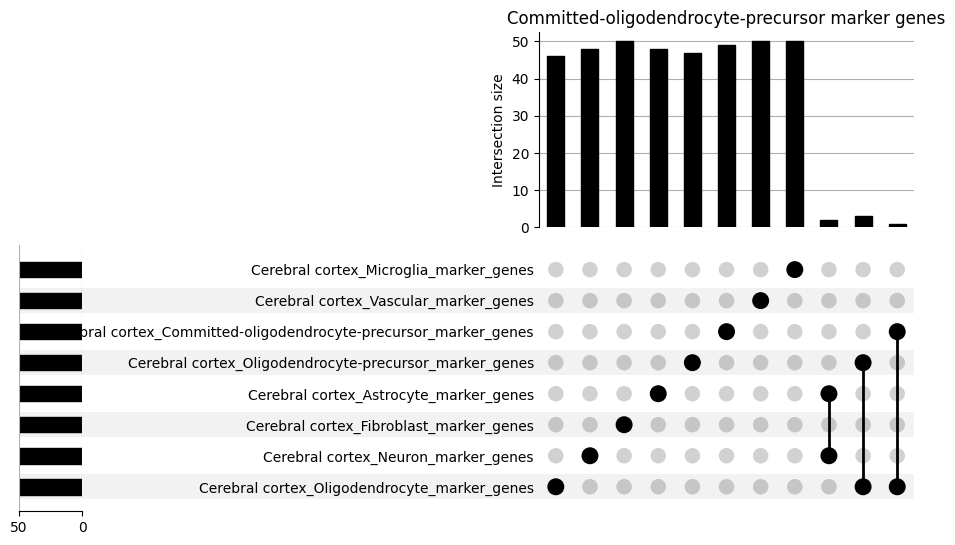

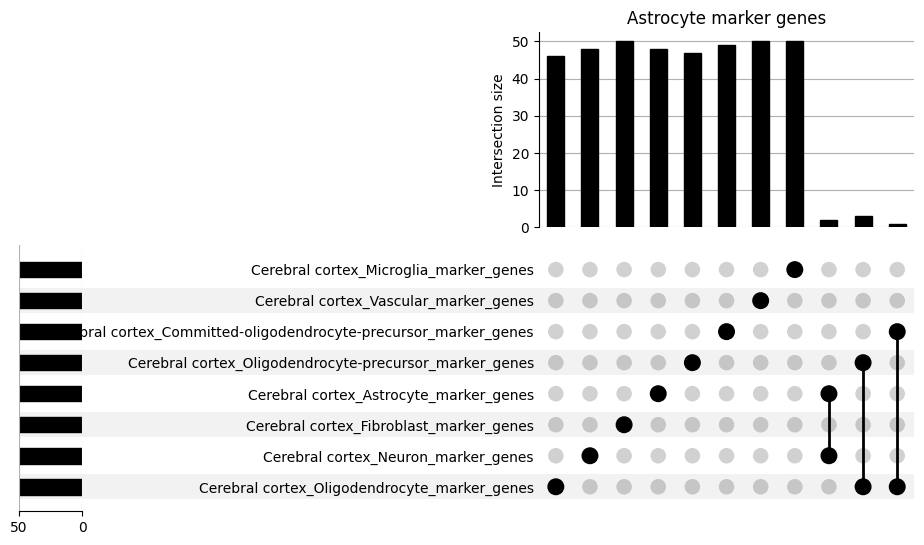

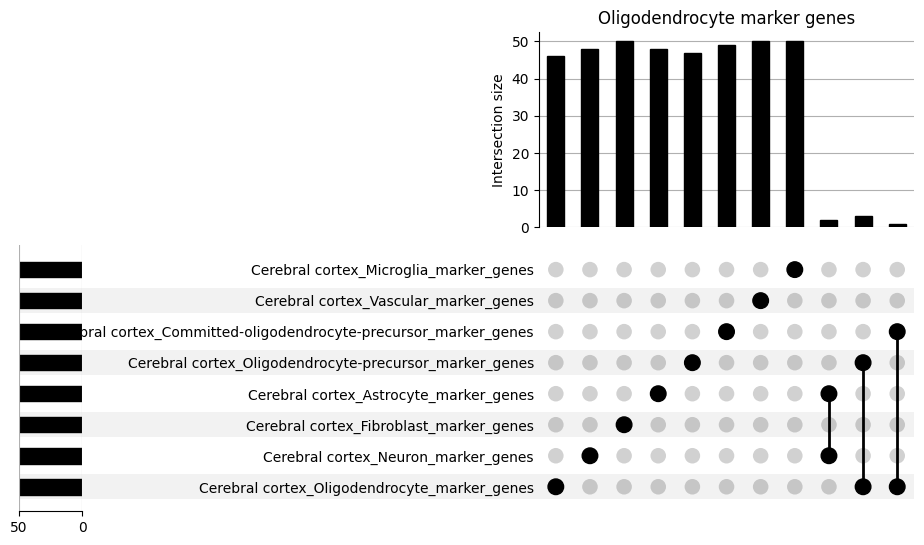

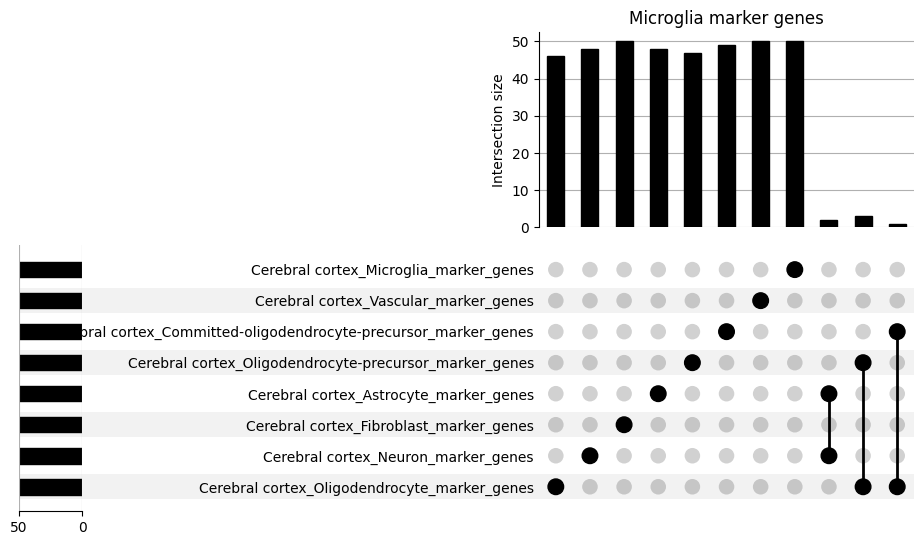

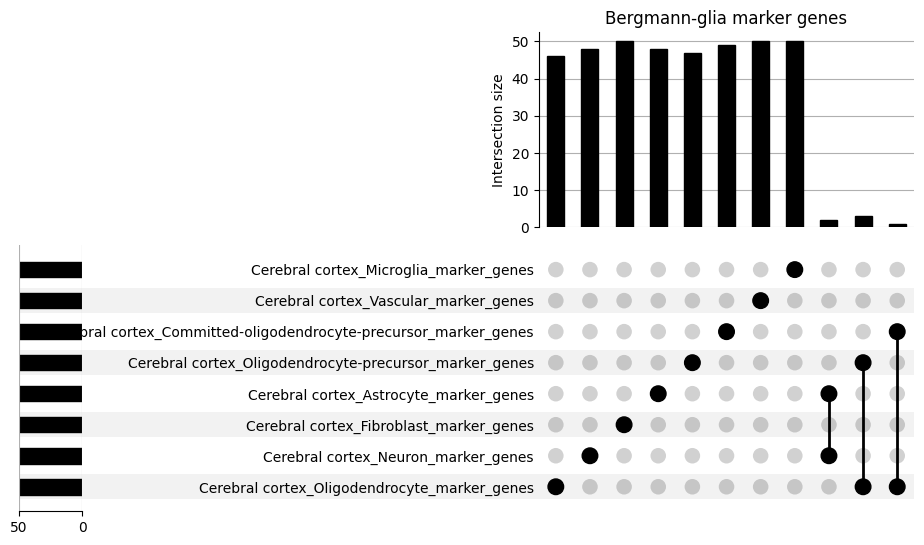

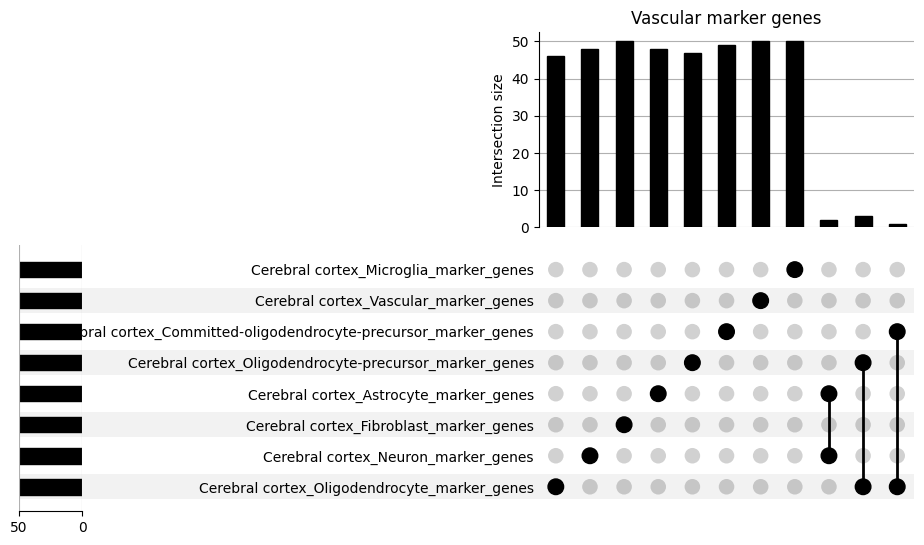

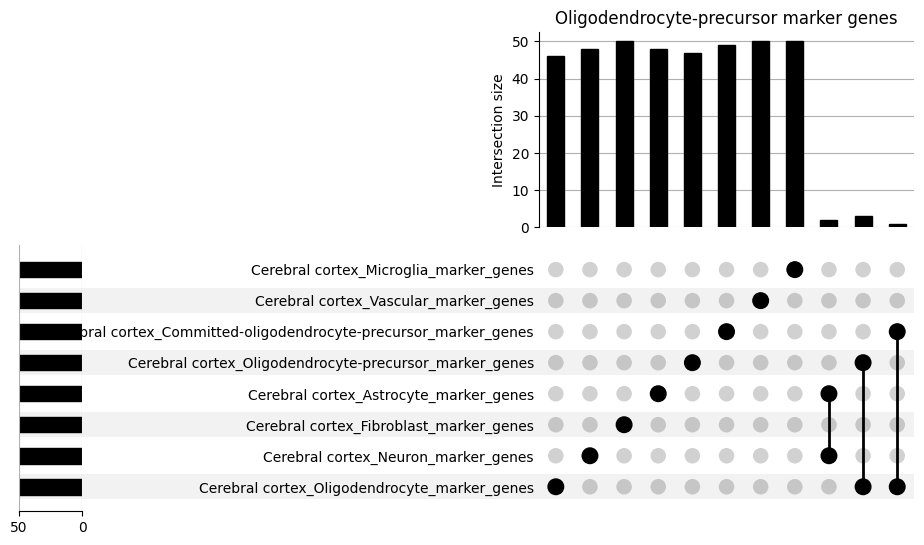

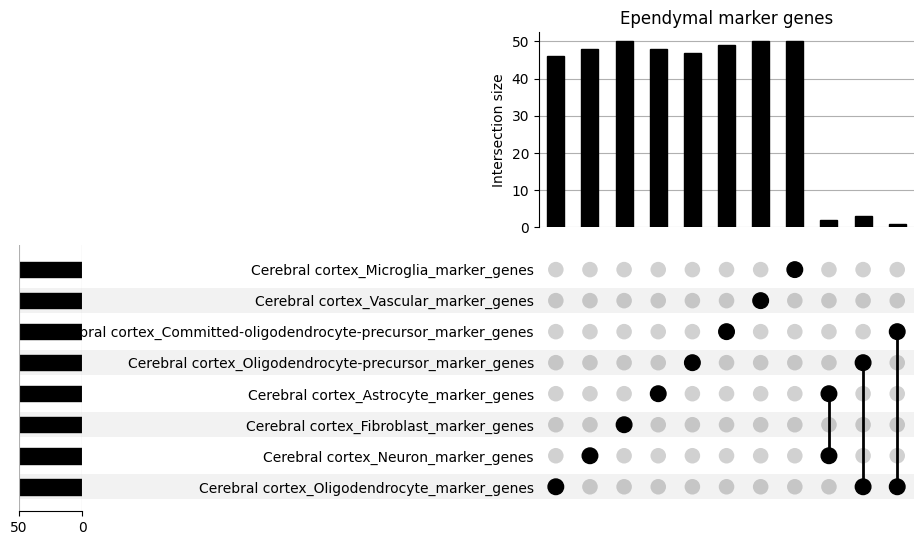

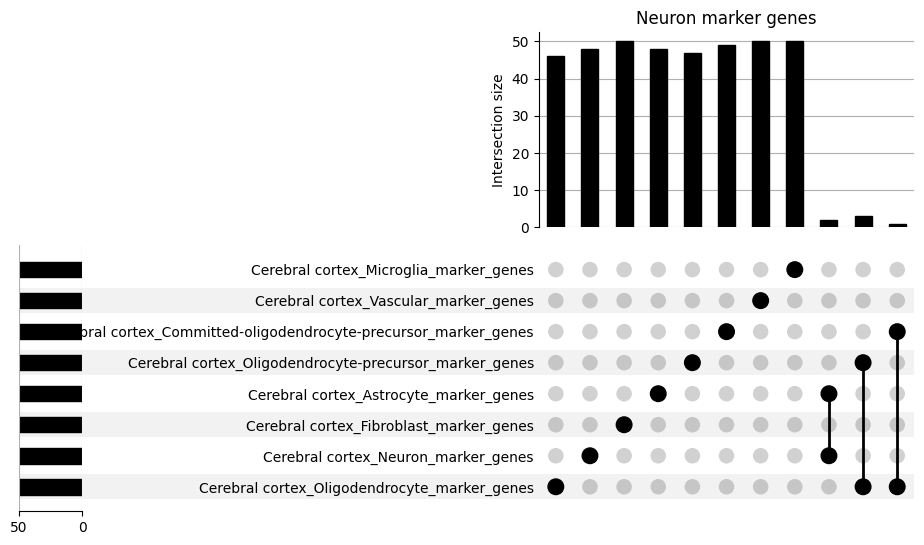

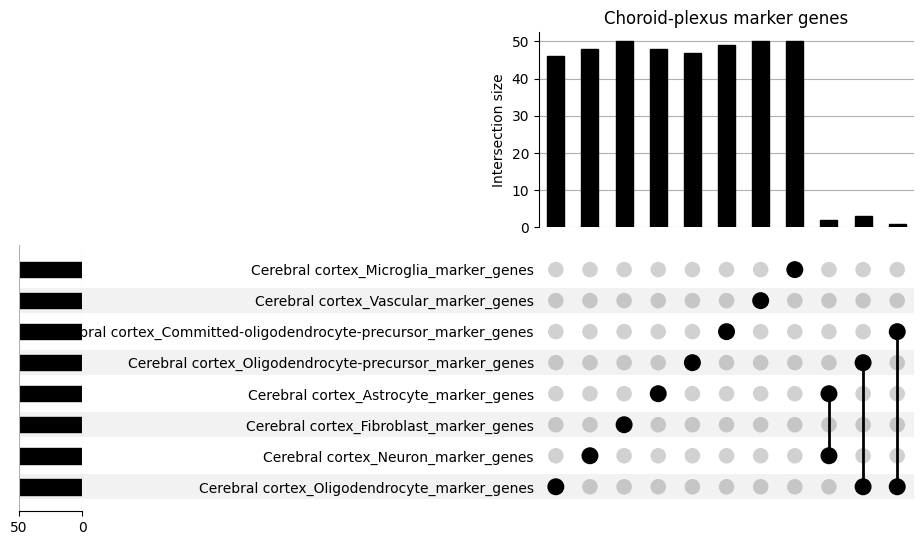

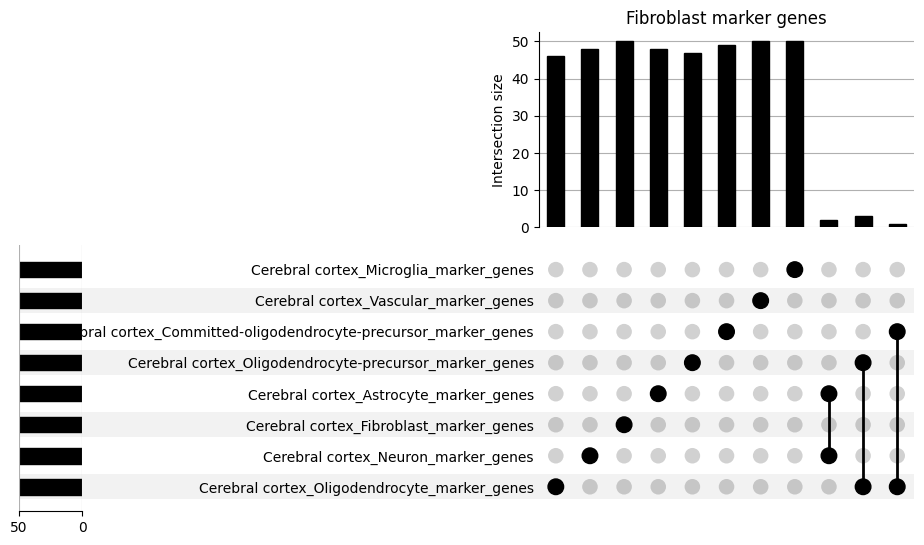

In [127]:
#plot type of gene
for region in region_list:
    keys=[k for k in list(marker_genes.keys()) if ((roi in k)&('prot_cod' not in k))]
    UpSet(from_contents(    {k: marker_genes[k] for k in keys}
), subset_size='count').plot()
    plt.title(f'{region} marker genes')

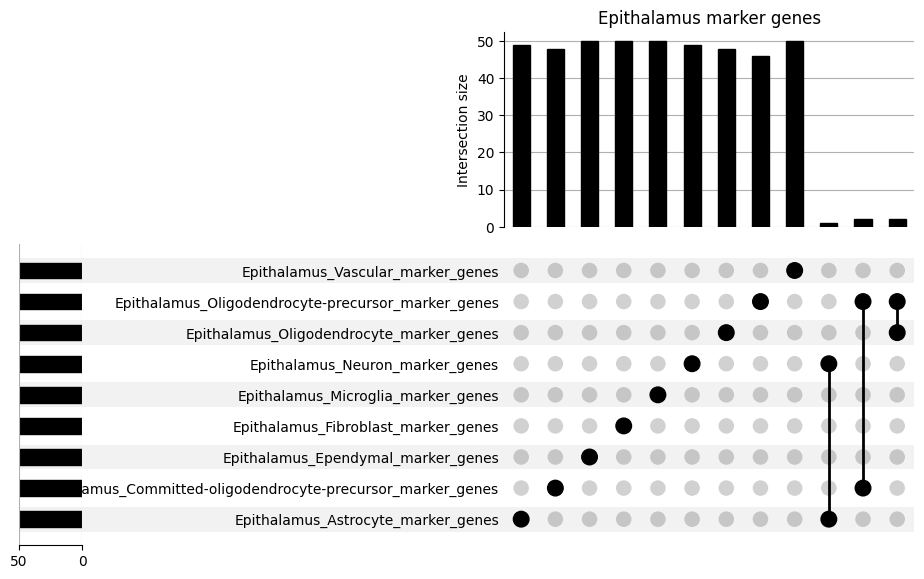

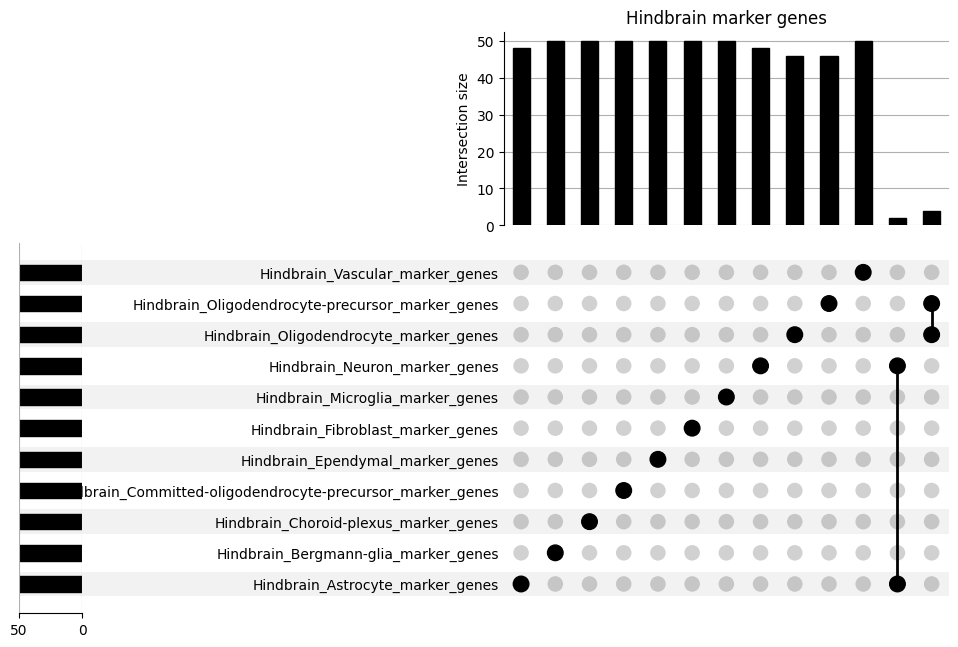

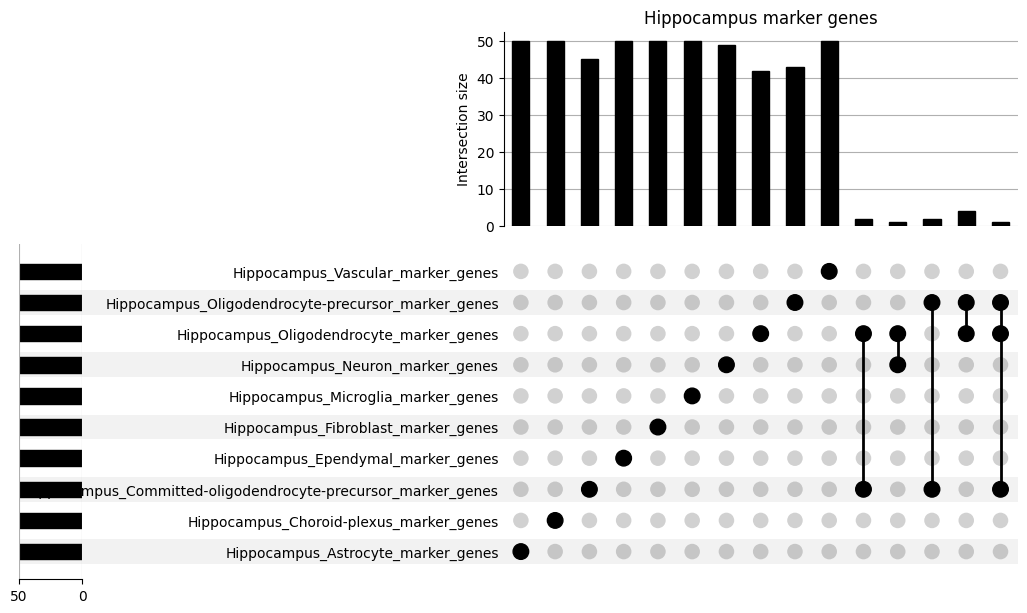

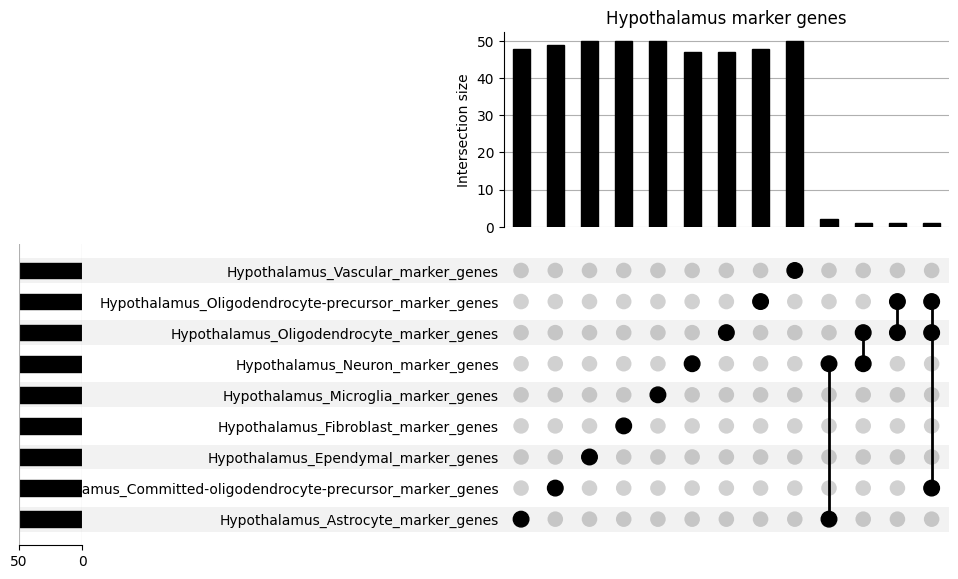

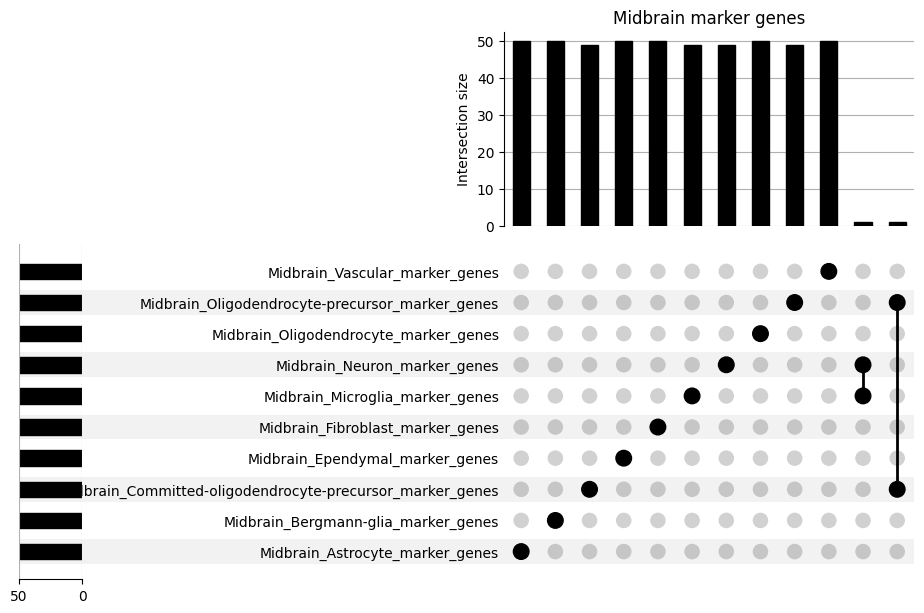

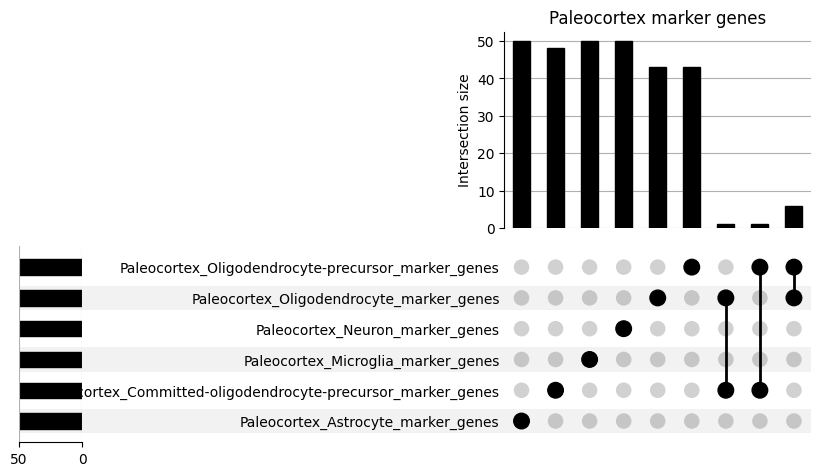

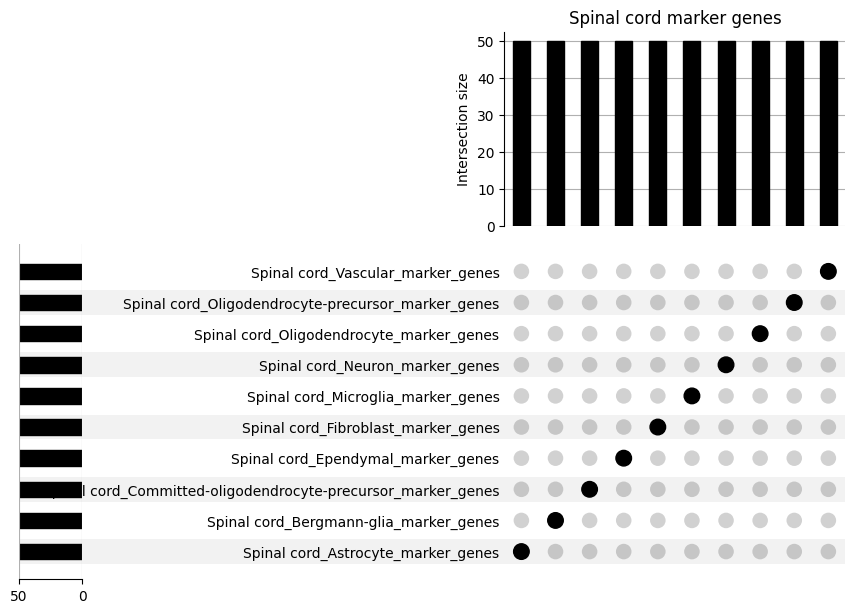

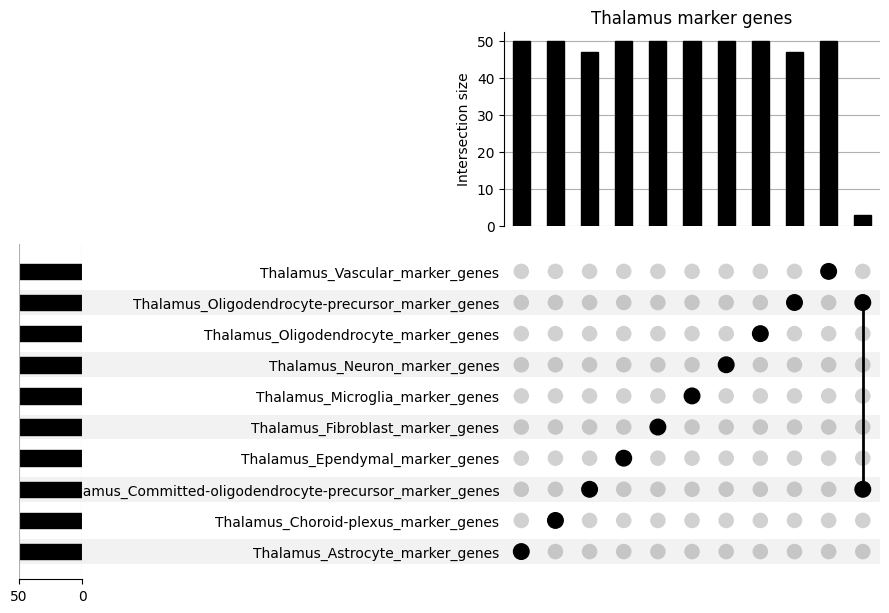

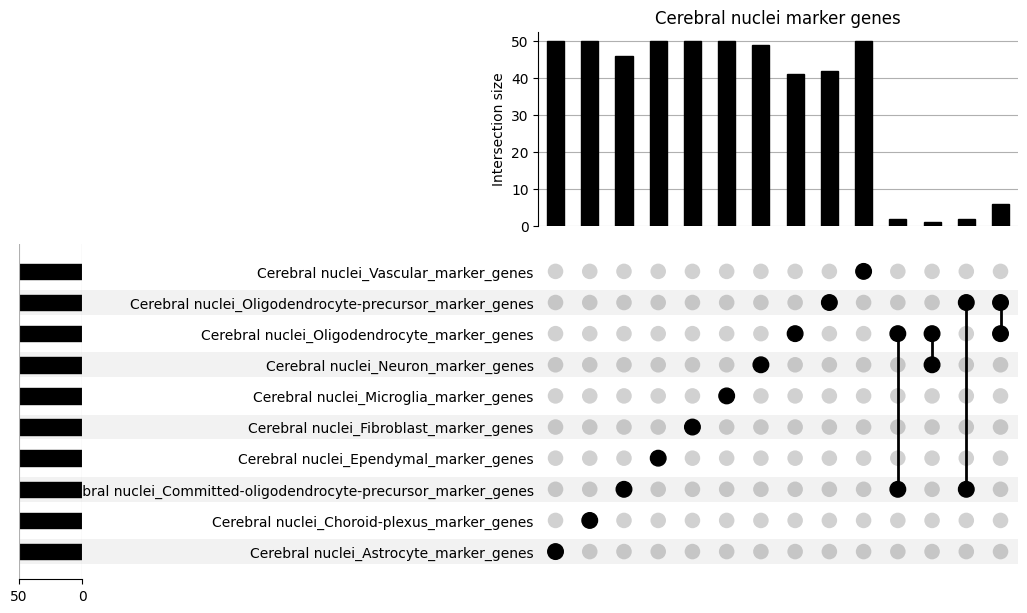

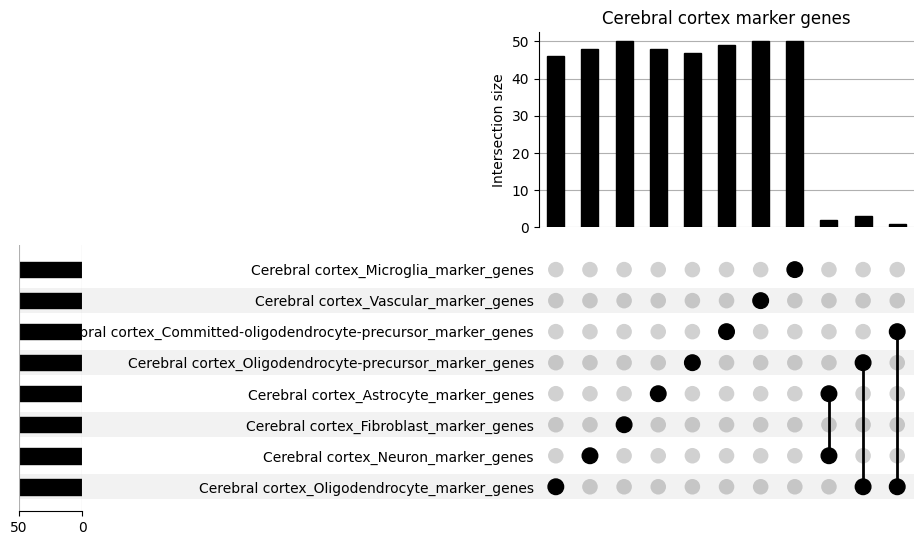

In [106]:
#plot by area of the brain
for roi in roi_list:
    keys=[k for k in list(marker_genes.keys()) if (('marker_gene' in k)&(roi in k)&('prot_cod' not in k))]
    UpSet(from_contents(    {k: marker_genes[k] for k in keys}
), subset_size='count').plot()
    plt.title(f'{roi} marker genes')

### plot protein coding

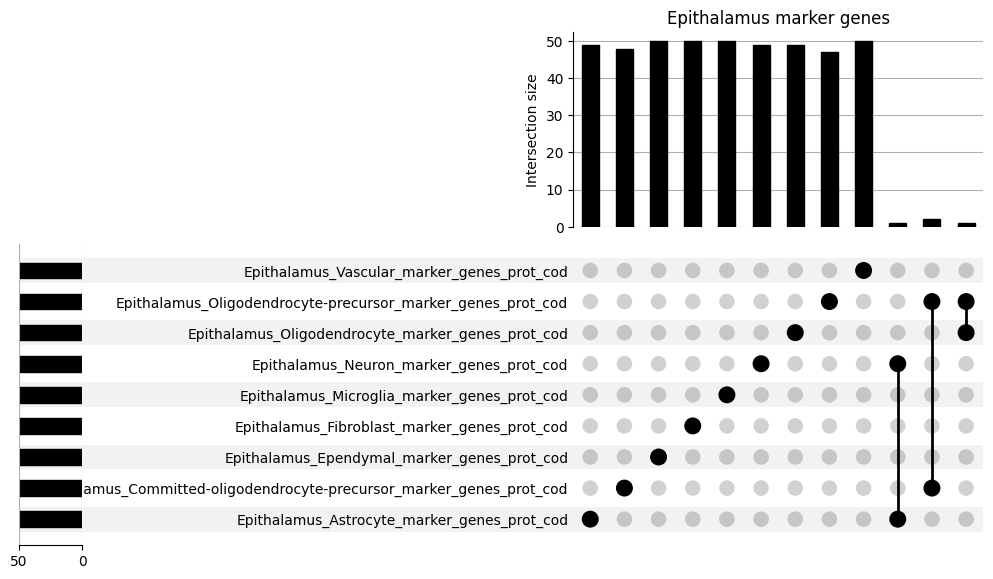

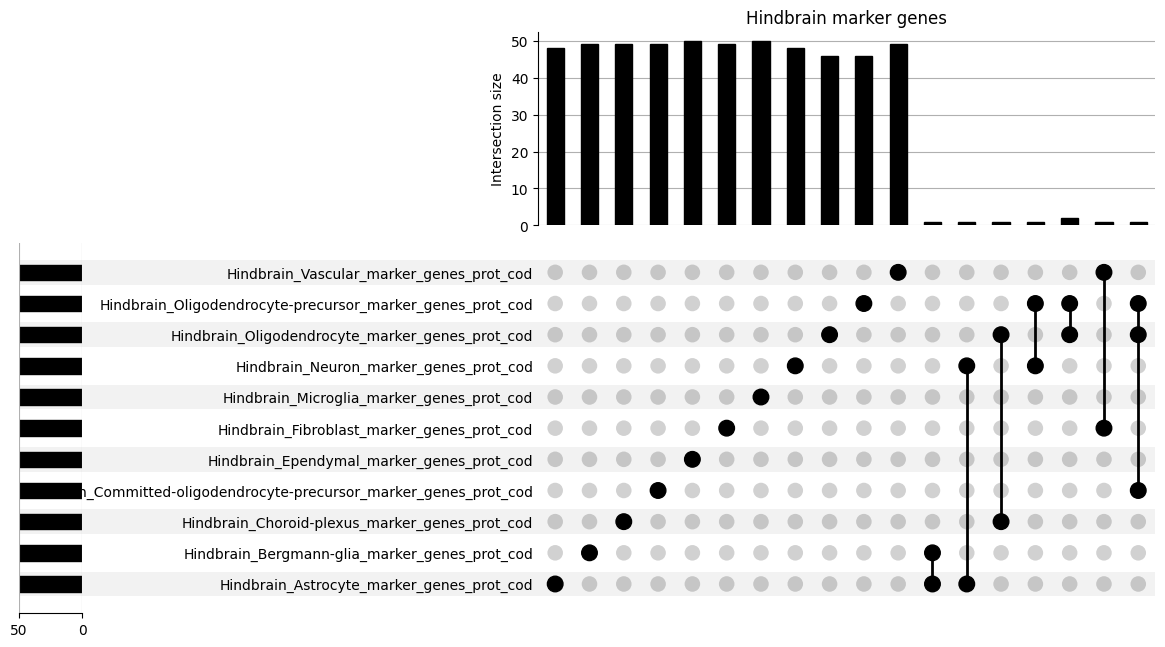

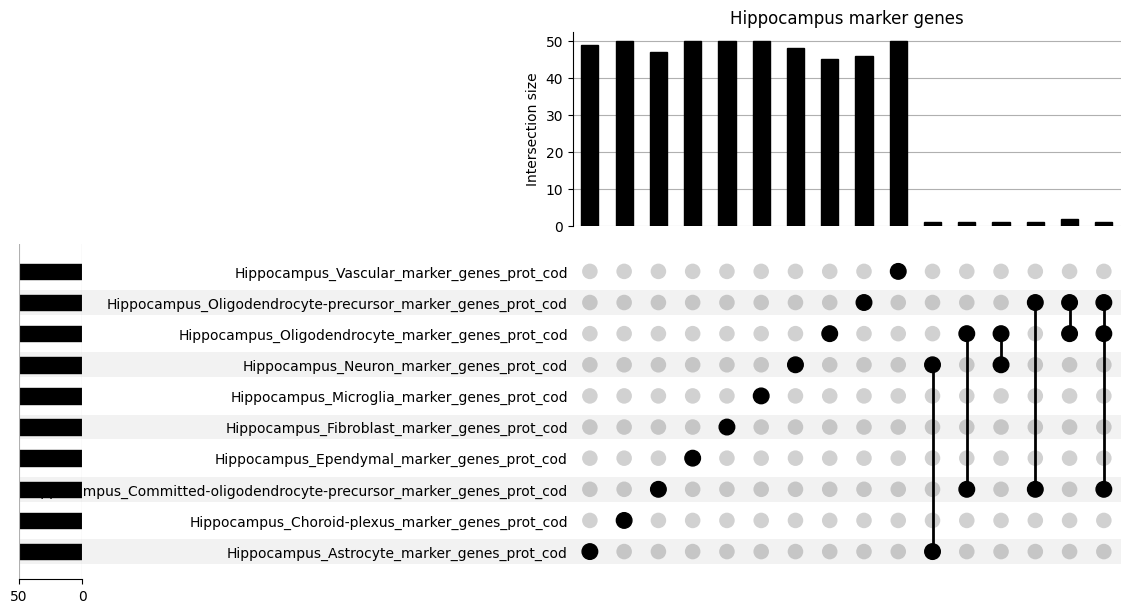

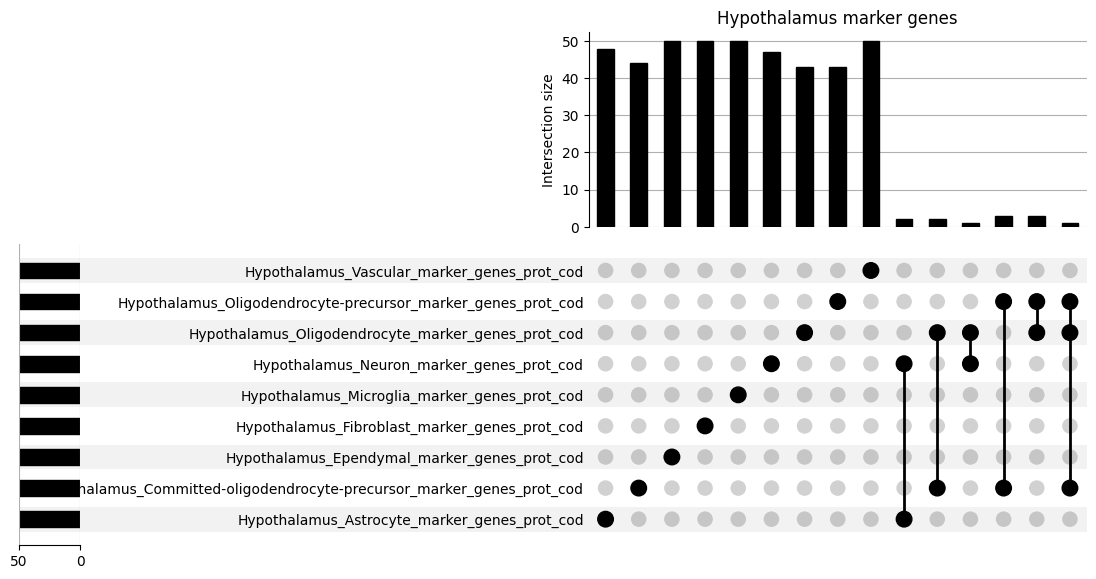

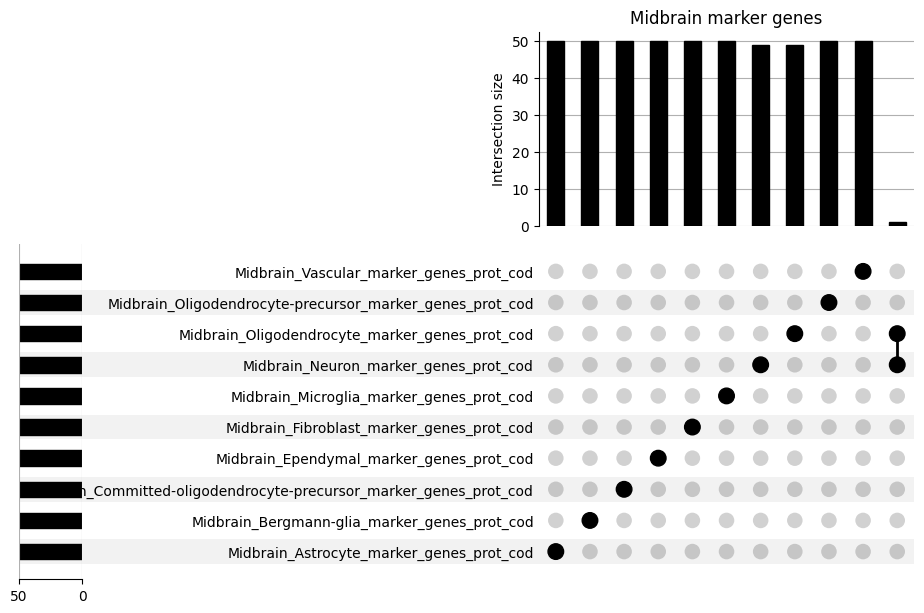

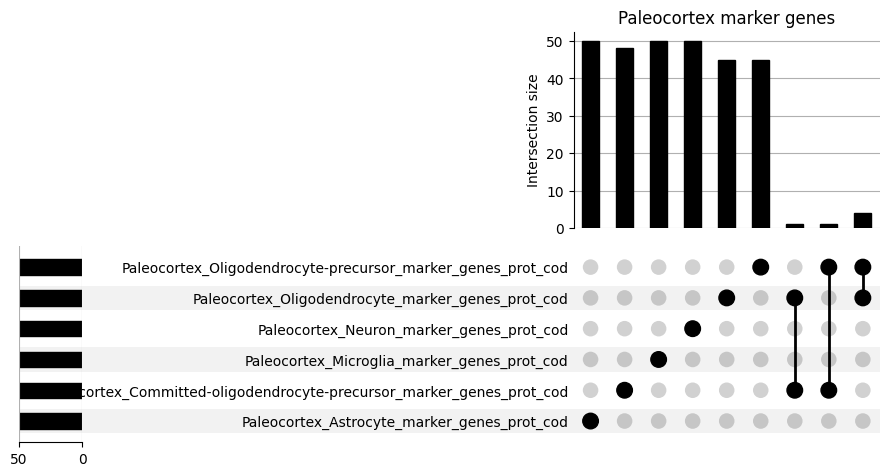

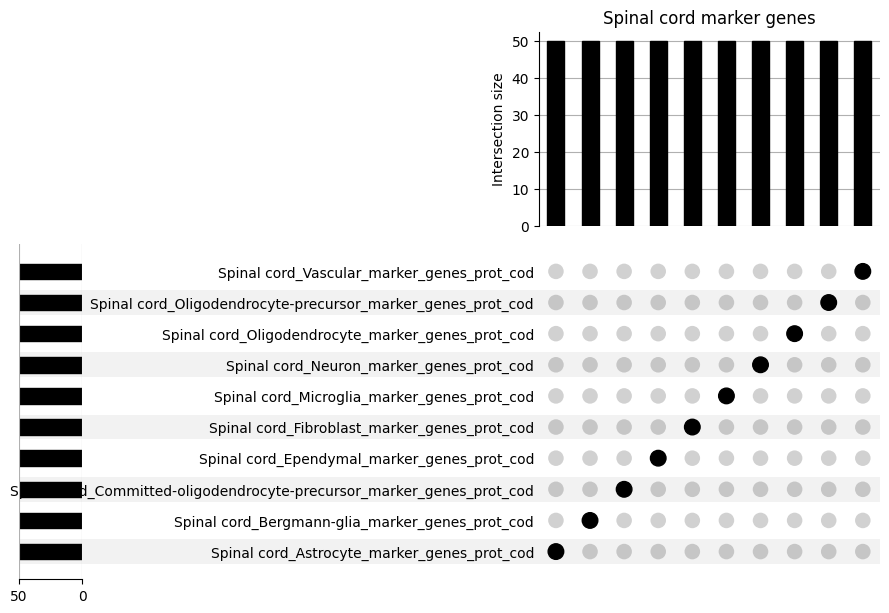

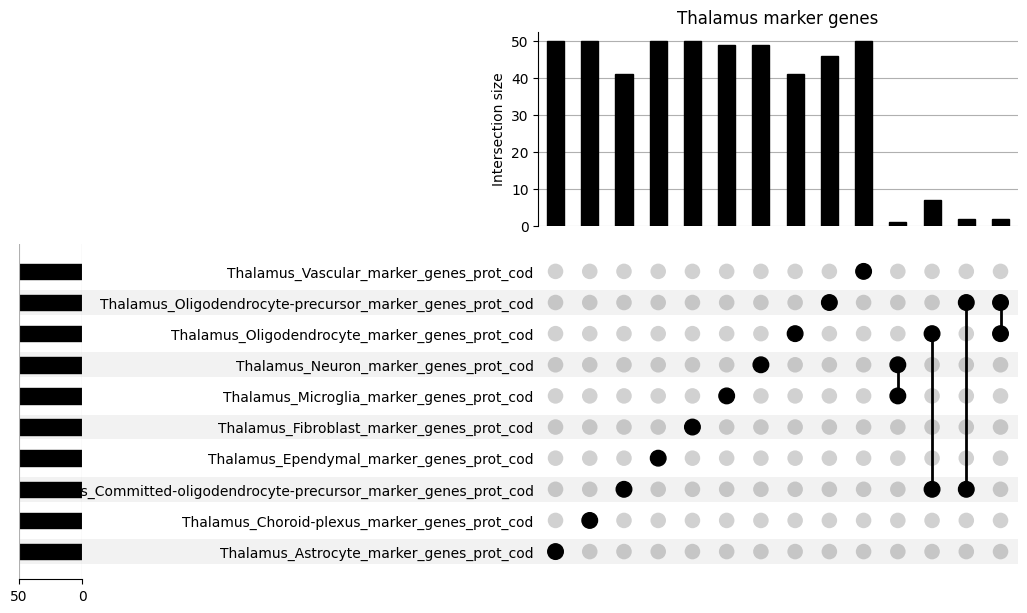

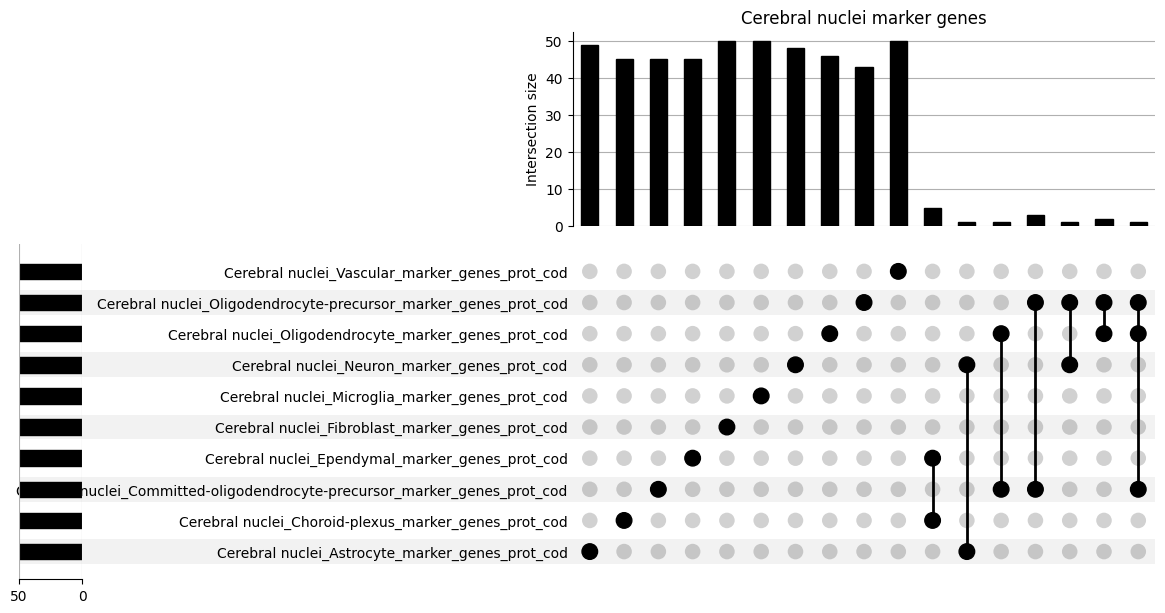

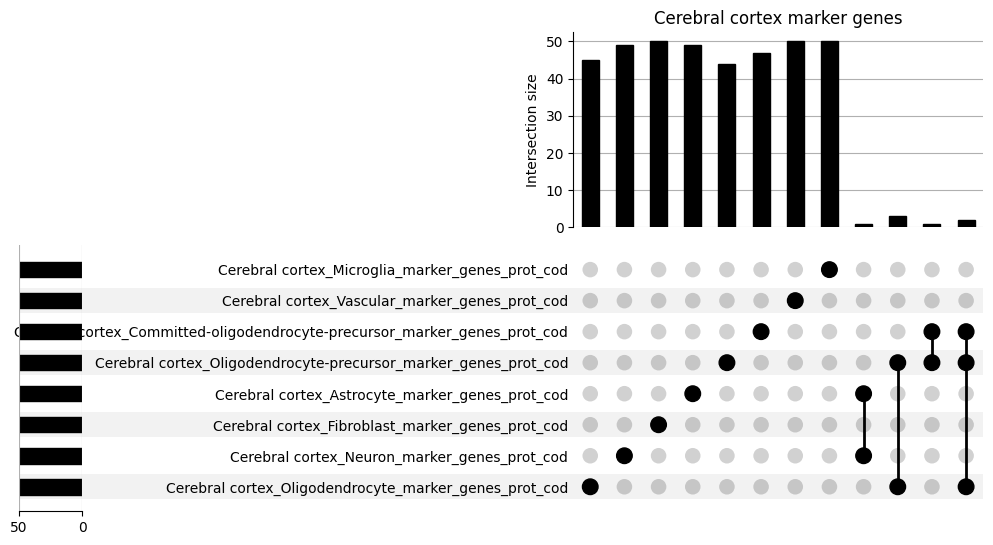

In [131]:
#plot by area of the brain- protein coding

for roi in roi_list:
    keys=[k for k in list(marker_genes.keys()) if (('marker_gene' in k)&(roi in k)&('prot_cod' in k))]
    UpSet(from_contents(    {k: marker_genes[k] for k in keys}
), subset_size='count').plot()
    plt.title(f'{roi} marker genes')

# check the enrichment for genes from the groups on gprofiler

## calculate enrichment

In [129]:
def filter_go_annotations(go_df, term_min=50, term_max=1000, p_th=1e-4, min_intersection=3):
    """Filters available annotations for a community based on specificity and significance.
    Args:
        go_df (pandas.DataFrame): All available significant GO terms for each community
        term_min (int, optional):   The minimum size of a term to keep. Defaults to 50.
        term_max (int, optional): The maximum size of a term to keep. Defaults to 1000.
        p_th (float, optional): The significance threshold. Defaults to 1e-4.
        min_intersection (int, optional): Minimum number of community terms annotated to the GO term. Defaults to 3.

    Returns:
        pandas.DataFrame: A filter dataframe of GO annotations per community, sorted by sum of precision and recall.
    """
    go_df = go_df[(go_df['term_size'] <= term_max) & (go_df['term_size'] >= term_min)]
    go_df = go_df[go_df['intersection_size'] >= min_intersection]
    go_df = go_df[go_df['p_value'] < p_th] # set a stringent pvalue threshold
    go_df['sum_PR'] = go_df['recall'] + go_df['precision']
    go_df = go_df.sort_values('sum_PR',ascending=False)
    return go_df

In [53]:
gene_mapping=rna_mini['gene_symbol'].to_dict()

In [130]:
# Annotate with GO terms
# gprofiler annotation of clusters
gene_mapping=rna_mini['gene_symbol'].to_dict()
system_names = {}
all_results = []
for key in [k for k in list(marker_genes.keys()) if 'marker_gene' in k]:
    # get the genes in the community
    focal_genes=[gene_mapping[key] for key in marker_genes[key] if key in gene_mapping]
    print(focal_genes)
    print(key,":", len(focal_genes))
    system_names[key] = key # default is to keep identifier as name, will be replaced if confident annotation available
    if len(focal_genes)>2:
        # get all available GO:BP annotations
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                         no_evidences=False))
        print(len(gp_temp))
        if len(gp_temp)>0: # make sure data is not empty
            # filter and append the results
            gp_temp["key"] = key
            all_results.append(gp_temp)
            gp_temp = filter_go_annotations(gp_temp, 50, 1000, 1e-3, 3)
            if len(gp_temp)>1:
                system_names[key] = gp_temp.head(1)['name'].tolist()[0]
                #all_results.append(gp_temp)
go_results = pd.concat(all_results)
go_results.to_csv(f"scRNA_seq/hba_all_tissue_full_GO_enrichment.tsv", index=True, sep="\t")


['CTXN2', 'ISM2', 'FLG2', 'ZNF839P1', 'MUC3A', 'TCP11', 'WFDC11', 'ZNF512', 'EFCAB3P1', 'DHRS2', 'ABCG5', 'GPR87', 'STYK1', 'RBMXL1', 'PPFIA1P1', 'PCDHGA3', 'KCNV1', 'RNA5SP203', 'TBX20', 'NANOGNBP2', 'MPIG6B', 'UPK3A', 'HBZ', 'S100P', 'CRYBA1', 'CRYGD', 'PCDHGB3', 'ATP5F1AP3', 'DNASE1L3', 'AGAP7P', 'FABP1', 'TRPC7', 'TMPRSS15', 'FADS2B', 'POTEG', 'CCDC63', 'AGGF1P2', 'RPS15AP14', 'KCNA4', 'BEST2', 'DSC1', 'GXYLT1P3', 'GGT8P', 'CATSPER4', 'CNR2', 'BNIP3P42', 'GOT2P2', 'NDUFAF2P1', 'PRKCIP1', 'LINC02203']
Epithalamus_Astrocyte_marker_genes : 50
18
['TBCE', 'CYP27C1', 'MAG', 'ZNF585B', 'CCDC184', 'BUD13P1', 'BEND3', 'KLHL4', 'MEX3B', 'OLIG1', 'HSD3B7', 'NOC4L', 'HMGB1P8', 'SCNN1A', 'NPSR1', 'DNAH17', 'FOLH1', 'CDH7', 'OPALIN', 'CDH19', 'TRIM71', 'TRIM59', 'SPINK13', 'PLCXD2', 'ENPP7P7', 'CORT', 'ACRV1', 'GPR55', 'KLRB1', 'PYDC1', 'ARHGEF16', 'HUNK', 'GLRA1', 'WIF1', 'TREH', 'SSTR1', 'GLRA3', 'LEAP2', 'SCEL', 'SLITRK3', 'DCAF4L2', 'IFNA2', 'THAP5P2', 'ACP7', 'GREM1', 'NLRP2B', 'CA14', 'NK

## plot enrichment overlap

In [132]:
rna_mini=rna_data[['gene','gene_biotype','transcript_biotype','gene_symbol','in_pcnet']].dropna(axis=0).groupby('gene').agg({
        'gene_biotype': tuple,          # Keep as tuples
        'transcript_biotype': tuple,   # Keep as tuples
        'gene_symbol': 'first',        # Retain single string
        'in_pcnet': 'first'            # Retain single string
})

In [133]:
go_mini=go_results[~go_results.key.str.contains('prot_cod')][['key','description']].groupby('key').agg(set)

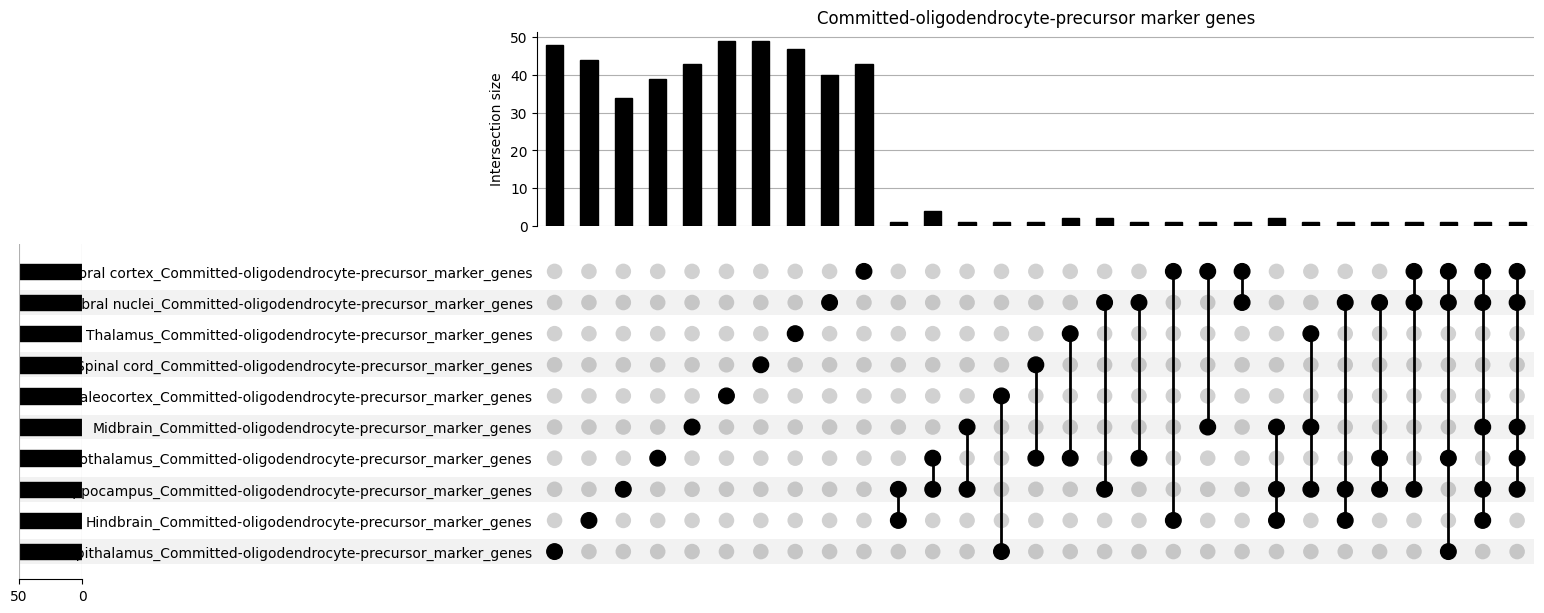

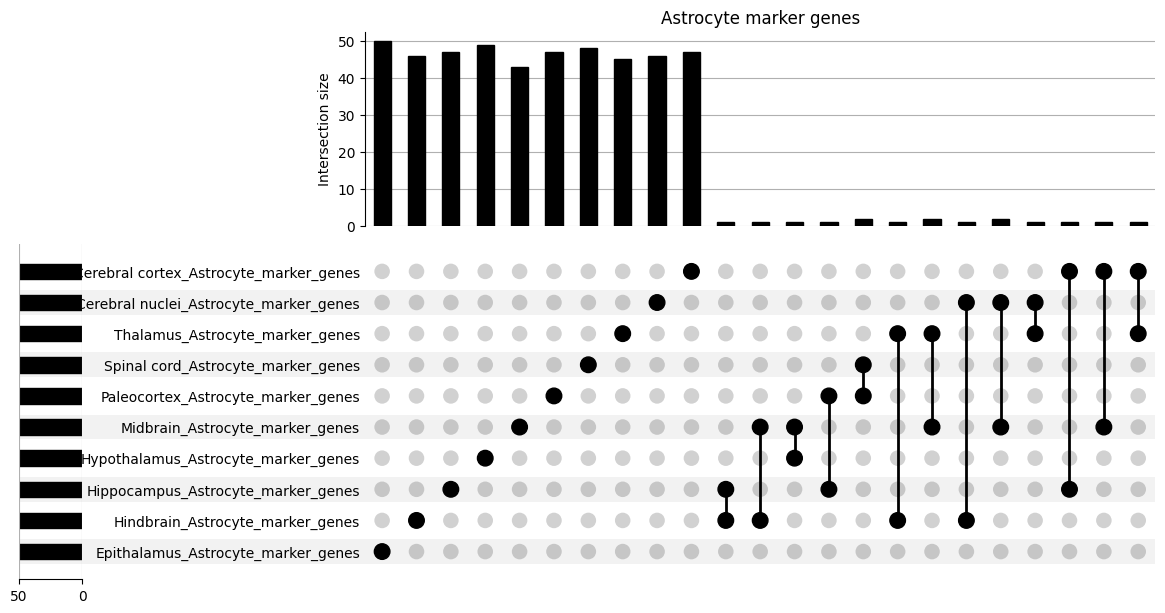

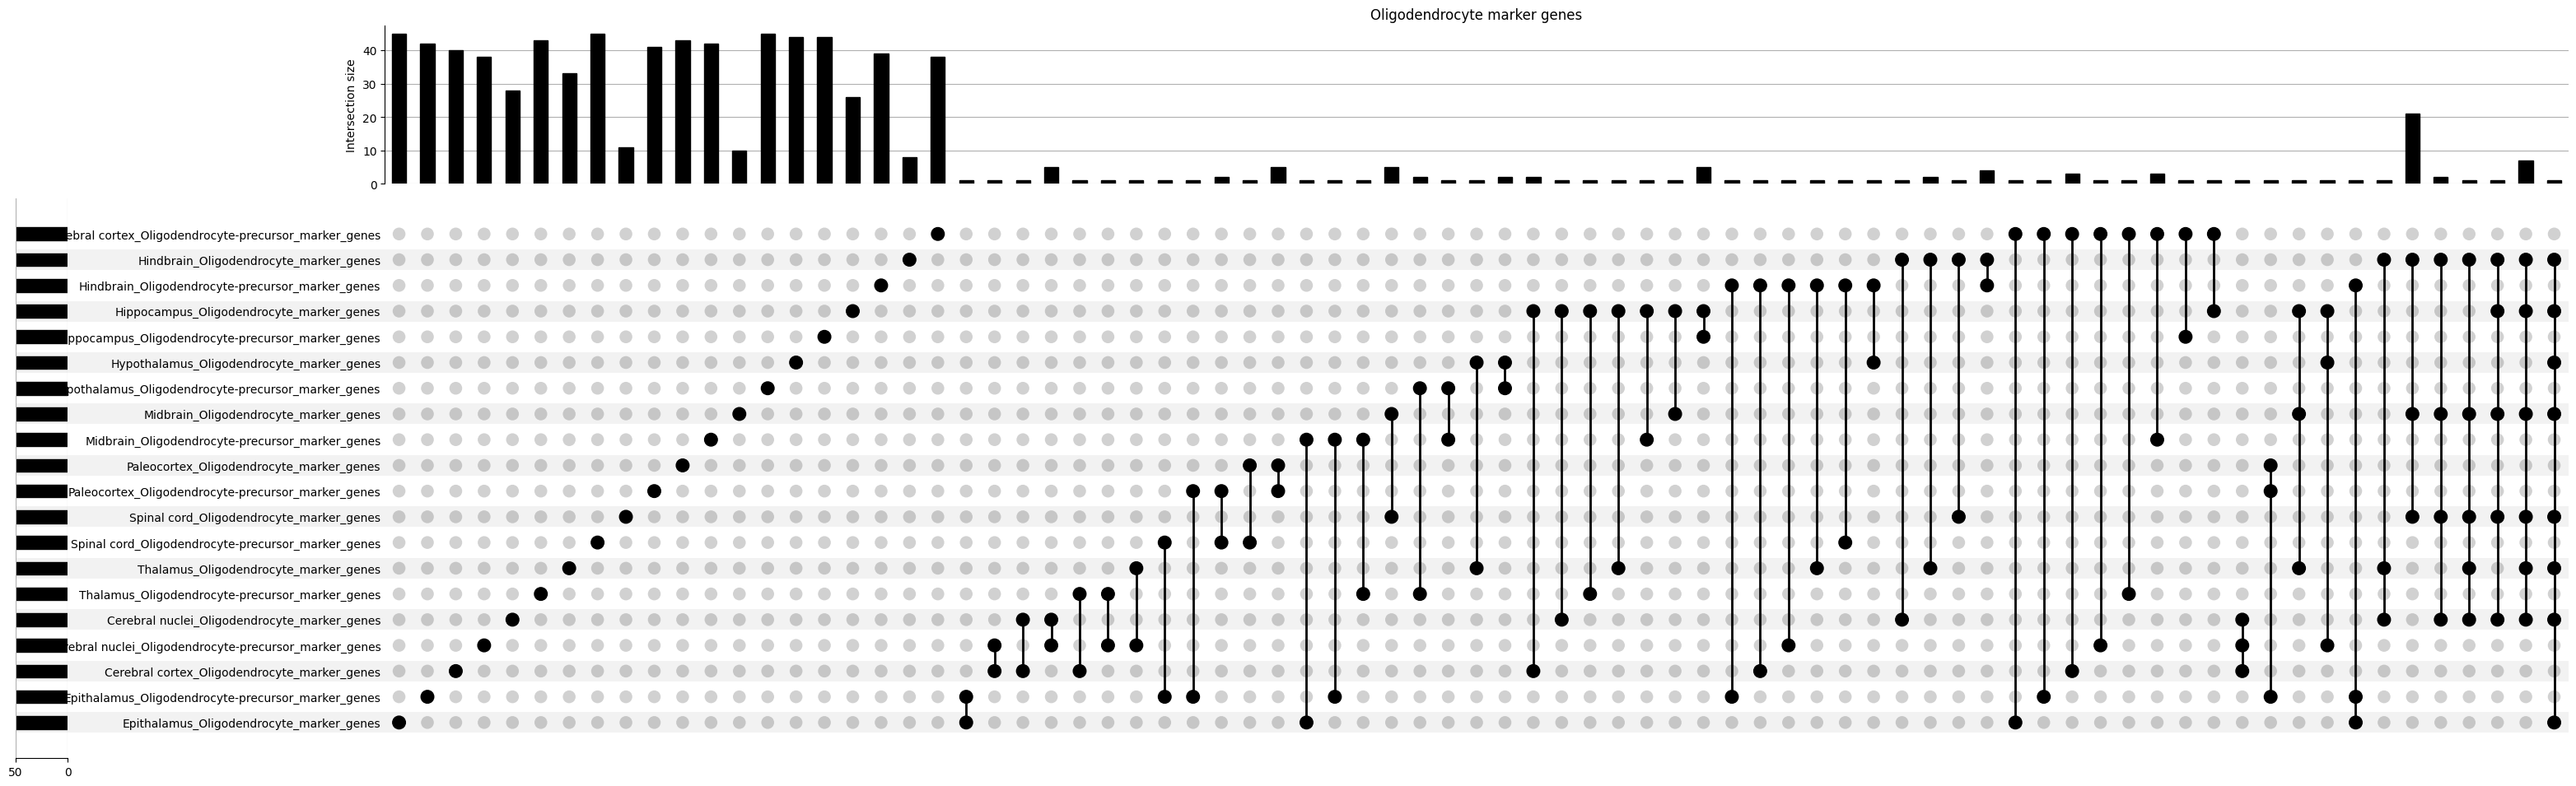

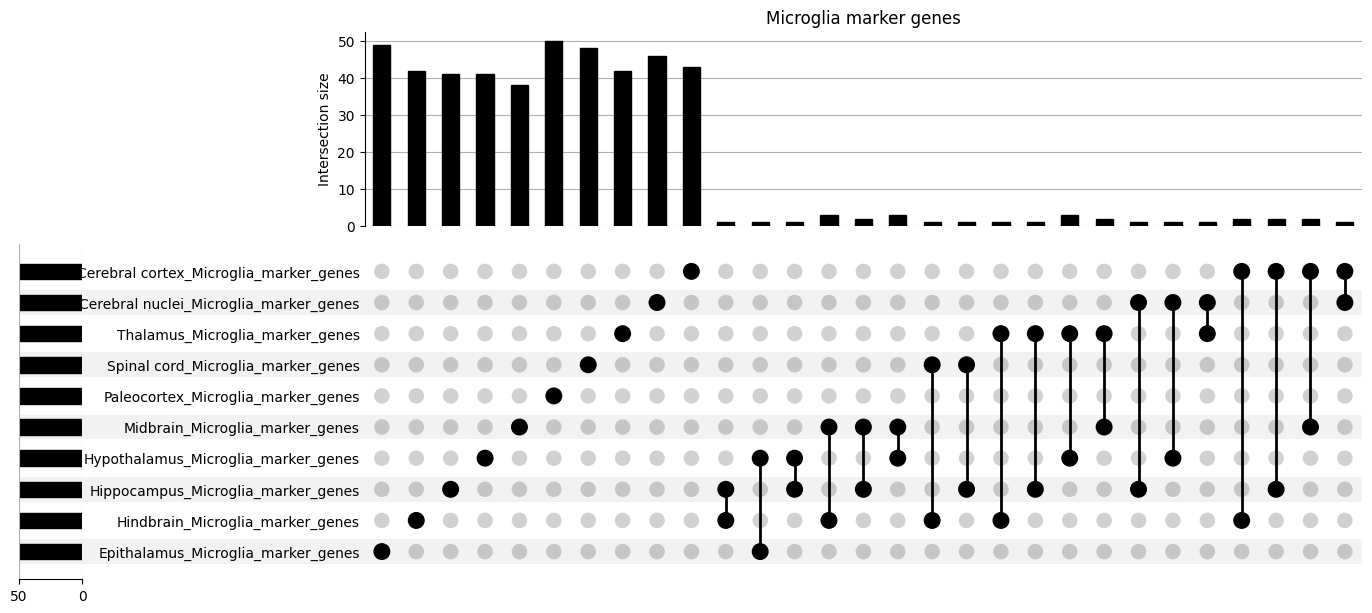

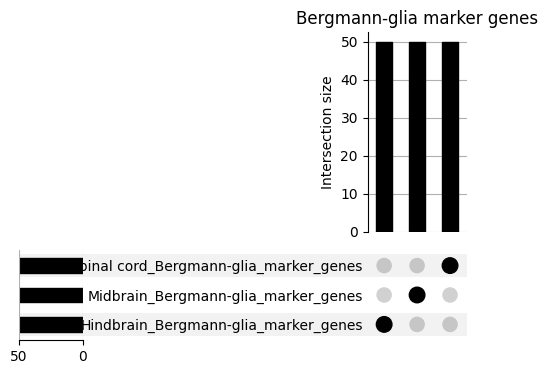

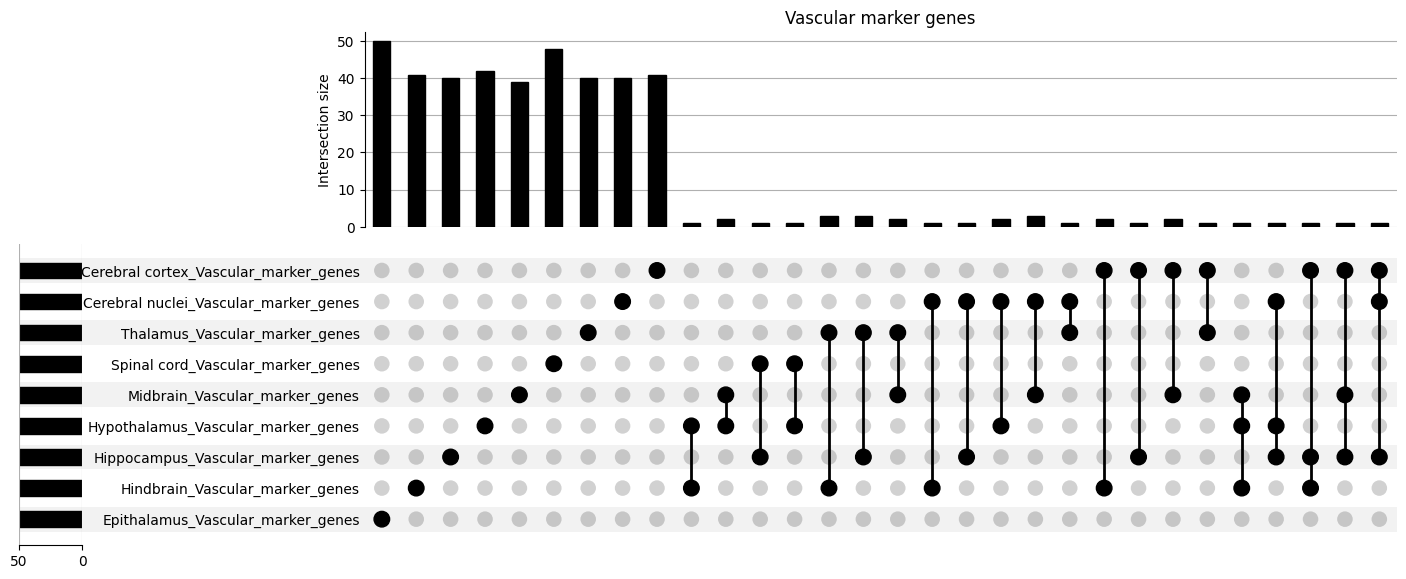

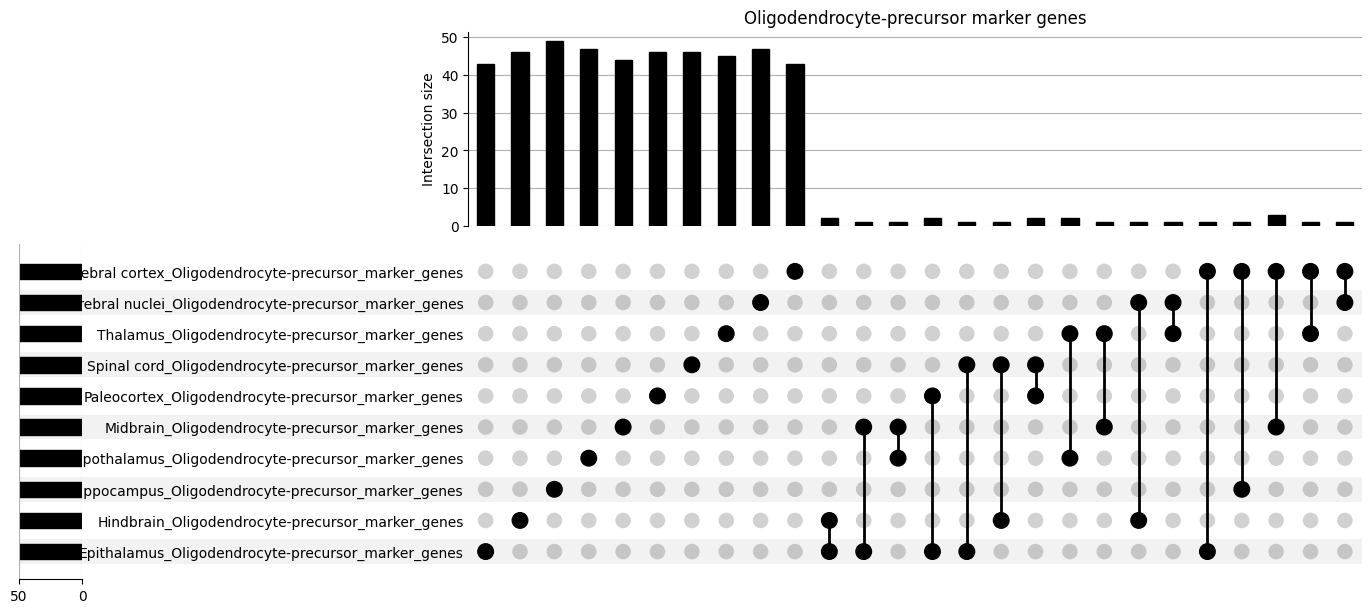

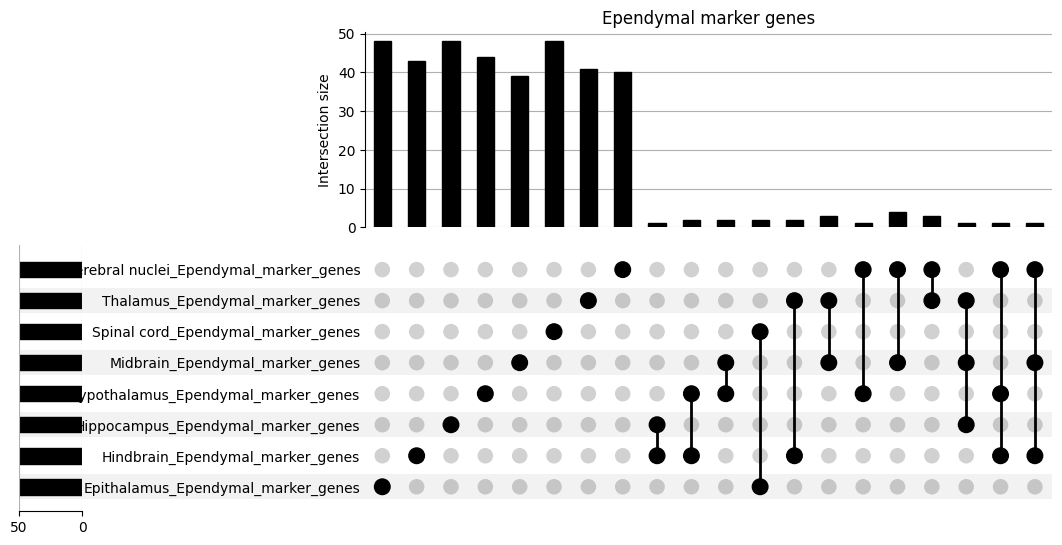

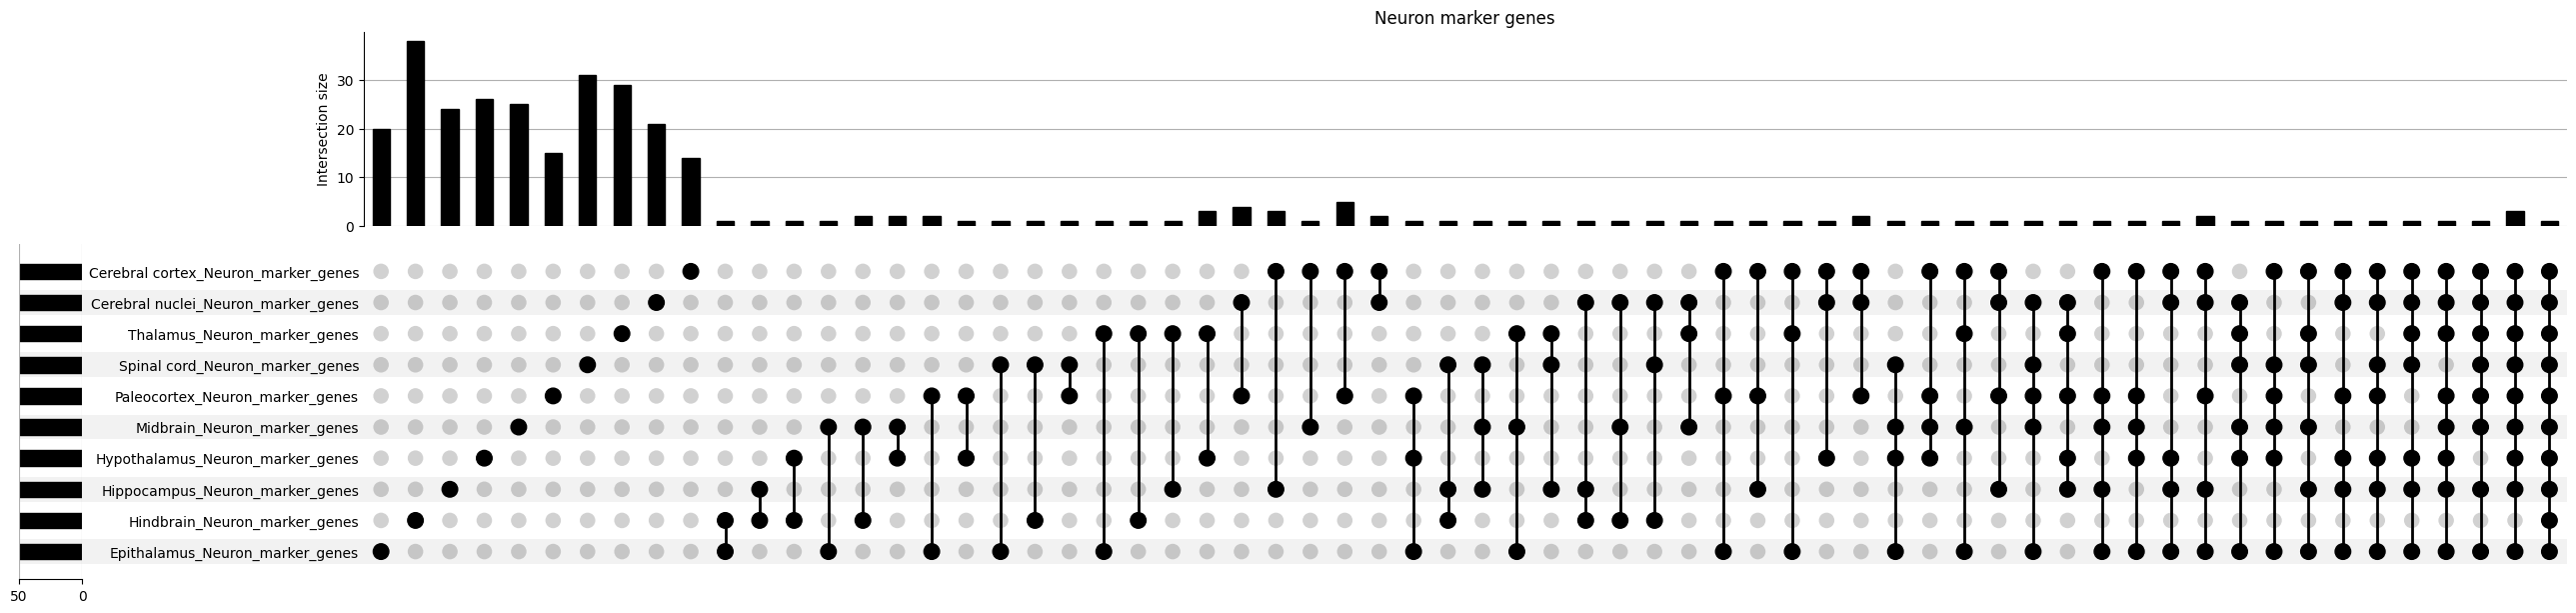

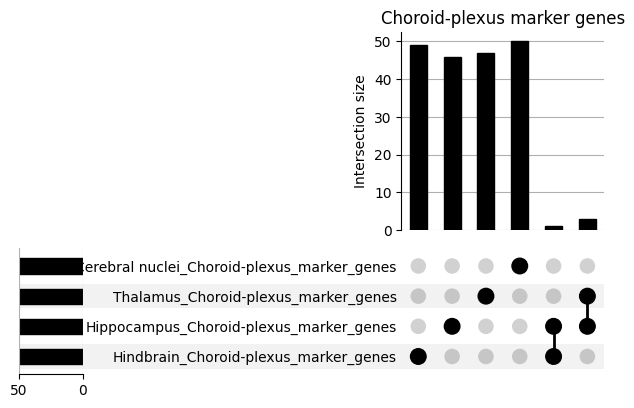

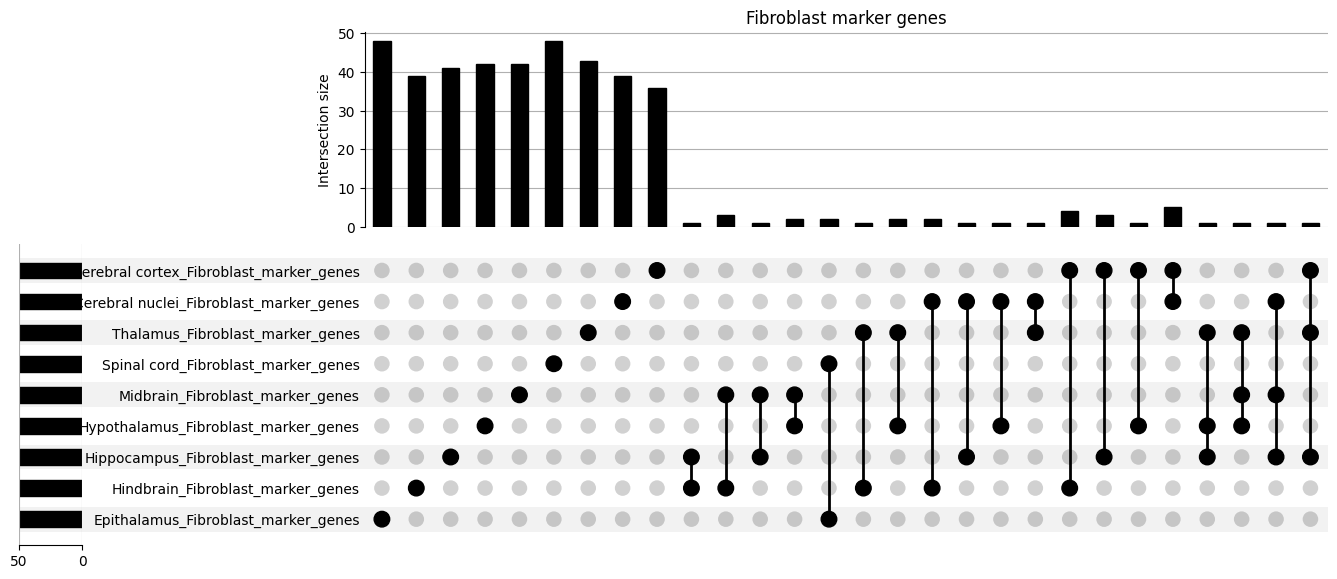

In [135]:
#plot by cell type
for region in region_list:
    keys=[k for k in list(marker_genes.keys()) if (('marker_gene' in k)&(region in k)&('prot_cod' not in k))]
    UpSet(from_contents(    {k: marker_genes[k] for k in keys}
), subset_size='count').plot()
    plt.title(f'{region} marker genes')

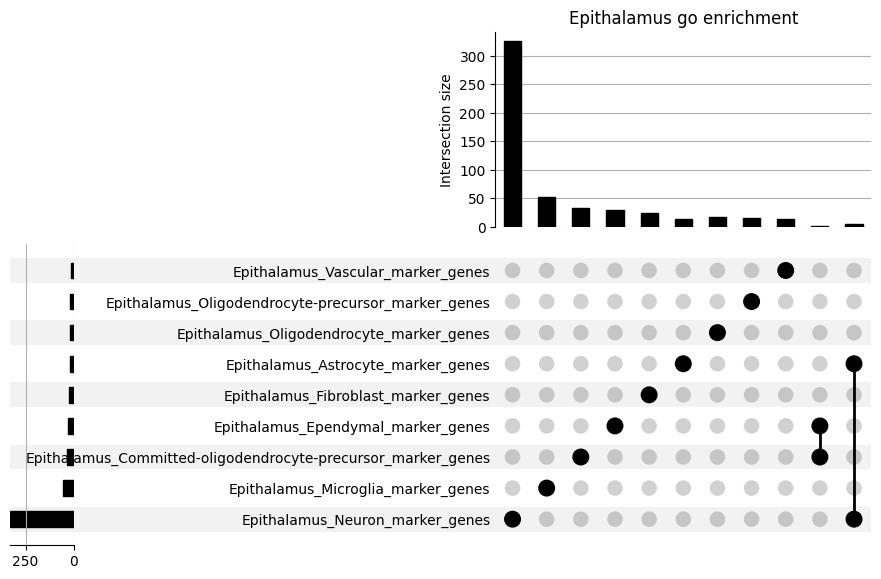

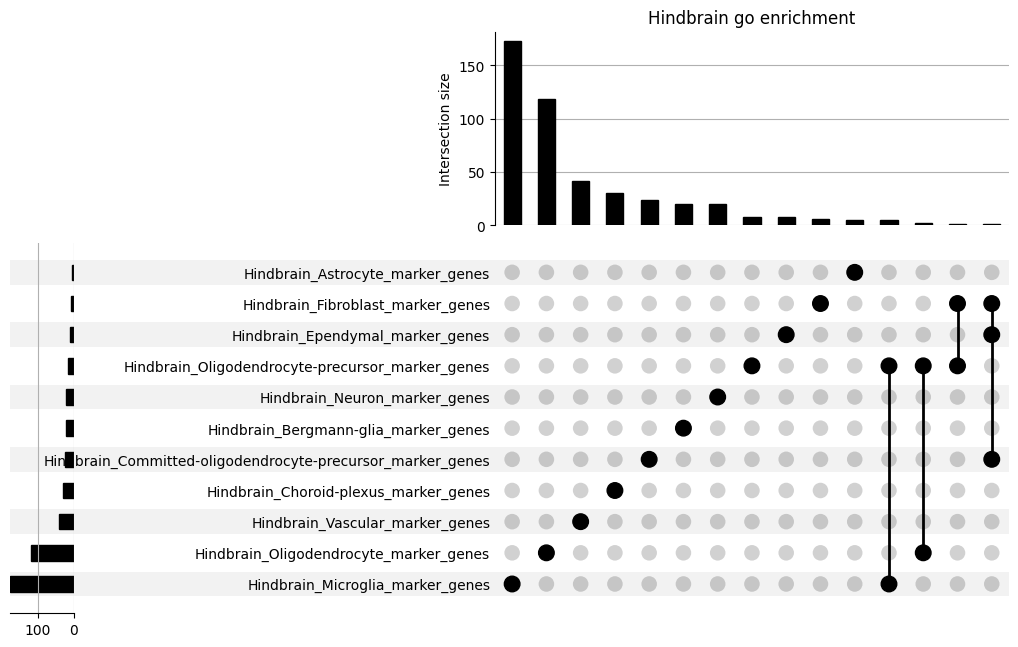

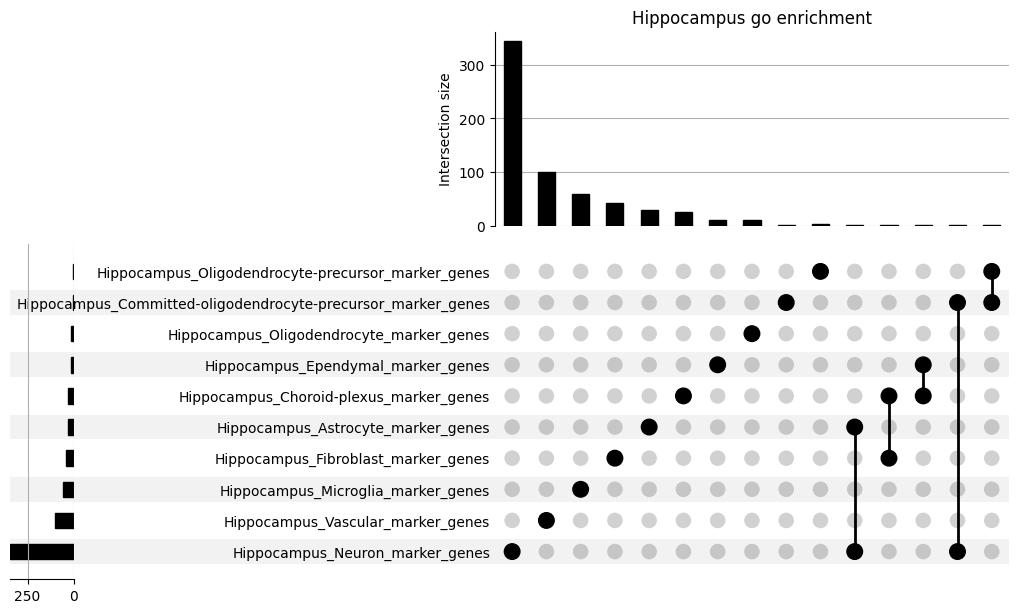

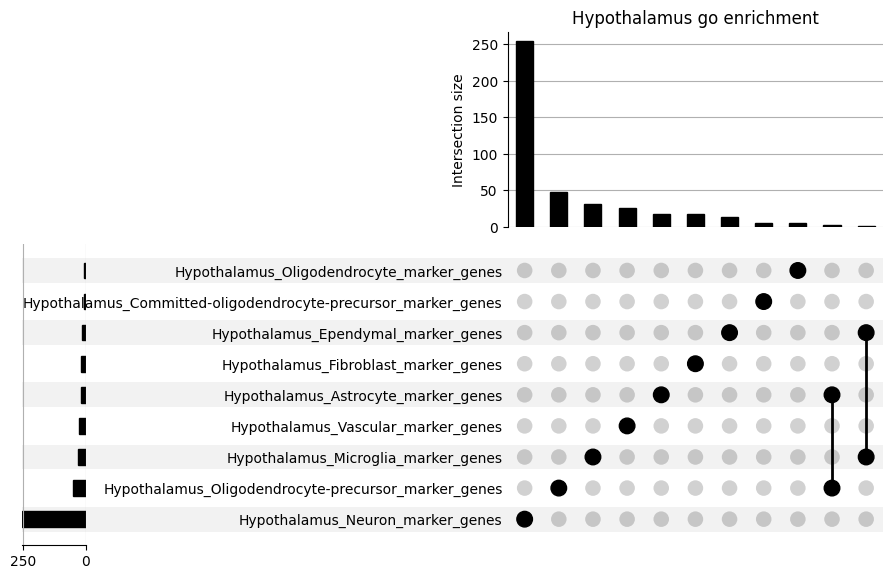

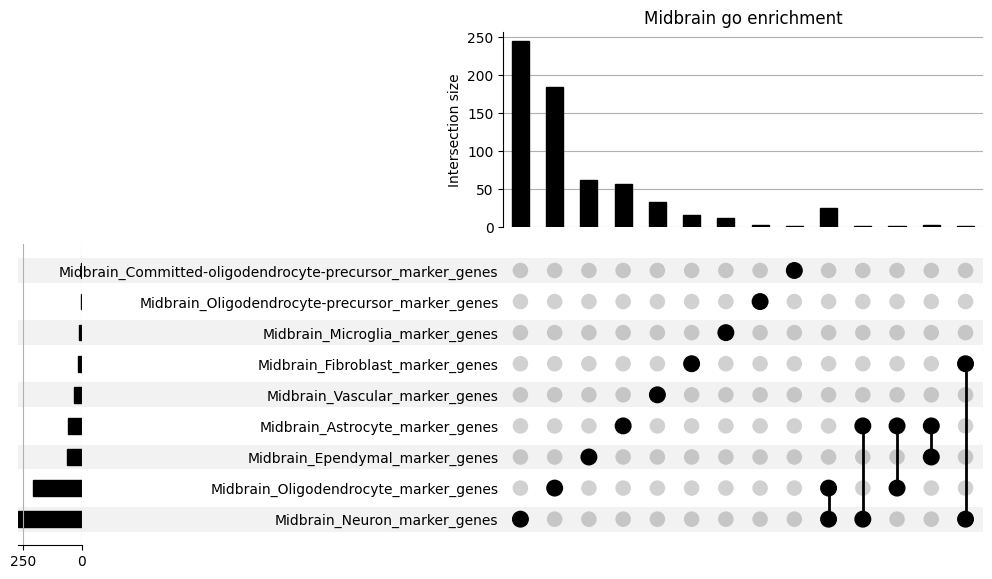

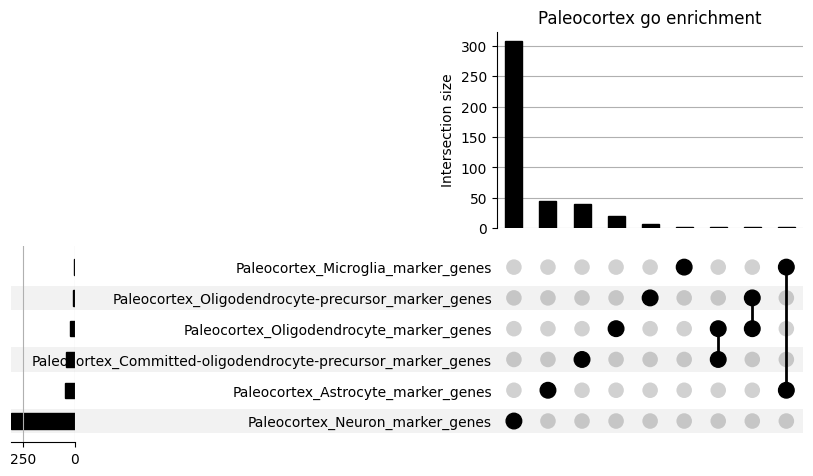

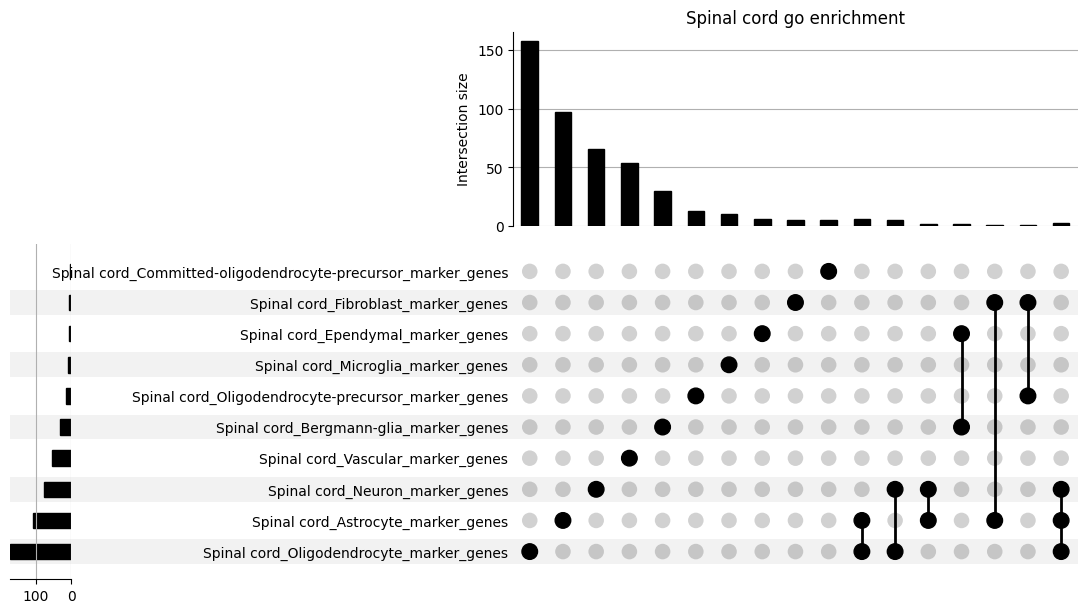

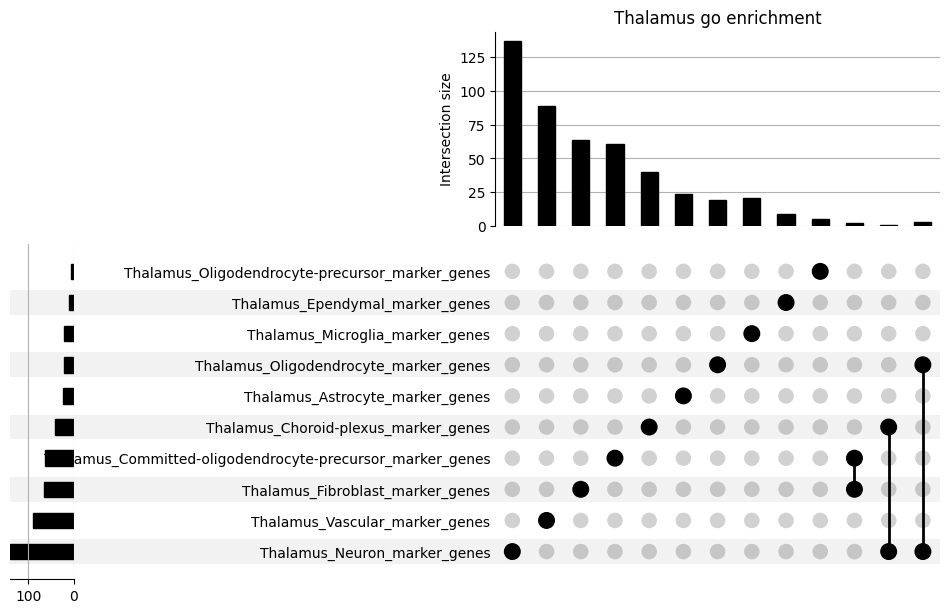

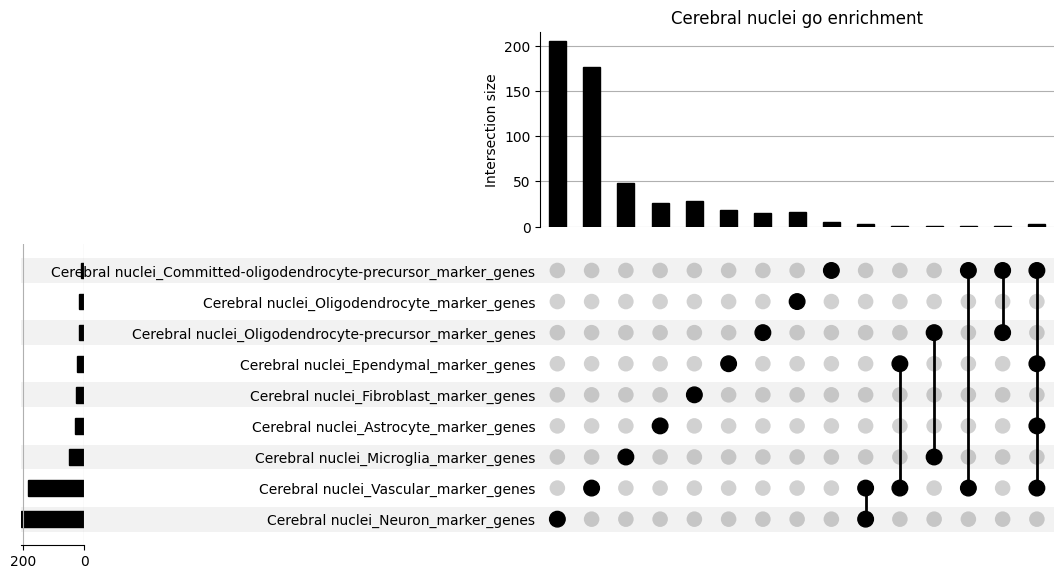

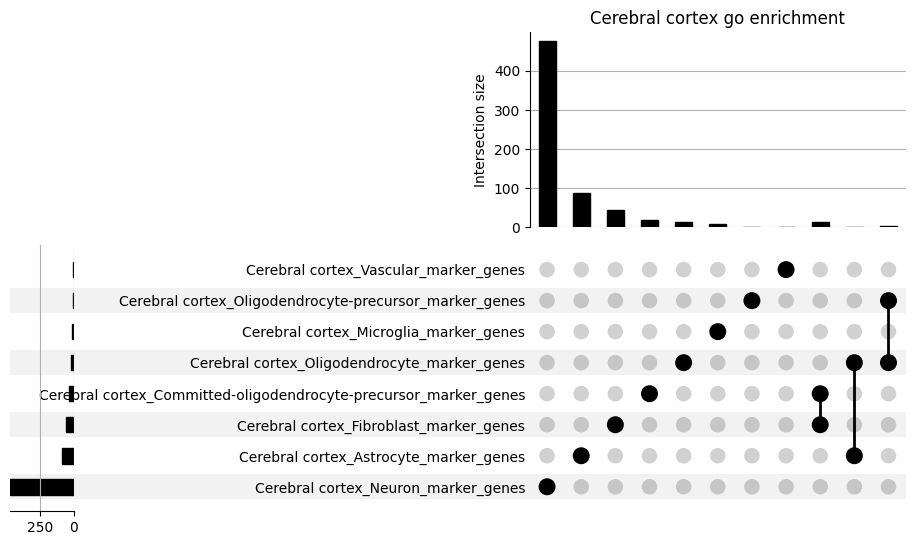

In [137]:
#plot by brain region
for roi in roi_list:
    go_dict=go_mini[go_mini.index.str.contains(roi)]['description'].to_dict()
    #pd.Series(go_dict.keys())[pd.Series(go_dict.keys()).duplicated()] # check if any duplicates
    UpSet(from_contents(go_dict), subset_size='count').plot()
    plt.title(f'{roi} go enrichment')

# check network enrichment

In [38]:
import os
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import random
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [39]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


## Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [40]:
interactome_name='PCNet2.0'

In [41]:
interactome=import_interactome(UUIDs=UUIDs, interactome_name=interactome_name)
all_nodes=list(interactome.nodes())

PCNet2.0
number of nodes:
19267

number of edges:
3852119


In [7]:
#all_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])

## import NPS scores and seed genes

In [42]:
seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,all_nodes)
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR'])

In [43]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [44]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,UUIDs)

## define dataset

In [45]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_gsem'
trait_h='ext'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)


In [46]:
name=label_r+'_'+label_h+'_'+interactome_name+'_MAGMA'

In [47]:
net=network_colocalization.calculate_network_overlap_subgraph(
    interactome, pd.Series(NPS_r['z']), pd.Series(NPS_h['z']), cut_comb, cut_single, cut_single)
net=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])
net_cx = ndex2.create_nice_cx_from_networkx(net)
net_cx.set_name(name)

## calculate enrichment

In [50]:
rerun_net_enrichment=True
save_enr=False

In [51]:
keys=[k for k in list(marker_genes.keys()) if (('marker_gene' in k)&('prot_cod' not in k))]
coloc_dict_cat={
    'graph':set(pcnet_nodes),
    'net':set(net.nodes()),
    'total':set(rna_data.gene_symbol)
}

In [54]:
if rerun_net_enrichment:
    enr_tbl=pd.DataFrame(columns=['key','community_genes','intersecting_genes','odds_ratio','log_se_or','p_intersect'])
    
    for key in keys:
        print(f'testing enrichment for {key}')
        t=set([gene_mapping[key] for key in marker_genes[key] if key in gene_mapping])
        odds_ratio, log_se_or, p_intersect, gene_list= calculate_enrichment(t=t,coloc_dict_cat=coloc_dict_cat,k=key,sub='net',total='graph',verbose=True)
        enr_tbl = pd.concat([pd.DataFrame([[key, t,gene_list,odds_ratio, log_se_or, p_intersect]], columns=enr_tbl.columns), enr_tbl], ignore_index=True)
    #enr_tbl.to_csv(f'scRNA_seq/hba_enr_marker_50_{name}.csv',index=False)
else:
    enr_tbl=pd.read_csv(f'scRNA_seq/hba_enr_marker_50_{name}.csv')

testing enrichment for Epithalamus_Astrocyte_marker_genes
Enrichment of network nodes in genes in the GWAS catalog annotated for Epithalamus_Astrocyte_marker_genes: p=1.0
Enrichment calculated using hypergeom.sf for Epithalamus_Astrocyte_marker_genes: p=1.0
Odds ratio: OD=0.0
Number of annotated genes in graph: 20
Number of annotated genes in net: 0

testing enrichment for Epithalamus_Committed-oligodendrocyte-precursor_marker_genes
Enrichment of network nodes in genes in the GWAS catalog annotated for Epithalamus_Committed-oligodendrocyte-precursor_marker_genes: p=1.0
Enrichment calculated using hypergeom.sf for Epithalamus_Committed-oligodendrocyte-precursor_marker_genes: p=1.0
Odds ratio: OD=0.0
Number of annotated genes in graph: 22
Number of annotated genes in net: 0

testing enrichment for Epithalamus_Ependymal_marker_genes
Enrichment of network nodes in genes in the GWAS catalog annotated for Epithalamus_Ependymal_marker_genes: p=0.2912686913731413
Enrichment calculated using hy

# plot enrichment

In [156]:
save_fig=True

In [157]:
if save_fig==True:
    outpath_dir=f'validation_output/scRNA_seq_hba_enr_marker_50_{name}_enr'
    if not os.path.exists(outpath_dir):
        os.makedirs(outpath_dir)

In [158]:
colormap=plt.colormaps.get_cmap('tab20b')

In [56]:
enr_tbl=enr_tbl.sort_values('p_intersect',ascending=False)

In [59]:
enr_tbl[enr_tbl['p_intersect']<0.05/len(enr_tbl)]

Empty DataFrame
Columns: [key, community_genes, intersecting_genes, odds_ratio, log_se_or, p_intersect]
Index: []

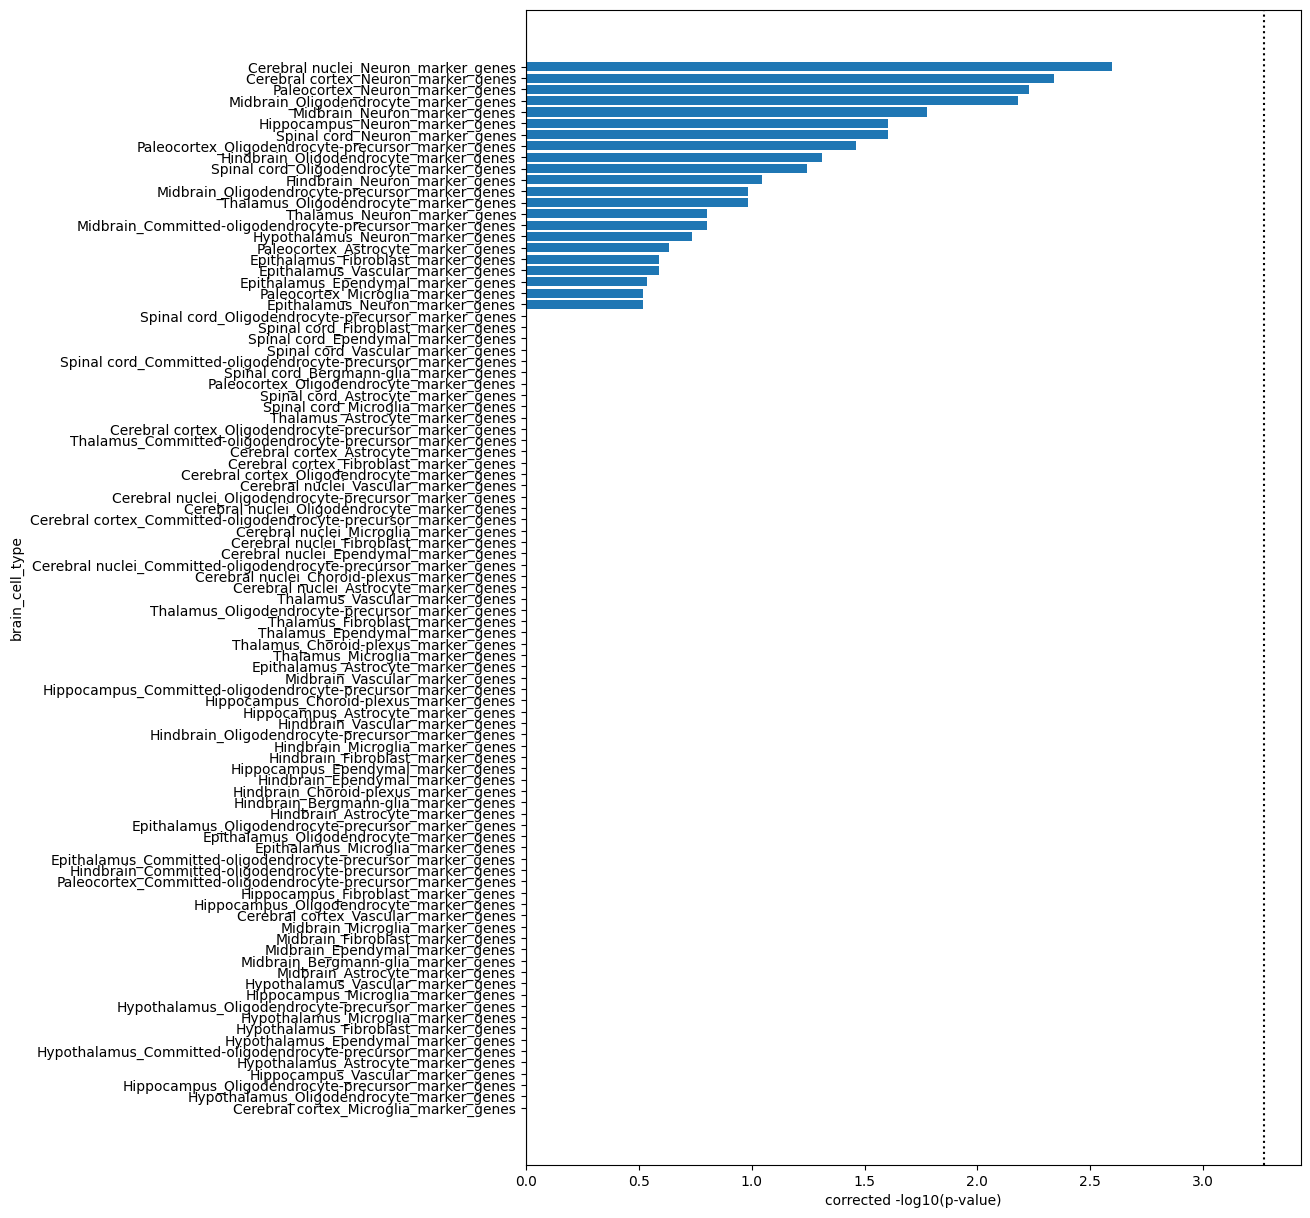

In [57]:
fig = plt.figure(figsize=(10, 15))

plt.barh(y=enr_tbl.key, width=-np.log10(enr_tbl.p_intersect),label=enr_tbl.key)

plt.ylabel('brain_cell_type')
plt.xlabel('corrected -log10(p-value)')
plt.axvline(-np.log10(0.05/len(enr_tbl)), color='black', ls=':')
plt.axvline(0, color='black', ls='-')
#plt.savefig(f'figures/hba_enr_marker_25_{name}_net_enr.svg')

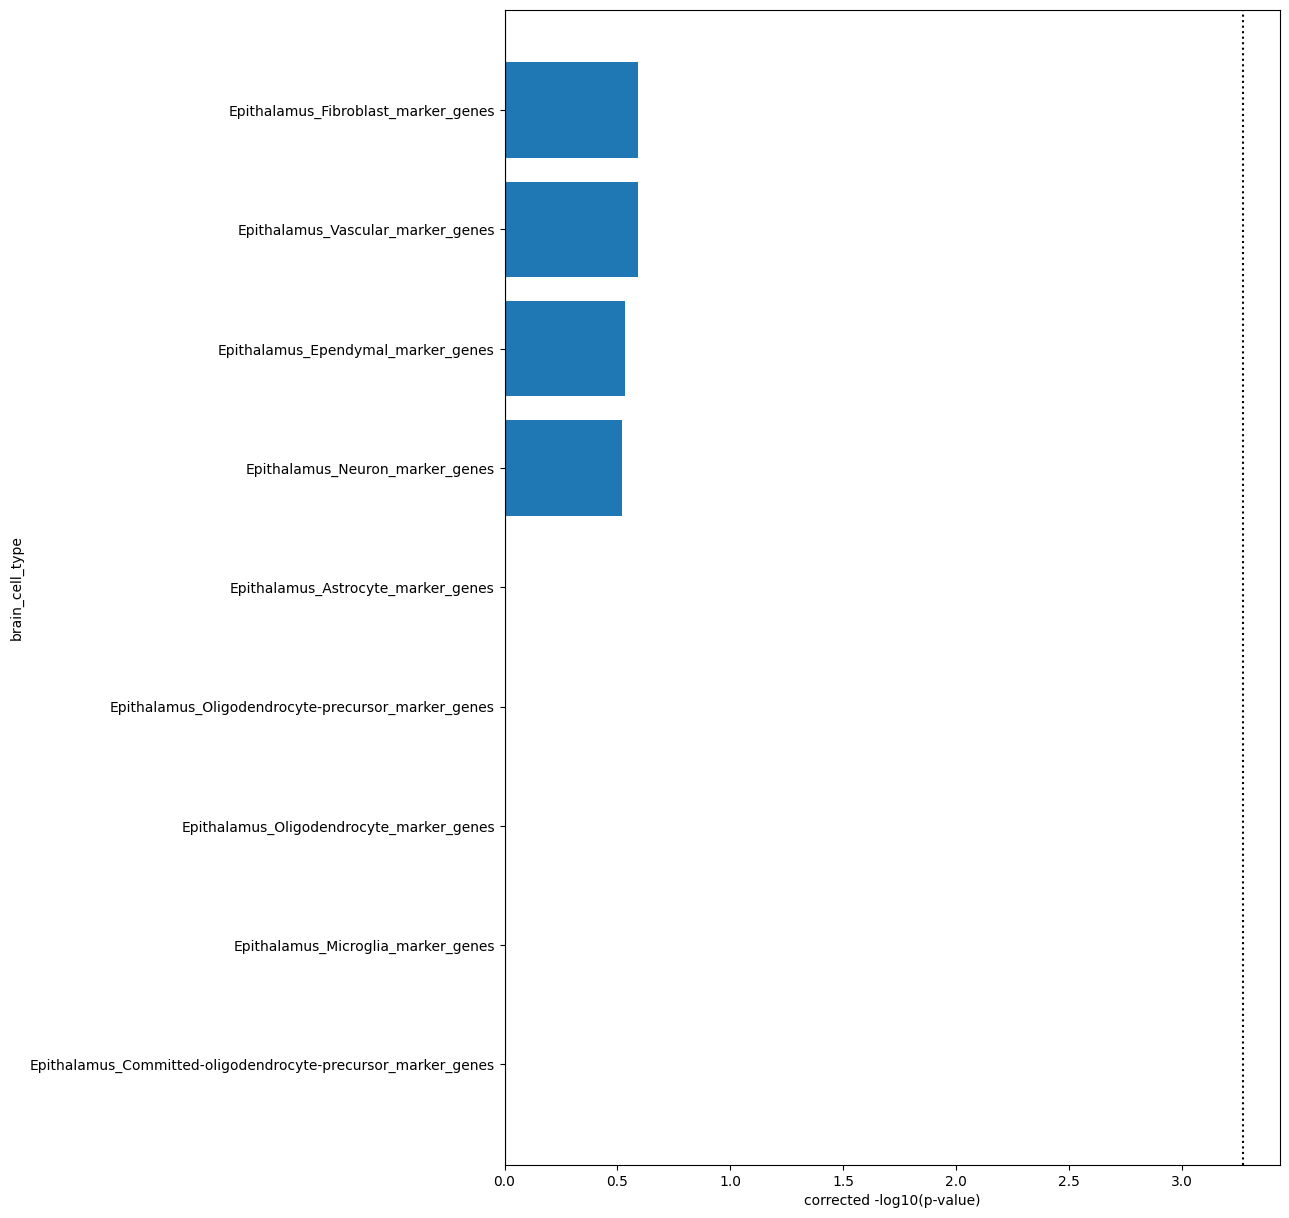

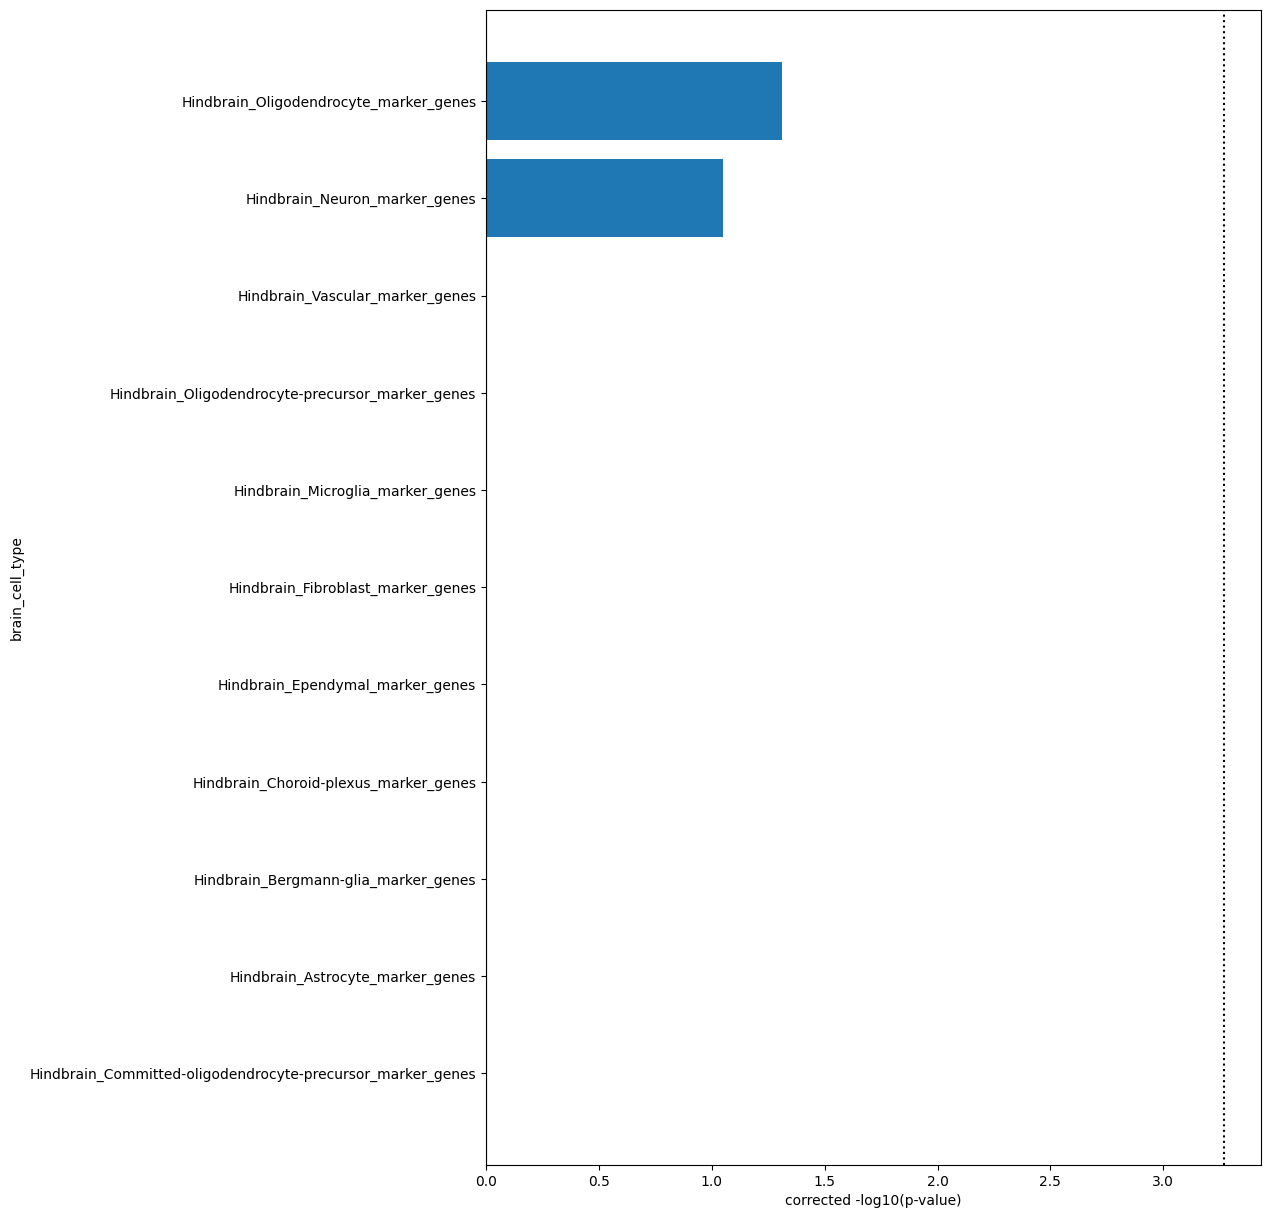

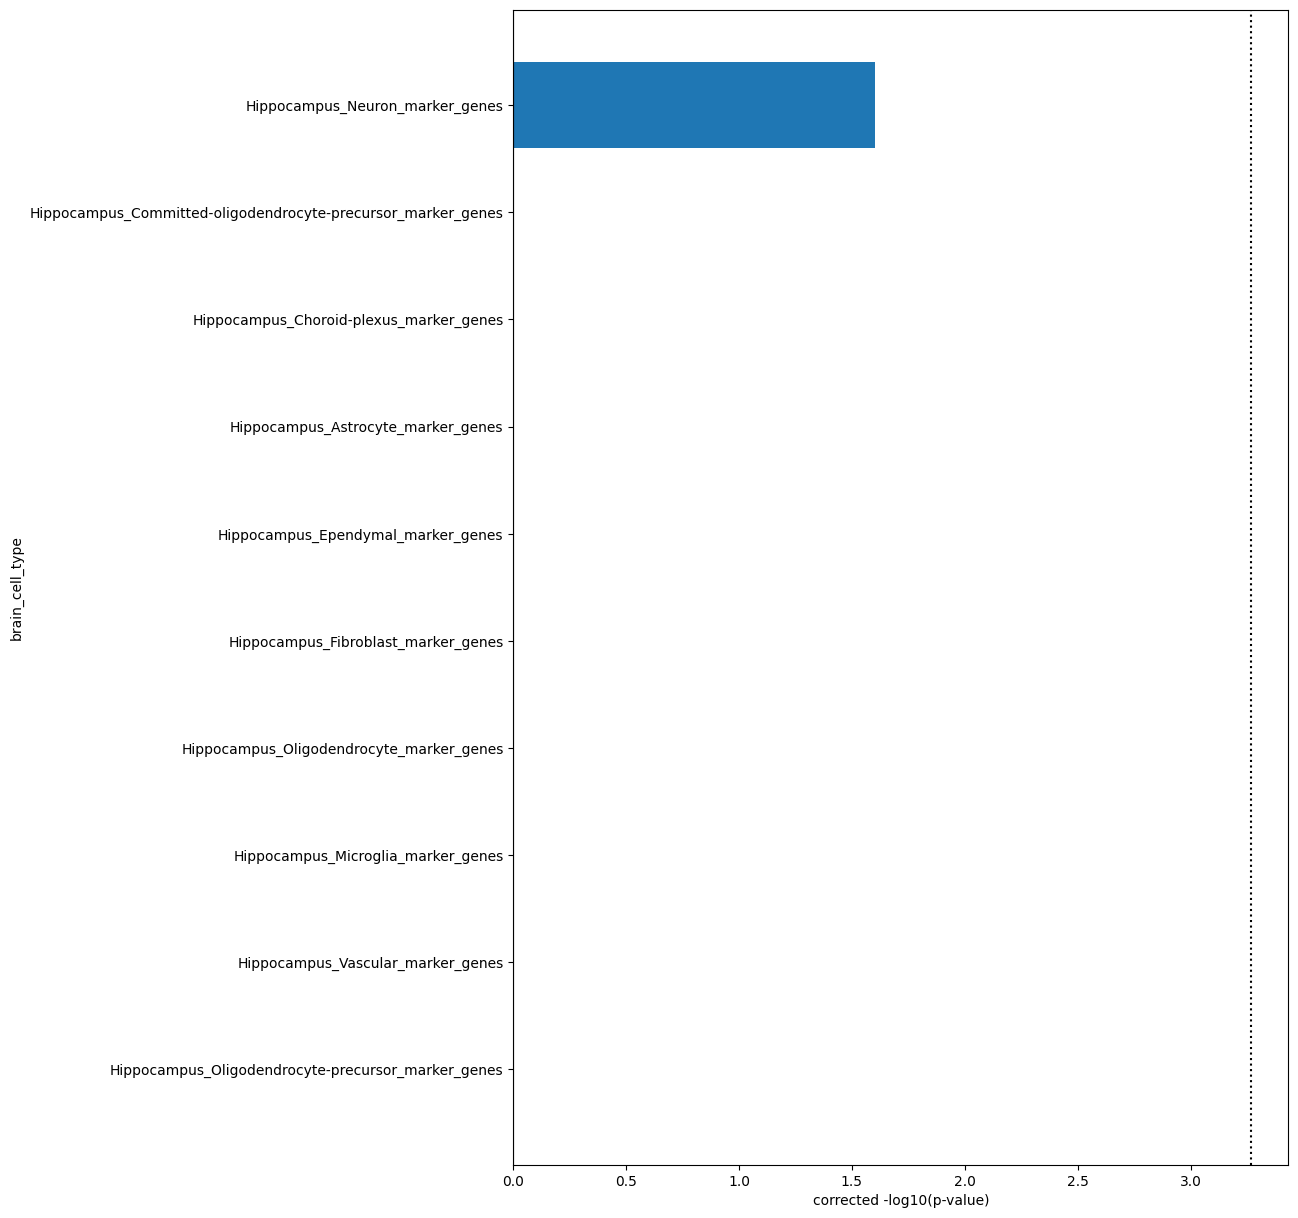

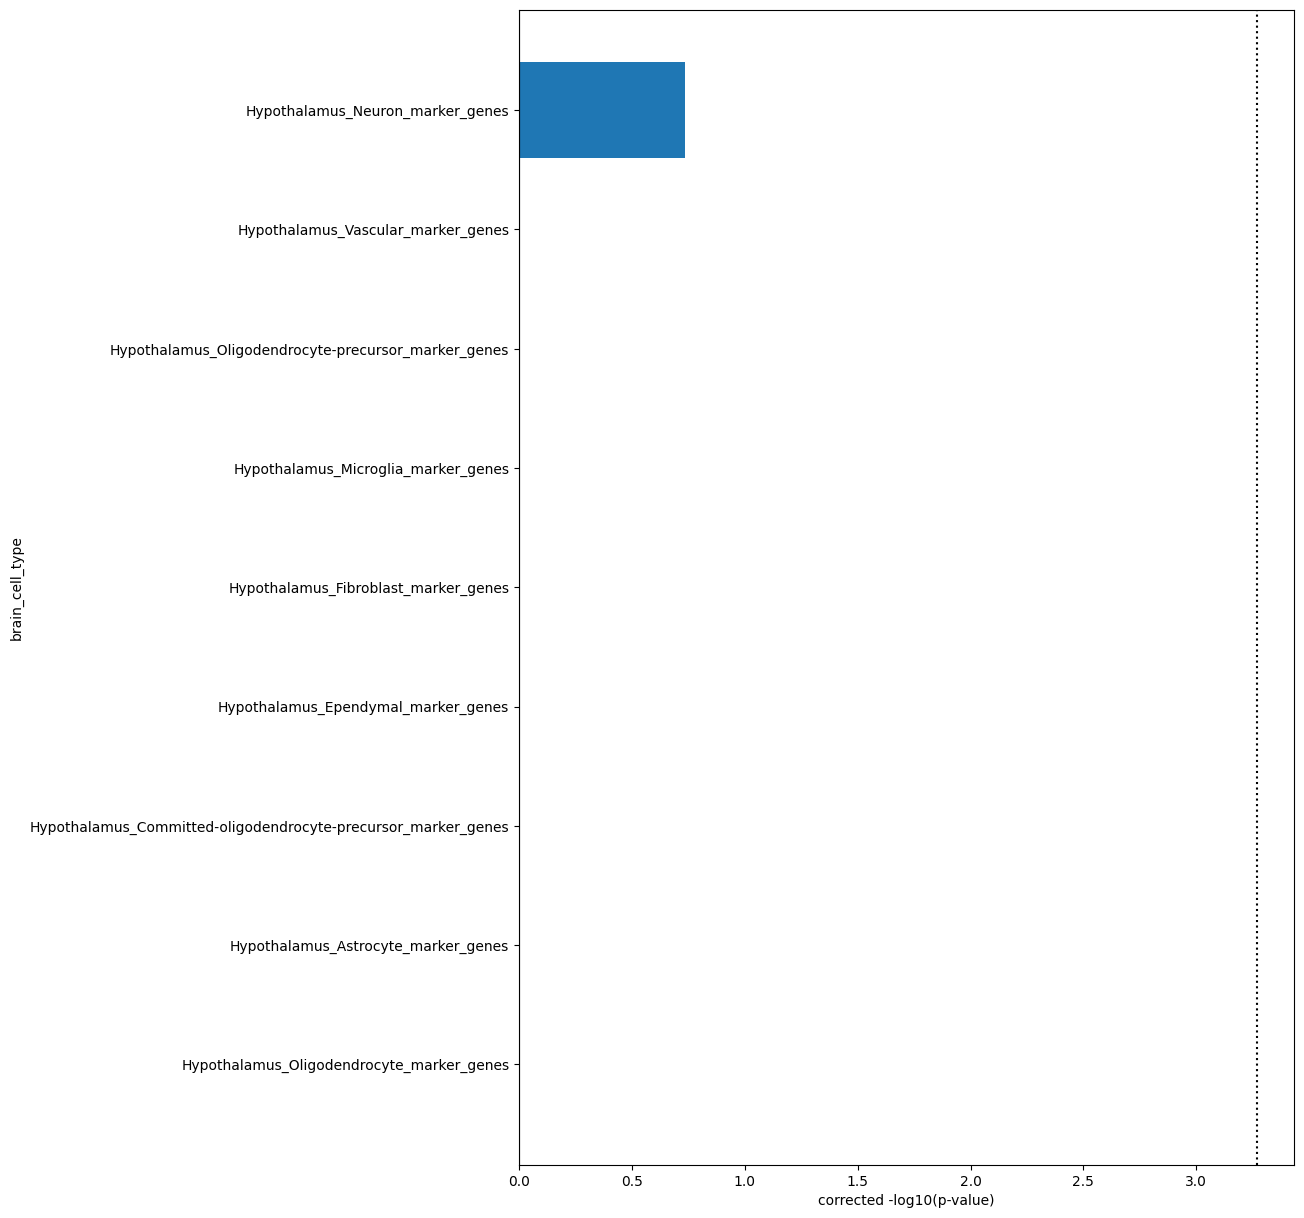

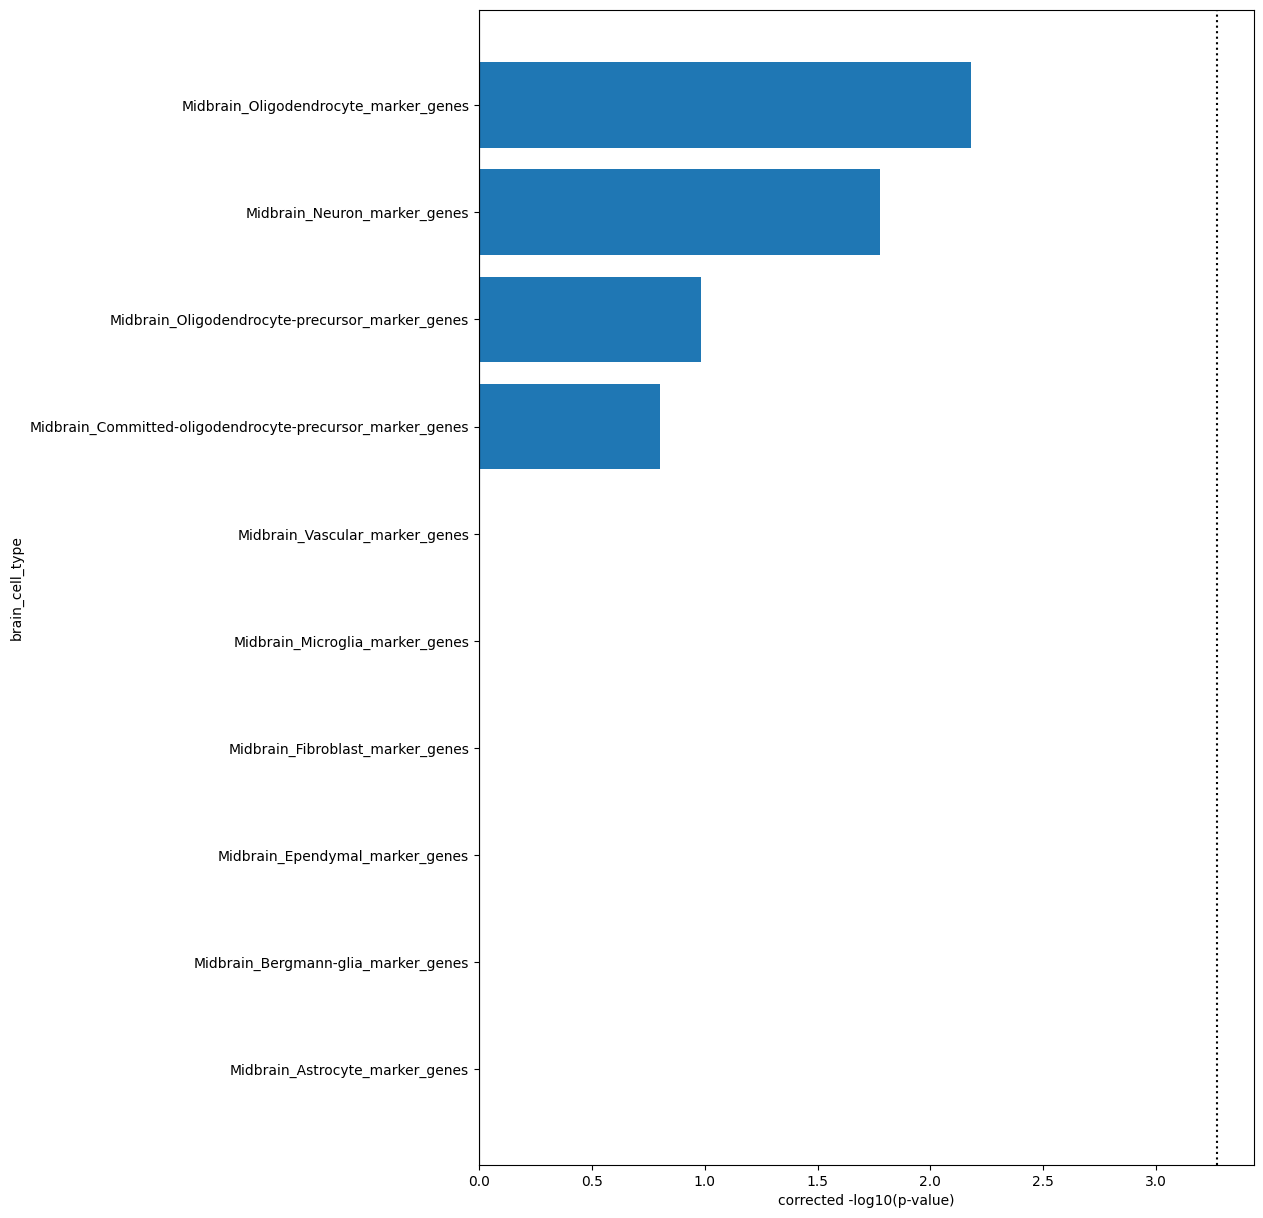

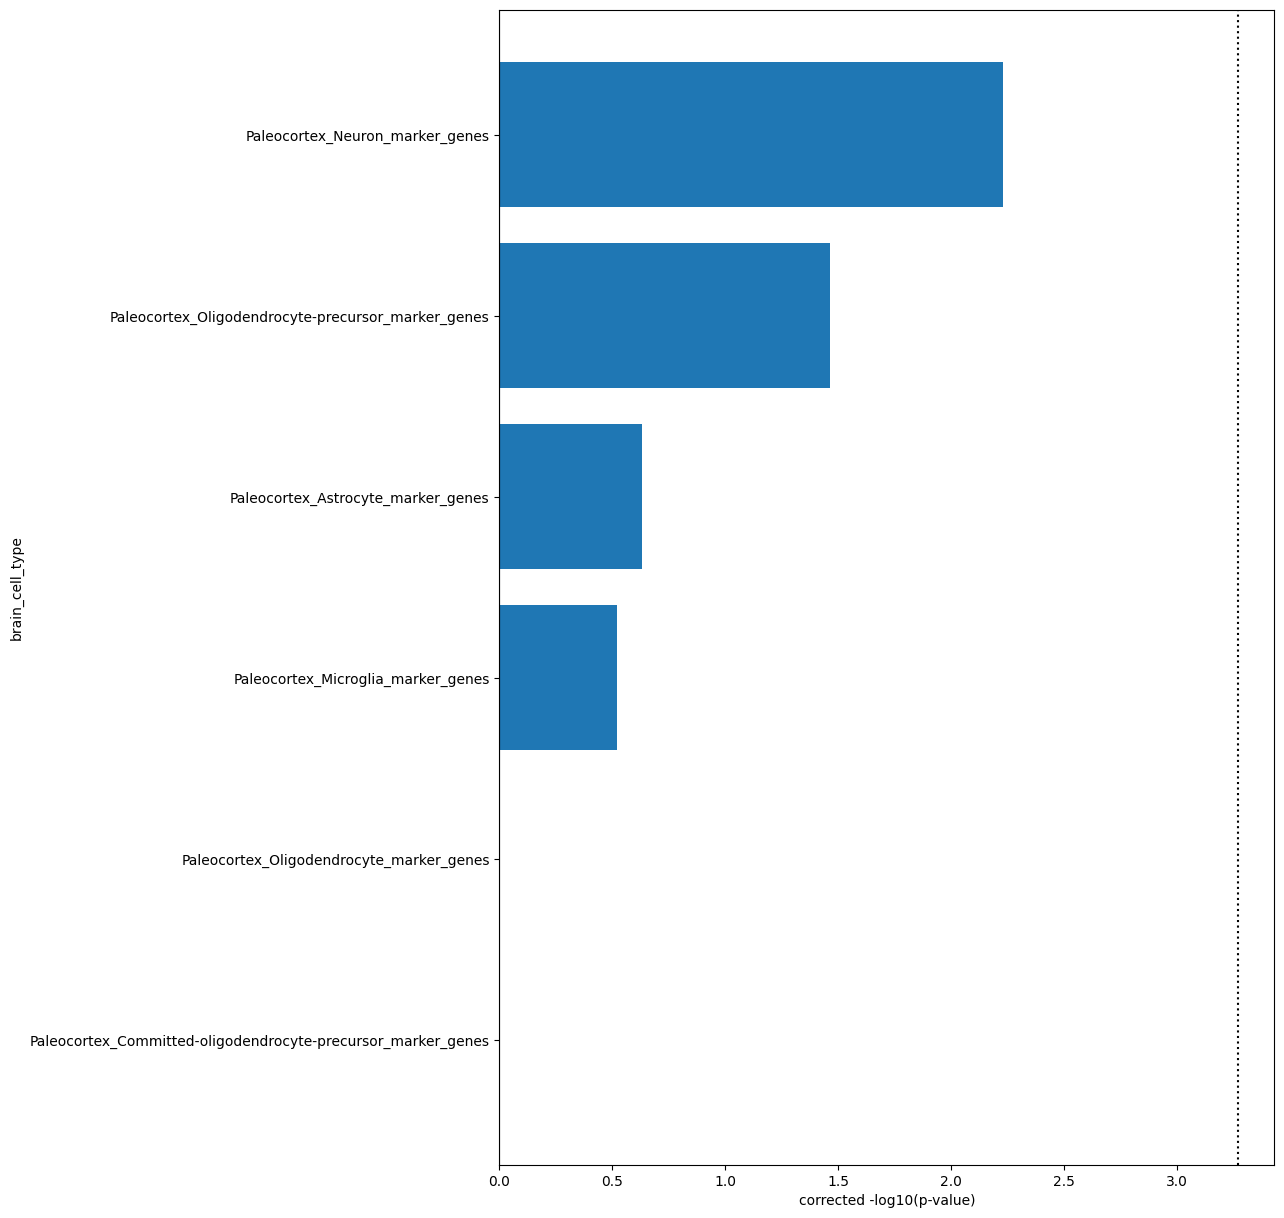

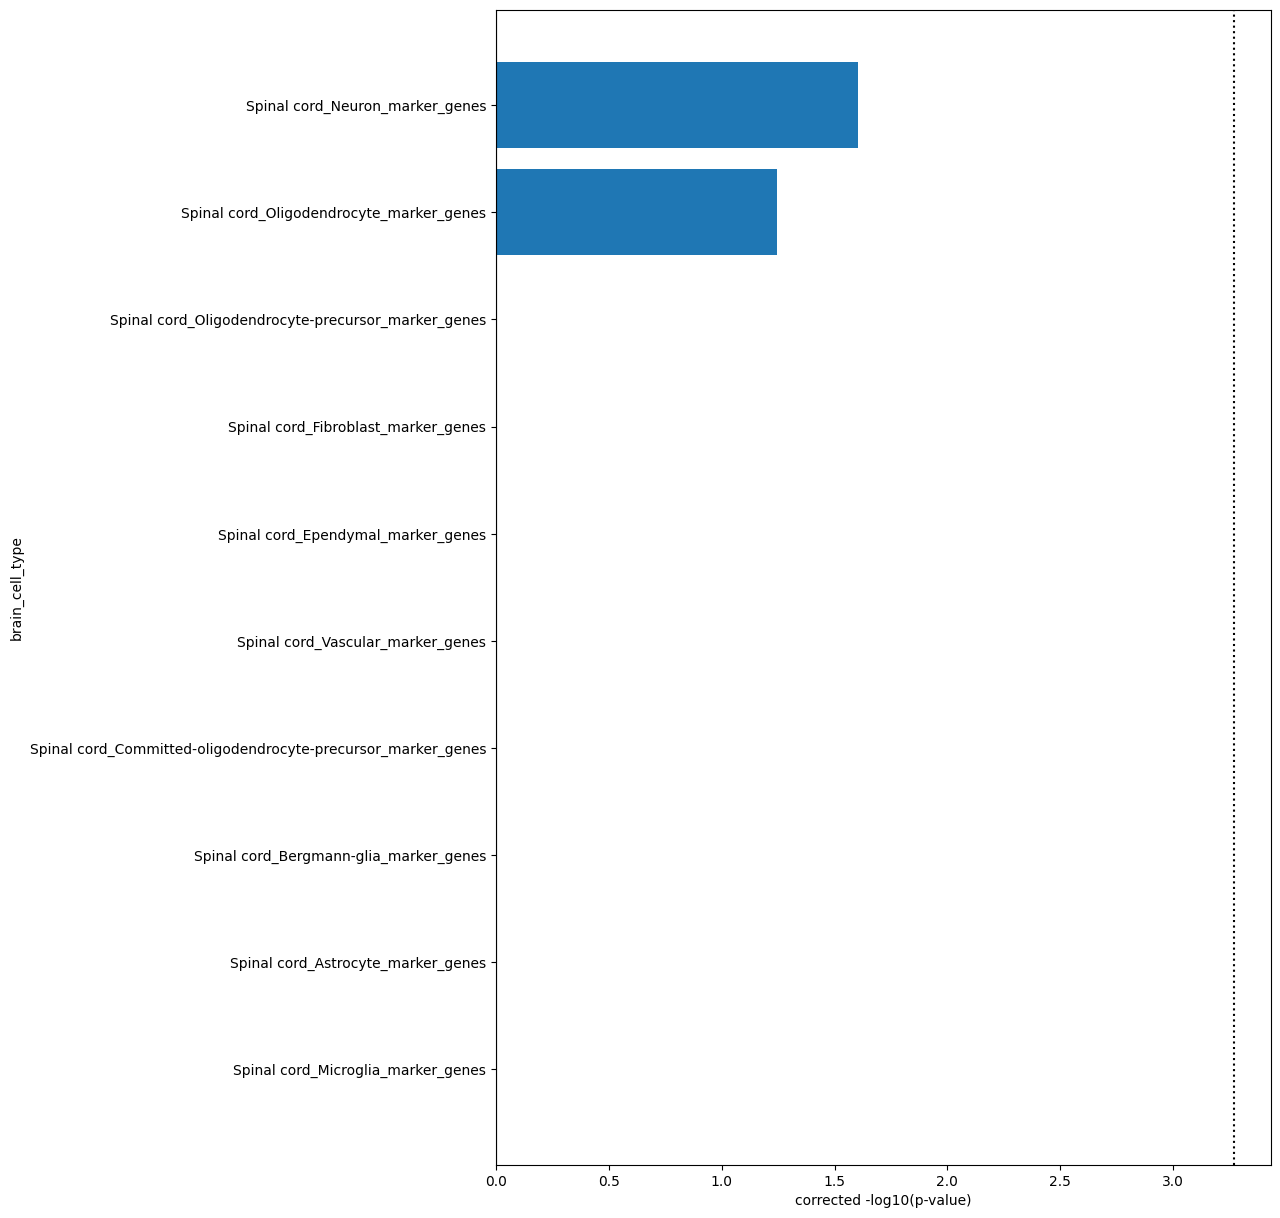

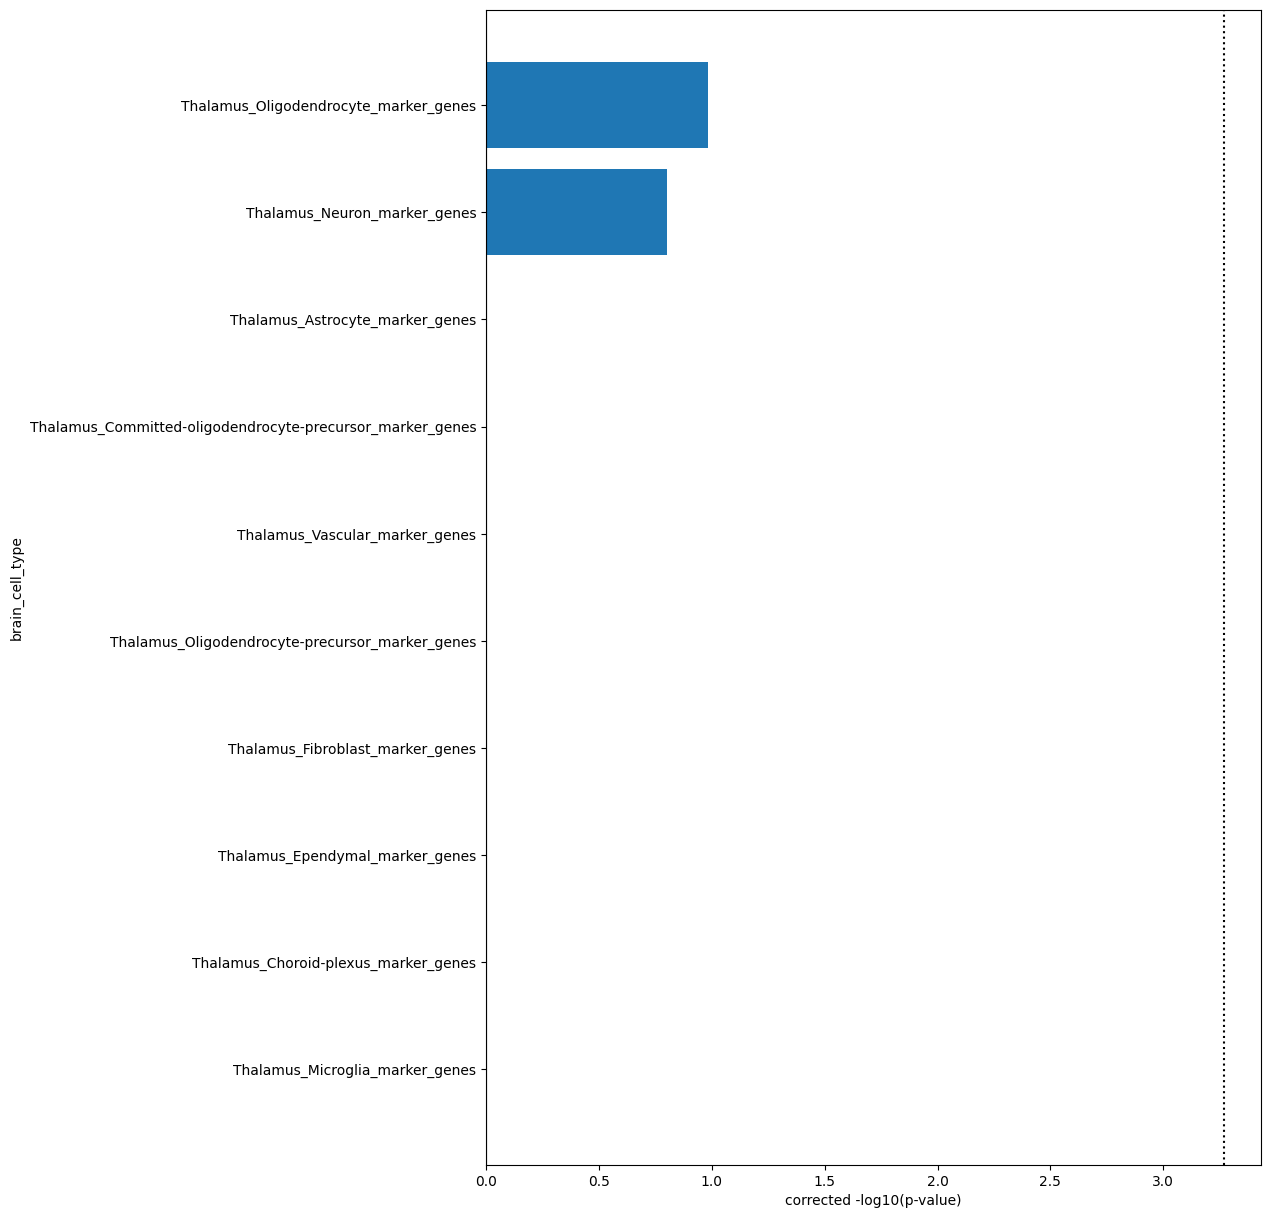

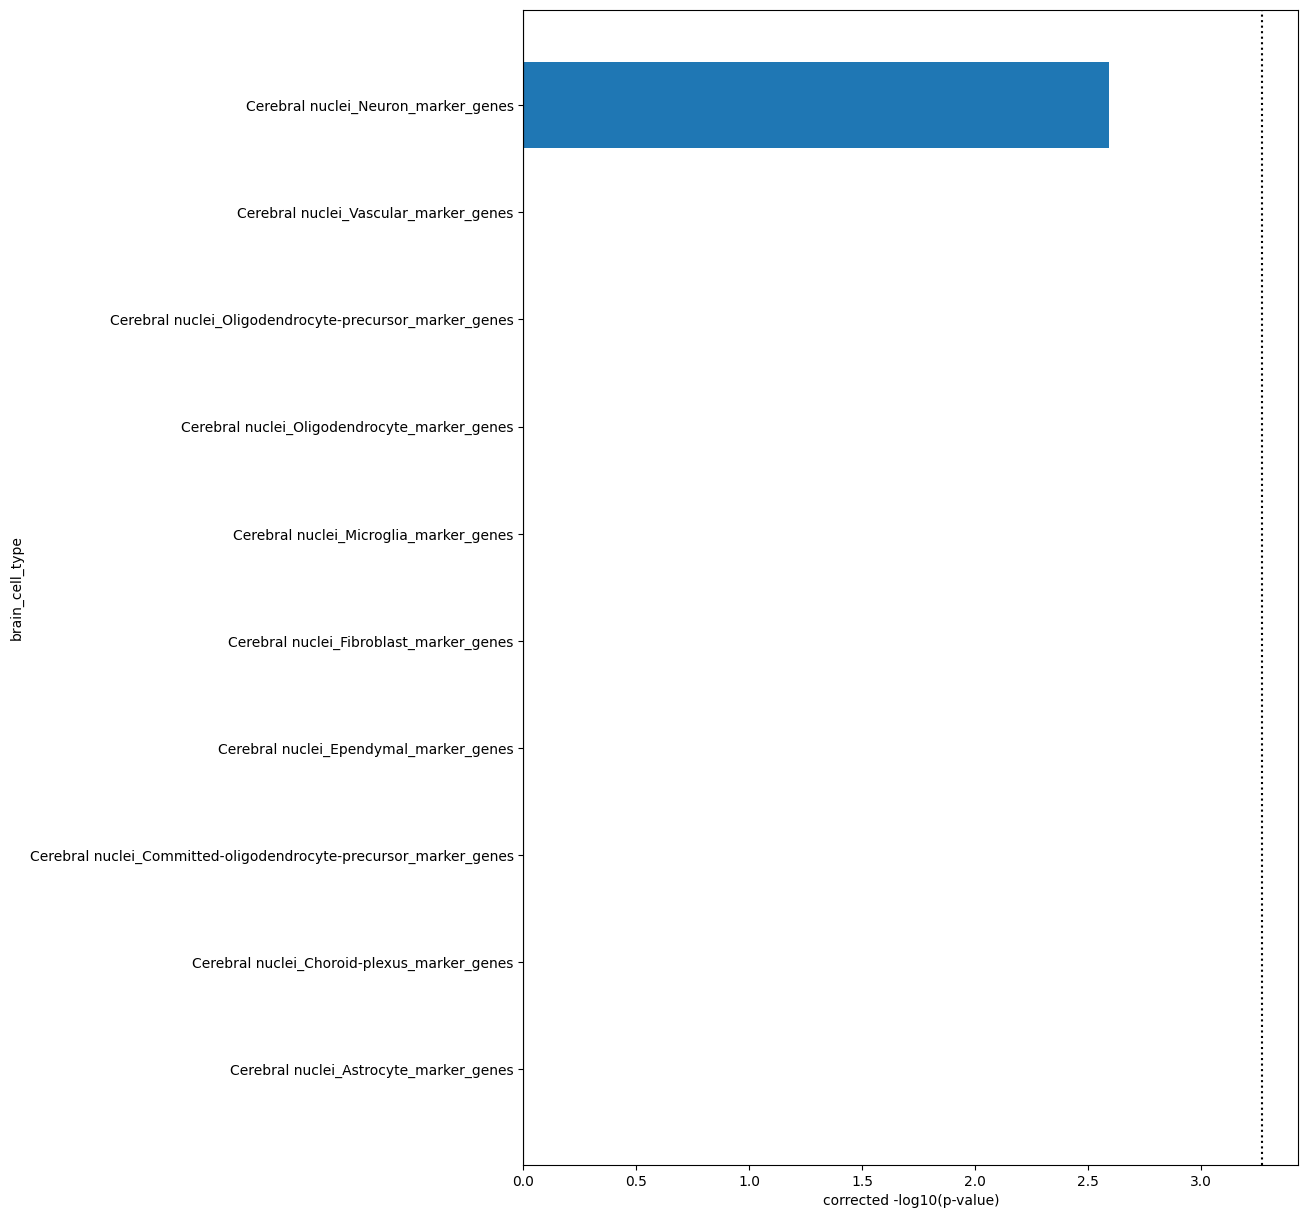

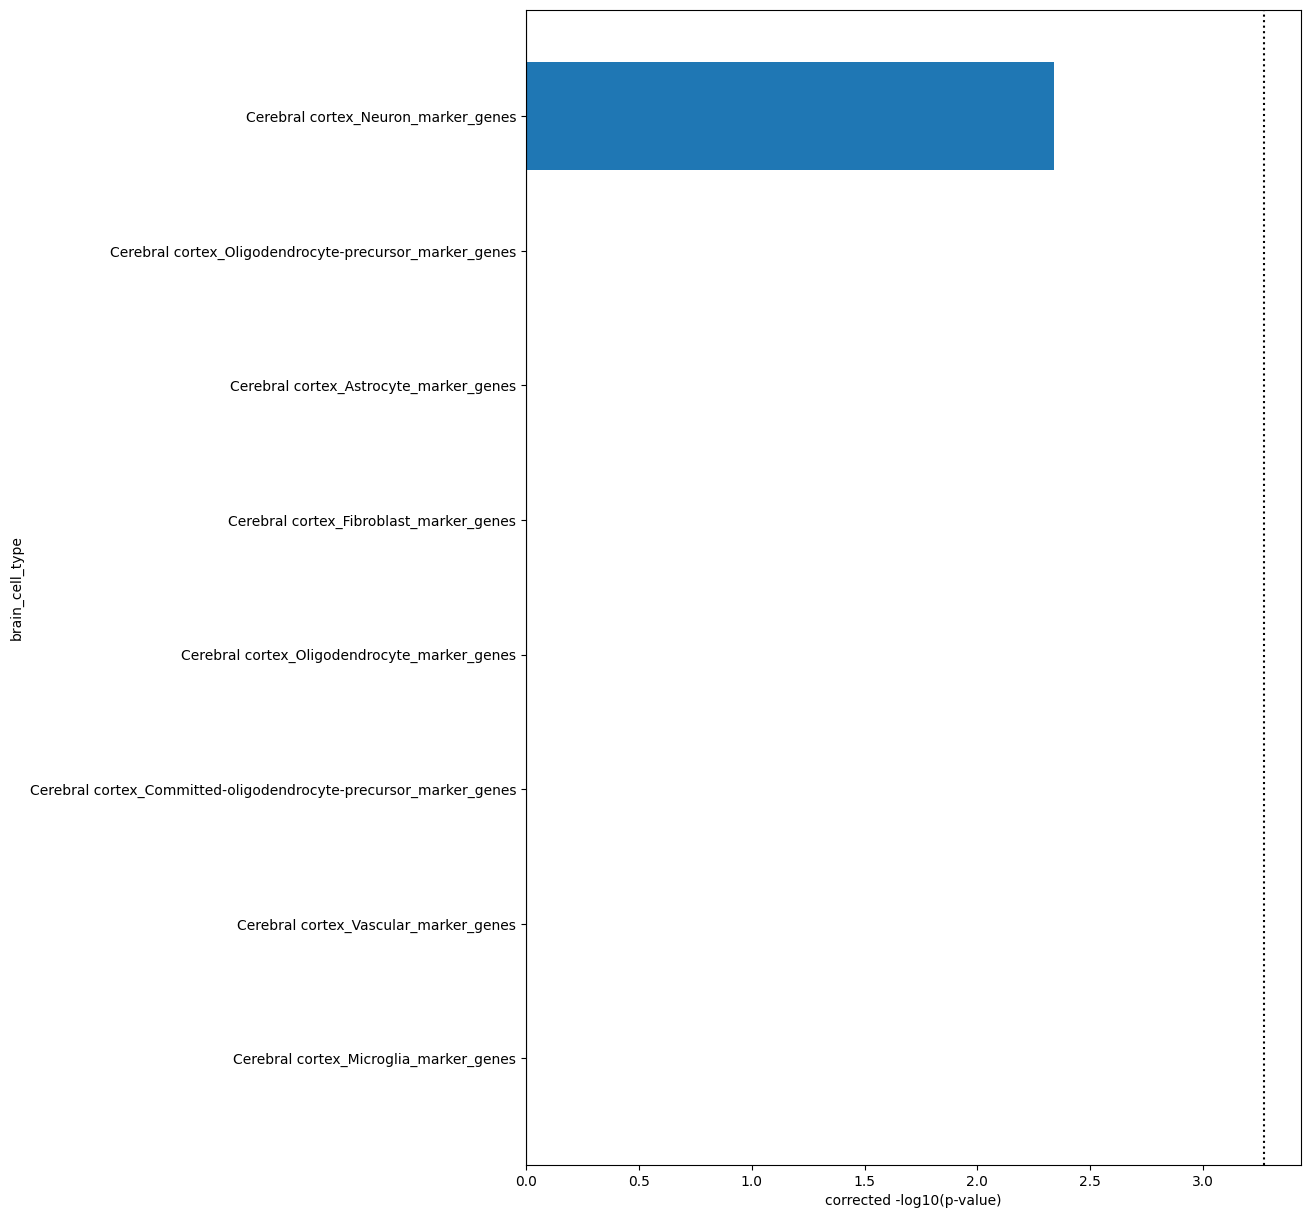

In [58]:
for roi in roi_list:
    tbl=enr_tbl[enr_tbl.key.str.contains(roi)]
    fig = plt.figure(figsize=(10, 15))

    plt.barh(y=tbl.key, width=-np.log10(tbl.p_intersect),label=tbl.key)
    
    plt.ylabel('brain_cell_type')
    plt.xlabel('corrected -log10(p-value)')
    plt.axvline(-np.log10(0.05/len(enr_tbl)), color='black', ls=':')
    plt.axvline(0, color='black', ls='-')

# investigate single dataset

In [70]:
key='Cerebral cortex_Microglia_marker_genes'

In [71]:
values_list = [gene_mapping[key] for key in stat_dict[key] if key in gene_mapping]

In [170]:
roi='Cerebral cortex'
data_dict[f'{roi}_mean']

Cerebral-cortex_Oligodendrocyte  Cerebral-cortex_Neuron  \
Accession                                                                     
ENSG00000000003.15                         0.002268                0.007684   
ENSG00000000005.6                               NaN                0.000750   
ENSG00000000419.13                         0.154495                0.260394   
ENSG00000000457.14                         0.108109                0.168344   
ENSG00000000460.17                         0.100364                0.138965   
...                                             ...                     ...   
ENSG00000288627.1                               NaN                0.000003   
ENSG00000288632.1                          0.093944                0.151355   
ENSG00000288638.1                               NaN                0.000032   
ENSG00000288642.1                          0.001085                0.002557   
ENSG00000288643.1                          0.012325                0.028553   

                    Cerebral-cortex_Fibroblast  Cerebral-cortex_Astrocyte  \
Accession                                                                   
ENSG00000000003.15                    0.111313                   0.084732   
ENSG00000000005.6                     0.001830                   0.001467   
ENSG00000000419.13                    0.160812                   0.184795   
ENSG00000000457.14                    0.110430                   0.137226   
ENSG00000000460.17                    0.141528                   0.087800   
...                                        ...                        ...   
ENSG00000288627.1                          NaN                        NaN   
ENSG00000288632.1                     0.098835                   0.083193   
ENSG00000288638.1                          NaN                        NaN   
ENSG00000288642.1                          NaN                   0.000582   
ENSG00000288643.1                     0.010833                   0.009286   

                    Cerebral-cortex_Oligodendrocyte-precursor  \
Accession                                                       
ENSG00000000003.15                                   0.061129   
ENSG00000000005.6                                    0.001050   
ENSG00000000419.13                                   0.150284   
ENSG00000000457.14                                   0.142933   
ENSG00000000460.17                                   0.098020   
...                                                       ...   
ENSG00000288627.1                                         NaN   
ENSG00000288632.1                                    0.106740   
ENSG00000288638.1                                         NaN   
ENSG00000288642.1                                    0.000792   
ENSG00000288643.1                                    0.016858   

                    Cerebral-cortex_Committed-oligodendrocyte-precursor  \
Accession                                                                 
ENSG00000000003.15                                           0.018747     
ENSG00000000005.6                                                 NaN     
ENSG00000000419.13                                           0.193286     
ENSG00000000457.14                                           0.158703     
ENSG00000000460.17                                           0.086807     
...                                                               ...     
ENSG00000288627.1                                                 NaN     
ENSG00000288632.1                                            0.131312     
ENSG00000288638.1                                                 NaN     
ENSG00000288642.1                                            0.001319     
ENSG00000288643.1                                            0.025238     

                    Cerebral-cortex_Vascular  Cerebral-cortex_Microglia  
Accession                                                                
ENSG00000000003.15  

In [216]:
marker_genes=list(marker_genes[f'{roi})_marker_score'].sort_values(r1,ascending=False).head(50).index)

In [197]:
marker_genes[f'{roi})_marker_score'].sort_values(r1,ascending=False)

Oligodendrocyte      Neuron  Fibroblast  Astrocyte  \
ENSG00000260611.1        74.472461  -74.472461   -2.751514        NaN   
ENSG00000244089.1        45.775060  -45.775060   -3.991145  -3.991145   
ENSG00000228549.4        36.005197  -36.005197   -4.125142  -4.125142   
ENSG00000225295.1        31.074774  -31.074774   -4.646262  -4.646262   
ENSG00000201371.1        30.955699  -30.955699   -4.098504  -4.098504   
...                            ...         ...         ...        ...   
ENSG00000287986.1              NaN  -32.795556   -2.134445  -2.134445   
ENSG00000288013.1              NaN    1.396527   -1.525560  -1.525560   
ENSG00000288046.1              NaN   -3.055826   -2.026169   0.559083   
ENSG00000288111.1              NaN -410.346181  410.346181  -2.099097   
ENSG00000288253.1              NaN   -2.613696   -1.676969   2.613696   

                   Oligodendrocyte-precursor  \
ENSG00000260611.1                   1.052497   
ENSG00000244089.1                  -3.991145   
ENSG00000228549.4                  -4.125142   
ENSG00000225295.1                  -4.646262   
ENSG00000201371.1                  -4.098504   
...                                      ...   
ENSG00000287986.1                  -2.003281   
ENSG00000288013.1                  -1.525560   
ENSG00000288046.1                  -2.026169   
ENSG00000288111.1                        NaN   
ENSG00000288253.1                  -1.676969   

                   Committed-oligodendrocyte-precursor  Vascular  Microglia  
ENSG00000260611.1                             0.942346 -2.751514  -2.751514  
ENSG00000244089.1                            -3.991145 -3.991145  -3.991145  
ENSG00000228549.4                            -4.125142 -4.125142  -4.125142  
ENSG00000225295.1                            -4.646262 -4.646262  -4.646262  
ENSG00000201371.1                            -4.098504 -4.098504  -4.098504  
...                                                ...       ...        ...  
ENSG00000287986.1                            -2.319619  0.653056  -2.034407  
ENSG00000288013.1                            -1.525560 -1.525560  -1.396527  
ENSG00000288046.1                            -2.026169 -2.026169  -0.559083  
ENSG00000288111.1                            -2.099097 -2.099097  -2.099097  
ENSG00000288253.1                            -1.676969 -1.676969  -1.676969  

[44778 rows x 8 columns]

In [140]:
stat_dict[f'{roi}_effect_size']['Oligodendrocyte'][stat_dict[f'{roi})_marker_score']['Oligodendrocyte']==float('inf')]

ENSG00000101812.13      [-1.8046774903134457, nan, inf, nan, nan]
ENSG00000108702.4       [-1.6972796078746246, nan, inf, nan, nan]
ENSG00000110484.7         [28.50766115505822, nan, inf, nan, nan]
ENSG00000123307.4        [-1.363414636036662, nan, inf, nan, nan]
ENSG00000124900.12      [-1.5545874851301582, nan, inf, nan, nan]
                                         ...                     
ENSG00000283349.3        [3.8598920235260747, nan, inf, nan, nan]
ENSG00000287004.1      [0.012215289467227648, nan, inf, nan, nan]
ENSG00000287152.1     [-0.013949160169062362, nan, inf, nan, nan]
ENSG00000287273.1        [-1.411588232507684, nan, inf, nan, nan]
ENSG00000287337.1         [3.611424574385631, nan, inf, nan, nan]
Name: Oligodendrocyte, Length: 124, dtype: object

In [143]:
stat_dict[f'{roi}_tissues_comp']['Oligodendrocyte'][stat_dict[f'{roi})_marker_score']['Oligodendrocyte']==float('inf')]

ENSG00000101812.13    [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
ENSG00000108702.4     [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
ENSG00000110484.7     [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
ENSG00000123307.4     [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
ENSG00000124900.12    [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
                                            ...                        
ENSG00000283349.3     [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
ENSG00000287004.1     [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
ENSG00000287152.1     [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
ENSG00000287273.1     [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
ENSG00000287337.1     [Neuron, Fibroblast, Astrocyte, Vascular, Micr...
Name: Oligodendrocyte, Length: 124, dtype: object

In [149]:
data_dict[f'{roi}_stdev'][stat_dict[f'{roi})_marker_score']['Oligodendrocyte']==float('inf')]

Cerebral-cortex_Oligodendrocyte  Cerebral-cortex_Neuron  \
Accession                                                                     
ENSG00000101812.13                         0.007218                0.008498   
ENSG00000108702.4                          0.006311                0.016023   
ENSG00000110484.7                          0.006811                0.000989   
ENSG00000123307.4                          0.005761                0.013774   
ENSG00000124900.12                         0.006725                0.005391   
...                                             ...                     ...   
ENSG00000283349.3                          0.004414                0.001652   
ENSG00000287004.1                          0.007481                0.004027   
ENSG00000287152.1                          0.006128                0.003558   
ENSG00000287273.1                          0.004700                0.006617   
ENSG00000287337.1                          0.003994                0.001597   

                    Cerebral-cortex_Fibroblast  Cerebral-cortex_Astrocyte  \
Accession                                                                   
ENSG00000101812.13                         0.0                   0.001356   
ENSG00000108702.4                          0.0                   0.004151   
ENSG00000110484.7                          0.0                   0.005235   
ENSG00000123307.4                          0.0                   0.004489   
ENSG00000124900.12                         0.0                   0.002826   
...                                        ...                        ...   
ENSG00000283349.3                          0.0                   0.003436   
ENSG00000287004.1                          0.0                   0.003139   
ENSG00000287152.1                          0.0                   0.004311   
ENSG00000287273.1                          0.0                   0.003633   
ENSG00000287337.1                          0.0                   0.002701   

                    Cerebral-cortex_Oligodendrocyte-precursor  \
Accession                                                       
ENSG00000101812.13                                   0.000000   
ENSG00000108702.4                                    0.000000   
ENSG00000110484.7                                    0.000000   
ENSG00000123307.4                                    0.000000   
ENSG00000124900.12                                   0.000000   
...                                                       ...   
ENSG00000283349.3                                    0.000000   
ENSG00000287004.1                                    0.010381   
ENSG00000287152.1                                    0.000000   
ENSG00000287273.1                                    0.000000   
ENSG00000287337.1                                    0.000000   

                    Cerebral-cortex_Committed-oligodendrocyte-precursor  \
Accession                                                                 
ENSG00000101812.13                                                0.0     
ENSG00000108702.4                                                 0.0     
ENSG00000110484.7                                                 0.0     
ENSG00000123307.4                                                 0.0     
ENSG00000124900.12                                                0.0     
...                                                               ...     
ENSG00000283349.3                                                 0.0     
ENSG00000287004.1                                                 0.0     
ENSG00000287152.1                                                 0.0     
ENSG00000287273.1                                                 0.0     
ENSG00000287337.1                                                 0.0     

                    Cerebral-cortex_Vascular  Cerebral-cortex_Microglia  
Accession                                                                
ENSG00000101812.13  

should the precursors have been removed from the initial normalization? I think you could argue both ways, but either way they are not being considered in the statistical test.

# write stats to files

In [ ]:
for m in [x for x in stat_dict.keys() if not x.endswith('marker_genes')]:
    print(f'writing {m}')
    stat_dict[m].(f'scRNA_seq/processed/{m}.csv',index=False):

In [32]:
for m in [x for x in stat_dict.keys() if x.endswith('marker_genes')]:
    print(f'writing {m}')
    with open(f'scRNA_seq/processed/{m}.txt', "w") as outfile:
        outfile.write("\n".join(stat_dict[m]))

writing Epithalamus_Astrocyte_marker_genes
writing complete for Epithalamus_Astrocyte_marker_genes
writing Epithalamus_Committed-oligodendrocyte-precursor_marker_genes
writing complete for Epithalamus_Committed-oligodendrocyte-precursor_marker_genes
writing Epithalamus_Ependymal_marker_genes
writing complete for Epithalamus_Ependymal_marker_genes
writing Epithalamus_Fibroblast_marker_genes
writing complete for Epithalamus_Fibroblast_marker_genes
writing Epithalamus_Microglia_marker_genes
writing complete for Epithalamus_Microglia_marker_genes
writing Epithalamus_Neuron_marker_genes
writing complete for Epithalamus_Neuron_marker_genes
writing Epithalamus_Oligodendrocyte_marker_genes
writing complete for Epithalamus_Oligodendrocyte_marker_genes
writing Epithalamus_Oligodendrocyte-precursor_marker_genes
writing complete for Epithalamus_Oligodendrocyte-precursor_marker_genes
writing Epithalamus_Vascular_marker_genes
writing complete for Epithalamus_Vascular_marker_genes
writing Hindbrain_A

In [ ]:
rna_data.to_csv('scRNA_seq/transcript_id_meta/rna_data_in_pcnet.csv',index=False)

In [ ]:
dup.to_csv('scRNA_seq/transcript_id_meta/rna_data_in_pcnet_duplicated.csv',index=False)

# filter genes from data dict

In [112]:
tbl=gene_data[gene_data.Accession.isin(t)]

In [113]:
u=tbl[tbl.Gene.duplicated()].sort_values('Gene')['Accession']

In [114]:
t=[]
for roi in roi_list:
    print(data_dict[f'{roi}_mean'][data_dict[f'{roi}_mean'].index.isin(u)])

Empty DataFrame
Columns: [Epithalamus_Astrocyte, Epithalamus_Committed-oligodendrocyte-precursor, Epithalamus_Ependymal, Epithalamus_Fibroblast, Epithalamus_Microglia, Epithalamus_Neuron, Epithalamus_Oligodendrocyte, Epithalamus_Oligodendrocyte-precursor, Epithalamus_Vascular]
Index: []
Empty DataFrame
Columns: [Hindbrain_Astrocyte, Hindbrain_Bergmann-glia, Hindbrain_Choroid-plexus, Hindbrain_Committed-oligodendrocyte-precursor, Hindbrain_Ependymal, Hindbrain_Fibroblast, Hindbrain_Microglia, Hindbrain_Neuron, Hindbrain_Oligodendrocyte, Hindbrain_Oligodendrocyte-precursor, Hindbrain_Vascular]
Index: []
Empty DataFrame
Columns: [Hippocampus_Astrocyte, Hippocampus_Choroid-plexus, Hippocampus_Committed-oligodendrocyte-precursor, Hippocampus_Ependymal, Hippocampus_Fibroblast, Hippocampus_Microglia, Hippocampus_Neuron, Hippocampus_Oligodendrocyte, Hippocampus_Oligodendrocyte-precursor, Hippocampus_Vascular]
Index: []
Empty DataFrame
Columns: [Hypothalamus_Astrocyte, Hypothalamus_Committed-ol

In [90]:
u

57007           ENSG00000285626.1
57258           ENSG00000285912.1
17467    ENSG00000197976.12_PAR_Y
33877     ENSG00000237531.6_PAR_Y
24500     ENSG00000223511.7_PAR_Y
                   ...           
20315           ENSG00000206669.1
20313           ENSG00000206663.1
20419           ENSG00000206797.1
24109           ENSG00000222503.1
56898           ENSG00000285447.1
Name: Accession, Length: 317, dtype: object

In [86]:
len(set(tbl[tbl.Gene.duplicated()].Accession))

317

In [87]:
len(set(tbl[tbl.Gene.duplicated()].Gene))

64